## Bosquejo de *approach* fuera de la API de keras
#### Autor: Francisco Mena

In [1]:
#imports
import keras, time,os,sys,gc
from keras.layers import *
from keras.models import Sequential,Model
from keras.models import clone_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from sklearn.cluster import AffinityPropagation, SpectralClustering,AgglomerativeClustering,DBSCAN,KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from code.utils import *
from code.representation import *

In [3]:
DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

### Load Data

In [4]:
""" WINE
#df_white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",sep=';')
df_red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",sep=';')

df_red["normal"] = df_red["quality"]==5
df_red["good"] = df_red["quality"]>5
df_red["bad"] = df_red["quality"]<5
df_red["qualities"] = 0*df_red["bad"]+df_red["normal"]+2*df_red["good"]
df_red.drop(['quality','normal','good','bad'],axis=1,inplace=True)

y_train = df_red.pop("qualities").values*1
X_train = df_red.values

y_obs = np.loadtxt("annotations_wine.csv",delimiter=',',dtype='int')
"""

#from keras.datasets import cifar10
#(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
#y_obs = np.loadtxt("../syntetic/annotations_cifar.csv",delimiter=',',dtype='int')

#""" Syntetic data
X_train = np.loadtxt("./synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt("./synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth
y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal.csv",delimiter=',',dtype='int')
#y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal_soft.csv",delimiter=',',dtype='int')


X_test = np.loadtxt("./synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt("./synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
#"""

groups_annot = np.loadtxt("../syntetic/simple/annotgroups_datasim_normal.csv",delimiter=',',dtype='int')
load_matrix = np.loadtxt('./synthetic/simple/matrix_datasim_normal.csv',delimiter=',')
rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
confe_matrix = real_conf_matrix[groups_annot]


N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Shape (data,annotators):  (2292, 100)
Classes:  3


In [4]:
path = "."
scenario = 1

In [12]:
from code.generate_data import SinteticData

X_train = np.loadtxt(path+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(path+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(path+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(path+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth


from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.7855107855107855
Shape (data,annotators):  (2457, 100)
Classes:  3


In [84]:
aux2 = [0.15,0.4,0.45]
aux1 = GenerateData.conf_matrix.copy()

In [6]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation in params 3 is between --1 is for good fit (maybe overfitting)

#number of groups is needed

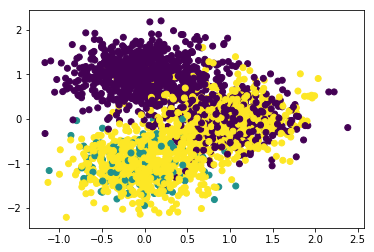

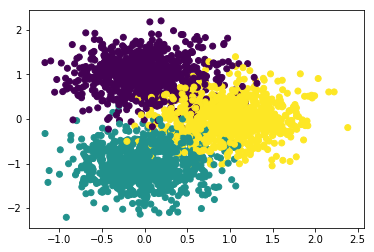

In [15]:
mv = majority_voting(y_obs,onehot=False,probas=False,repeats=False)
plt.scatter(X_train[:,0],X_train[:,1],c=mv)
plt.show()
plt.scatter(X_train[:,0],X_train[:,1],c=Z_train)

In [13]:
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

In [6]:
X_train = X_train.astype(DTYPE_OP)
X_test = X_test.astype(DTYPE_OP)
Xstd_train = X_train/255
Xstd_test = X_test/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

In [14]:
from code.representation import *
##transformar a repeat
r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)

vector of repeats:
 [[ 3  0 10]
 [ 0  6  2]
 [ 2  0 10]
 ...
 [ 2  2  8]
 [ 5  0  3]
 [ 6  0  1]]


In [41]:
import numpy as np
from scipy.stats import entropy
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import DBSCAN,AffinityPropagation, MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score
import gc, keras, time, sys

from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple #deep learning
from code.representation import *
from code.utils import softmax


def aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP='float32',option="hard",l=0.005):
    # Get p(g=m|t)  based on a proyection of the annotator "t" 
    std = StandardScaler()
    data_to_cluster = std.fit_transform(data_to_cluster) 
        
    kmeans = MiniBatchKMeans(n_clusters=M, random_state=0,init='k-means++',batch_size=128)
    #KMeans(M,init='k-means++', n_jobs=-1,random_state=0)
    kmeans.fit(data_to_cluster)
    distances = kmeans.transform(data_to_cluster)

    if option=="fuzzy":
        probas_t = np.zeros_like(distances,dtype=DTYPE_OP)
        for t in range(probas_t.shape[0]):
            for m in range(probas_t.shape[1]):
                m_fuzzy = 1.2
                probas_t[t,m] = 1/(np.sum( np.power((distances[t,m]/(distances[t,:]+keras.backend.epsilon())), 2/(m_fuzzy-1)) ) + keras.backend.epsilon())
    elif option == "softmax":
        probas_t = softmax(-(distances+keras.backend.epsilon())/l).astype(DTYPE_OP)
    elif option == "softmax inv":
        probas_t = softmax(1/(l*distances+keras.backend.epsilon())).astype(DTYPE_OP)
    elif option == 'hard':
        probas_t = keras.utils.to_categorical(kmeans.labels_,num_classes=M)
    #another option??
        #model = GaussianMixture(n_components=M)
        #model.fit(data_to_cluster)
        #probas_t = model.predict_proba(data_to_cluster).astype(DTYPE_OP)
    return probas_t
            


def project_and_cluster(y_o,M_to_try=20,anothers_visions=True,DTYPE_OP='float32',printed=True,mode_project="pca"):
    ###another way to cluster..
    if len(y_o.shape) == 2:
        M_itj = categorical_representation(y_o,no_label =-1)
    else:
        M_itj = y_o.copy()
    data_to_cluster = M_itj.transpose(1,0,2).reshape(M_itj.shape[1],M_itj.shape[0]*M_itj.shape[2])
    data_to_cluster = data_to_cluster.astype(DTYPE_OP)
    
    if mode_project.lower() == "pca":
        model = PCA(n_components=4)
    elif mode_project.lower() == "tpca":
        model = TruncatedSVD(n_components=4)
    elif mode_project.lower() == "kpca":
        model = KernelPCA(n_components=4, kernel='rbf', n_jobs=-1)

    plot_data = model.fit_transform(data_to_cluster)
    to_return = [plot_data]
    
    if printed:
        model = BayesianGaussianMixture(n_components=M_to_try)
        model.fit(plot_data)
        M_founded = len(set(np.argmax(model.predict_proba(plot_data),axis=1))) 
        print("Bayesian gaussian mixture say is %d clusters "%M_founded)

        if anothers_visions:
            X_sim = metrics.pairwise_distances(plot_data,metric='euclidean',n_jobs=-1)
            #dos indicadores de numero de cluster
            model = DBSCAN(eps=np.mean(X_sim), min_samples=5, metric='precomputed', n_jobs=-1)
            model.fit(X_sim)
            print("DBSCAN say is %d clusters"%len(set(model.labels_)))
            model = AffinityPropagation(affinity='precomputed')
            model.fit(X_sim)
            print("Affinity Propagation say is %d clusters"%len(set(model.labels_)))

        to_return.append( M_founded )
    return to_return


class GroupMixtureOpt(object): #optimized version
    def __init__(self,input_dim,Kl,M=2,epochs=1,optimizer='adam',pre_init=10,dtype_op='float32'): 
        if type(input_dim) != tuple:
            input_dim = (input_dim,)
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        #params
        self.M = M #groups of annotators
        self.epochs = epochs
        self.optimizer = optimizer
        self.pre_init = pre_init
        self.DTYPE_OP = dtype_op
        
        self.Keps = keras.backend.epsilon() 
        self.priors=False #boolean of priors
        self.compile=False
        self.seted_alphainit = False
        self.lambda_random = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas.copy()
    def get_alpha(self):
        """Get alpha param, p(g) globally"""
        return self.alphas.copy()
    def set_alpha(self,alpha_init):
        """set alpha param with a previosuly method"""
        self.alpha_init = alpha_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        """Get Q estimation param, this is Q_ij(g,z) = p(g,z|xi,y=j)"""
        return self.Qij_mgamma.copy()
        
    def define_model(self,tipo,start_units=1,deep=1,double=False,drop=0.0,embed=True,BatchN=True):
        """Define the base model and other structures"""
        self.type = tipo.lower()     
        if self.type == "keras_shallow" or 'perceptron' in self.type: 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        elif self.type=='defaultcnn' or self.type=='default cnn':
            self.base_model = default_CNN(self.input_dim,self.Kl)
        elif self.type=='defaultrnn' or self.type=='default rnn':
            self.base_model = default_RNN(self.input_dim,self.Kl)
        elif self.type=='defaultrnnE' or self.type=='default rnn E': #with embedding
            self.base_mode = default_RNNw_emb(self.input_dim,self.Kl,len) #len is the length of the vocabulary
            #podria ser el maximo

        elif self.type == "ff" or self.type == "mlp" or self.type=='dense': #classic feed forward
            print("Needed params (units,deep,drop,BatchN?)") #default activation is relu
            self.base_model = MLP_Keras(self.input_dim,self.Kl,start_units,deep,BN=BatchN,drop=drop)

        elif self.type=='simplecnn' or self.type=='simple cnn' or 'cnn' in self.type:
            print("Needed params (units,deep,drop,double?,BatchN?)") #default activation is relu
            self.base_model = CNN_simple(self.input_dim,self.Kl,start_units,deep,double=double,BN=BatchN,drop=drop)
        
        elif self.type=='simplernn' or self.type=='simple rnn' or 'rnn' in self.type:
            print("Needed params (units,deep,drop,embed?)")
            self.base_model = RNN_simple(self.input_dim,self.Kl,start_units,deep,drop=drop,embed=embed,len=0,out=start_units*2)
            #and what is with embedd

        #if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
        #    self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        #     future..
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X):
        """Return the predictions of the model if is from sklearn or keras"""
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=self.batch_size)
    
    def init_E(self,X,r):
        """Realize the initialziation of the E step on the EM algorithm"""
        #-------> init alpha
        if not self.seted_alphainit: #random is the worst option
            self.alpha_init = np.random.dirichlet(np.ones(self.M)/50,size=(self.N,self.Kl))
        
        #-------> init Majority voting        
        self.mv_probs_j = majority_voting(r,repeats=True,probas=True) # soft -- p(y=j|xi)
        
        print("Pre-train network on %d epochs..."%(self.pre_init),end='',flush=True)
        self.base_model.fit(X,self.mv_probs_j,batch_size=self.batch_size,epochs=self.pre_init,verbose=0)
        print(" Done!")
        #reset optimizer but hold weights--necessary for stability 
        self.base_model.compile(loss='categorical_crossentropy',optimizer=self.optimizer)

        #-------> Initialize p(z=gamma|xi,y=j,g): Combination of mv and belive observable
        lambda_group = np.ones((self.M),dtype=self.DTYPE_OP) 
        if self.lambda_random:
            for m in range(self.M):
                lambda_group[m] = np.random.beta(1,1)
        print("Lambda by group: ",lambda_group)
        Zijm = np.zeros((self.N,self.Kl,self.M,self.Kl),dtype=self.DTYPE_OP)
        for j_ob in range(self.Kl):
            onehot = np.tile(self.Keps, self.Kl)
            onehot[j_ob] = 1. #all belive in the observable
            for m in range(self.M):                
                Zijm[:,j_ob,m,:] = lambda_group[m]*self.mv_probs_j + (1-lambda_group[m])*onehot 
          
        #-------> init q_ij      
        self.Qij_mgamma = self.alpha_init[:,:,:,None]*Zijm
        
        #-------> init betas
        self.betas = np.zeros((self.M,self.Kl,self.Kl),dtype=self.DTYPE_OP) 

        #-------> init alphas
        self.alphas = np.zeros((self.M),dtype=self.DTYPE_OP)
     
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",self.mv_probs_j.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qij_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if type(priors) == str:
            if priors == "laplace":
                priors = 1
            else:
                print("Prior string do not understand")
                return
        else:
            if len(priors.shape)==2:
                priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions):
        """ Realize the E step in matrix version"""       
        p_new = np.clip(predictions[:,None,None,:] , self.Keps,1.) #safe logarithmn
        a_new = np.clip(self.alphas[None,None,:,None] , self.Keps,1.) #safe logarithmn
        b_new = np.clip((self.betas[None,:,:,:]).transpose(0,3,1,2) , self.Keps,1.) #safe logarithmn
        
        self.Qij_mgamma = np.exp(np.log(p_new) + np.log(a_new) + np.log(b_new)) 
        self.aux_for_like = (self.Qij_mgamma.sum(axis=-1)).sum(axis=-1) #p(y=j|x) --marginalized
        self.Qij_mgamma = self.Qij_mgamma/self.aux_for_like[:,:,None,None] #normalize
        
    def M_step(self,X,r): 
        """ Realize the M step"""
        #-------> base model
        Qij_gamma = self.Qij_mgamma.sum(axis=-2) #qij(gamma)
        r_estimate = np.zeros((self.N,self.Kl),dtype=self.DTYPE_OP) #create the repeat "estimate"/"ground truth"
        for i in range(self.N):
            r_estimate[i] = np.tensordot(Qij_gamma[i],r[i],axes=[[0],[0]])
        if "sklearn" in self.type:#train to learn p(z|x)
            self.base_model.fit(X, np.argmax(r_estimate,axis=1) ) 
        else:
            self.base_model.fit(X,r_estimate,batch_size=self.batch_size,epochs=self.epochs,verbose=0) 
    
        #-------> alpha 
        Qij_m = self.Qij_mgamma.sum(axis=-1) #qij(m)
        self.alphas = np.tensordot(Qij_m, r , axes=[[0,1],[0,1]]) # sum_ij r_ij(g) = Qij_m[i]*r[i] 
        self.alphas = self.alphas.astype(self.DTYPE_OP) #necessary
        self.alphas = self.alphas/self.alphas.sum(axis=-1,keepdims=True) #p(g) -- normalize
        
        #-------> beta
        for j_ob in range(self.Kl):
            self.betas[:,:,j_ob] = np.tensordot(self.Qij_mgamma[:,j_ob,:,:],r[:,j_ob], axes=[[0],[0]]) # ~p(yo=j|g,z)              
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior functio
        self.betas = self.betas/self.betas.sum(axis=-1,keepdims=True) #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        """ Compute the log-likelihood of the optimization schedule"""
        return np.tensordot(r , np.log(self.aux_for_like+self.Keps))+0. #safe logarithm
                                                  
    def train(self,X_train,r_train,batch_size=64,max_iter=500,relative=True,val=False,tolerance=1e-2):
        if not self.compile:
            print("You need to create the model first, set .define_model")
            return
        print("Initializing new EM...")
        self.batch_size = batch_size
        self.N = X_train.shape[0]
        self.init_E(X_train,r_train)
        
        logL = []
        stop_c = False
        tol,old_model,old_betas,old_alphas = np.inf,np.inf,np.inf,np.inf
        self.current_iter = 1
        while(not stop_c):
            print("Iter %d/%d\nM step:"%(self.current_iter,max_iter),end='',flush=True)
            start_time = time.time()
            self.M_step(X_train,r_train)
            print(" done,  E step:",end='',flush=True)
            predictions = self.get_predictions(X_train) #p(z|x) 
            self.E_step(X_train,predictions)
            print(" done //  (in %.2f sec)\t"%(time.time()-start_time),end='',flush=True)
            logL.append(self.compute_logL(r_train,predictions))
            print("logL: %.3f\t"%(logL[-1]),end='',flush=True)
            if self.current_iter>=2:
                tol = np.abs(logL[-1] - logL[-2])                    
                if relative:
                    tol = tol/np.abs(logL[-2])
                tol2 = np.mean(np.abs(self.betas.flatten()-old_betas)/(old_betas+self.Keps)) #confusion
                tol3 = np.mean(np.abs(self.alphas-old_alphas)/(old_alphas+self.Keps)) #alphas
                print("Tol1: %.5f\tTol2: %.5f\tTol3: %.5f\t"%(tol,tol2,tol3),end='',flush=True)
            old_betas = self.betas.flatten().copy()         
            old_alphas = self.alphas.copy()
            #if val:
            #    print("F1: %.4f"%(f1_score(Z_train, predictions.argmax(axis=1),average='micro')),end='',flush=True)
            self.current_iter+=1
            print("")
            if self.current_iter>max_iter or (tol<=tolerance and tol2<=tolerance): #alphas fuera: and tol3<=tolerance
                stop_c = True 
        print("Finished training!")
        gc.collect()
        return np.asarray(logL)
    
    def annotations_2_group(self,annotations,data=[],pred=[],no_label_sym = -1):
        """
            Map some annotations to some group model by the confusion matrices, p(g| {x_l,y_l})
        """
        if len(pred) != 0:
            predictions_m = pred #if prediction_m is passed
        elif len(data) !=0: 
            predictions_m = self.get_predictions_groups(data) #if data is passed
        else:
            print("Error, in order to match annotations to a group you need pass the data X or the group predictions")
            return
            
        result = np.log(self.get_alpha()+self.Keps)
        aux_annotations = [(i,annotation) for i, annotation in enumerate(annotations) if annotation != no_label_sym]
        for i, annotation in aux_annotations:
            if annotation != no_label_sym: #if label it
                for m in range(self.M):
                    result[m] += np.log(predictions_m[i,m,annotation]+self.Keps)
        result = np.exp(result - result.max(axis=-1, keepdims=True) ) #invert logarithm in safe way
        return result/np.sum(result)
    
    def stable_train(self,X,r,batch_size=64,max_iter=50,tolerance=1e-2,cluster=True,bulk_annotators=[]):
        """
            A stable schedule to train a model on this formulation
        """
        self.lambda_random = False #lambda=1
        self.define_priors('laplace')
        
        if cluster: # do annotator clustering
            if len(bulk_annotators) == 0:
                alphas_clusterized = clusterize_annotators(r,M=self.M,bulk=False,cluster_type='loss',data=X,model=self.base_model,DTYPE_OP=self.DTYPE_OP,BATCH_SIZE=batch_size) #clusteriza en base aloss
            elif len(bulk_annotators) == 1:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1)
            else:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1,data=bulk_annotators[1])
            self.set_alpha(alphas_clusterized)

        logL_hist = self.train(X,r,batch_size=batch_size,max_iter=max_iter,tolerance=tolerance,relative=True,val=False)
        return logL_hist
    
    #and multiples runs with lambda random false?
    def multiples_run(self,Runs,X,r,batch_size=64,max_iter=50,tolerance=1e-2,cluster=True,bulk_annotators=[]): 
        """
            Run multiples max_iter of EM algorithm, with random stars
        """
        self.define_priors('laplace')
        
        if cluster: # do annotator clustering
            if len(bulk_annotators) == 0:
                alphas_clusterized = clusterize_annotators(r,M=self.M,bulk=False,cluster_type='loss',data=X,model=self.base_model,DTYPE_OP=self.DTYPE_OP,BATCH_SIZE=batch_size) #clusteriza en base aloss
            elif len(bulk_annotators) == 1:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1)
            else:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1,data=bulk_annotators[1],DTYPE_OP=self.DTYPE_OP)
            self.set_alpha(alphas_clusterized)
            
        found_betas = []
        found_alphas = []
        found_model = []
        found_logL = []
        for run in range(Runs):
            self.base_model = keras.models.clone_model(self.base_model) #reset-weigths
            self.base_model.compile(loss='categorical_crossentropy',optimizer=self.optimizer)

            logL_hist = self.train(X,r,batch_size=batch_size,max_iter=max_iter,tolerance=tolerance,relative=True) #here the models get resets
            
            found_betas.append(self.betas.copy())
            found_alphas.append(self.alphas.copy())
            found_model.append(self.base_model) #revisar si se resetean los pesos o algo asi..
            found_logL.append(logL_hist)
            gc.collect()
        #setup the configuration with maximum log-likelihood
        logL_iter = np.asarray([np.max(a) for a in found_logL])
        indexs_sort = np.argsort(logL_iter)[::-1] 
        
        self.betas = found_betas[indexs_sort[0]].copy()
        self.alphas = found_alphas[indexs_sort[0]].copy()
        self.base_model = found_model[indexs_sort[0]]
        self.E_step(X,self.get_predictions(X)) #to set up Q
        return found_logL,indexs_sort[0]
    
    def get_predictions_group(self,m,X):
        """ Predictions of group "m", p(y^o | xi, g=m) """
        p_z = self.get_predictions(X)
        p_y_m = np.zeros(p_z.shape)
        for i in range(self.N):
            p_y_m[i] = np.tensordot(p_z[i,:] ,self.betas[m,:,:],axes=[[0],[0]] ) # sum_z p(z|xi) * p(yo|z,g=m)
        return p_y_m 
    
    def get_predictions_groups(self,X):
        """ Predictions of all groups , p(y^o | xi, g) """
        p_z = self.get_predictions(X)
        predictions_m = np.tensordot(p_z ,self.betas,axes=[[1],[1]] ) #sum_z p(z|xi) * p(yo|z,g)
        return predictions_m#.transpose(1,0,2)

    def calculate_extra_components(self,X,y_o,T,calculate_pred_annotator=True):
        """
            Measure indirect probabilities through bayes and total probability of annotators
        """
        predictions_m = self.get_predictions_groups(X) #p(y^o|x,g=m)
        
        prob_Gt = np.zeros((T,self.M)) #p(g|t)
        for t in range(T):
            prob_Gt[t] = self.annotations_2_group(y_o[:,t],pred=predictions_m) 

        prob_Yzt = np.tensordot(prob_Gt, self.get_confusionM(),axes=[[1],[0]])  #p(y^o|z,t) = sum_g p(g|t) * p(yo|z,g)
  
        if calculate_pred_annotator:
            prob_Yxt = np.tensordot(predictions_m, prob_Gt, axes=[[1],[1]]).transpose(0,2,1) #p(y^o|x,t) = sum_g p(g|t) *p(yo|x,g)
        else:
            prob_Yxt = None
        gc.collect()
        return predictions_m, prob_Gt, prob_Yzt, prob_Yxt
    
    def get_annotator_reliability(self,y_o,X,t):
        """Get annotator reliability, based on his annotations:"""        
        prob_Gt = annotations_2_group(self,y_o[:,t],data=X)
        
        prob_Yzt = np.tensordot(prob_Gt, self.get_confusionM(),axes=[[0],[0]])  #p(y^o|z,t) = sum_g p(g|t) * p(yo|z,g)
        return prob_Yzt #do something with it


In [16]:
def clusterize_annotators(y_o,M,no_label=-1,bulk=True,cluster_type='loss',data=[],model=None,DTYPE_OP='float32',BATCH_SIZE=64,option="hard",l=0.005):
    start_time = time.time()
    if bulk: 
        if len(y_o.shape) == 2:
            M_itj = categorical_representation(y_o,no_label =no_label)
        else:
            M_itj = y_o.copy()
        mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
        mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
        M_itj[mask_nan] = 1
        #M_itj = M_itj.astype(DTYPE_OP)
        #M_itj_norm = M_itj/M_itj.sum(axis=1,keepdims=True)#[:,None,:]
                
        if len(data) != 0:
            data_to_cluster = data.copy() #annotators_pca
        else:
            data_to_cluster = M_itj.transpose(1,0,2).reshape(M_itj.shape[1],M_itj.shape[0]*M_itj.shape[2])
            
        probas_t = aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP,option,l) #0.05 is close to one-hot
        print("Clustering Done!")
        #alphas_init = np.tensordot(M_itj_norm,probas_t, axes=[[1],[0]]) 
        alphas_init = np.tensordot(M_itj, probas_t, axes=[[1],[0]]) 
        alphas_init = alphas_init/alphas_init.sum(axis=-1,keepdims=True) #normalize here for efficiency
    else: #sirve como auxiliar: y_o: is repeats
        if len(y_o.shape) == 2: 
            mv_hard = majority_voting(y_o,repeats=True,probas=True) 
        else:
            mv_hard = majority_voting(y_o,repeats=False,probas=True)  #change soft
        if cluster_type=='loss': #cluster respecto to loss function
            aux_model = keras.models.clone_model(model)
            aux_model.compile(loss='categorical_crossentropy',optimizer=model.optimizer)
            aux_model.fit(data, mv_hard, batch_size=BATCH_SIZE,epochs=30,verbose=0)
            predicted = aux_model.predict(data,verbose=0)
        elif cluster_type == 'mv_close':
            predicted = np.clip(mv_hard.copy(), keras.backend.epsilon(), 1.)
            
        data_to_cluster = []
        for i in range(mv_hard.shape[0]):
            for j in range(mv_hard.shape[1]):
                ob = np.tile(keras.backend.epsilon(), mv_hard.shape[1])
                ob[j] = 1
                true = np.clip(predicted[i],keras.backend.epsilon(),1.)     
                #funcion de distancia o similaridad
                f_l = distance_function(true, ob)
                #loss = -np.sum(true*np.log(ob))-- actual
                #loss = -np.sum(ob*np.log(true)) #nooooooooo!!!!!
                data_to_cluster.append(f_l)  
        data_to_cluster = np.asarray(data_to_cluster)
        probas_t = aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP,option,l)
        print("Clustering Done!")
        alphas_init = probas_t.reshape(mv_hard.shape[0],mv_hard.shape[1],M)
    print("Get init alphas in %f mins"%((time.time()-start_time)/60.) )
    return alphas_init

In [12]:
%%time
#from code.MixtureofGroups import project_and_cluster,clusterize_annotators
#has to executed always, to know a priori the number of clusters and choose
annotators_pca = project_and_cluster(y_obs,mode_project='pca')[0]
#M_f, annotators_pca, alphas_clusterized0 = project_and_cluster(y_obs,cluster=True,return_projected=True)
print(annotators_pca.shape)

Bayesian gaussian mixture say is 9 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


DBSCAN say is 1 clusters
Affinity Propagation say is 4 clusters
(100, 4)
CPU times: user 8.52 s, sys: 807 ms, total: 9.33 s
Wall time: 1.73 s


In [ ]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
np.mean(aux)#*100

In [11]:
alphas_clusterized1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca) #clusteriza anotaciones de anotadoras
#alphas_clusterized2 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='loss',data=Xstd_train,model=gMixture.base_model) #clusteriza en base aloss
#alphas_clusterized3 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='net',data=Xstd_train) #clusteriza en base a pesos de red
alphas_clusterized1

Clustering Done!
Get init alphas in 0.008897 mins


array([[[0.        , 0.6666667 , 0.33333334],
        [0.5       , 0.21      , 0.29      ],
        [0.75      , 0.125     , 0.125     ]],

       [[0.5       , 0.21      , 0.29      ],
        [1.        , 0.        , 0.        ],
        [0.5714286 , 0.2857143 , 0.14285715]],

       [[0.2       , 0.        , 0.8       ],
        [0.        , 0.        , 1.        ],
        [0.6363636 , 0.        , 0.36363637]],

       ...,

       [[0.125     , 0.25      , 0.625     ],
        [0.        , 0.        , 1.        ],
        [0.8333333 , 0.        , 0.16666667]],

       [[0.        , 0.42857143, 0.5714286 ],
        [0.        , 0.        , 1.        ],
        [0.6       , 0.2       , 0.2       ]],

       [[0.2857143 , 0.14285715, 0.5714286 ],
        [0.5       , 0.21      , 0.29      ],
        [1.        , 0.        , 0.        ]]], dtype=float32)

In [69]:
#alphas_c1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax",l=50) 
alphas_c2 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax inv",l=0.005) 
alphas_c3 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="fuzzy") 
alphas_c4 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="hard") 
alphas_c5 = clusterize_annotators(r_obs,M=3,no_label=-1,data=Xstd_train,option="hard",bulk=False,model=gMixture.base_model) 

Clustering Done!
Get init alphas in 0.008863 mins
Clustering Done!
Get init alphas in 0.007592 mins
Clustering Done!
Get init alphas in 0.007051 mins
Clustering Done!
Get init alphas in 0.107466 mins


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [52]:
alphas_c4

array([[[0.5       , 0.        , 0.5       ],
        [0.51      , 0.28      , 0.21      ],
        [0.6666667 , 0.33333334, 0.        ]],

       [[0.6666667 , 0.        , 0.33333334],
        [0.4       , 0.6       , 0.        ],
        [0.33333334, 0.33333334, 0.33333334]],

       [[0.        , 0.5       , 0.5       ],
        [0.51      , 0.28      , 0.21      ],
        [0.5       , 0.25      , 0.25      ]],

       ...,

       [[1.        , 0.        , 0.        ],
        [0.51      , 0.28      , 0.21      ],
        [0.8333333 , 0.        , 0.16666667]],

       [[0.625     , 0.25      , 0.125     ],
        [0.51      , 0.28      , 0.21      ],
        [1.        , 0.        , 0.        ]],

       [[0.3       , 0.3       , 0.4       ],
        [0.51      , 0.28      , 0.21      ],
        [0.75      , 0.25      , 0.        ]]], dtype=float32)

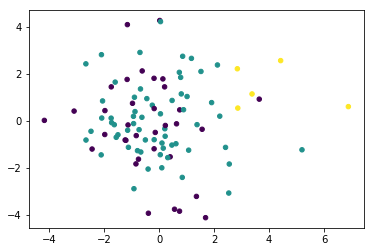

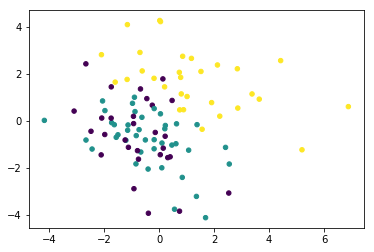

In [16]:
data_to_cluster = annotators_pca.copy() #annotators_pca
std = StandardScaler()
data_to_cluster = std.fit_transform(data_to_cluster)

kmeans = KMeans(n_clusters=3, random_state=0,init='k-means++',n_jobs=-1)
kmeans.fit(data_to_cluster)

#proyect
if scenario != 3:
    plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= groups_annot,s=20)
else:
    plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= groups_annot.argmax(axis=1),s=20)

plt.show()
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= kmeans.labels_, s=20)
plt.show()

### Red Base (real)

In [12]:
#PENDIENTES POR AGREGAR---revisar en base a experimentacion con datos simulados
# 1-BatchNormalization en todas las capas
# 2-Dropout

def bloque_convolucional(layer1,units,kernel_size,stride,activation,BN=False):
    """As a ssuper-layer = followed layers"""
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(layer1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(f1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = MaxPool2D(pool_size=stride)(f1)
    return f1
        
def create_network(Kl,input_dim,tipo,info_net,infoextractor_network=None,embedding_info=None):
    #add batch norma y dropa..
    try:
        len(input_dim)
    except:
        input_dim = (input_dim,)
    input_tensor = Input(shape=input_dim,name="data")
    #arquitectura
    if tipo == "CNN": #classic convolutional: deep-CCP
        start_unit,kernel_size,stride,deep,activation = infoextractor_network
        units = start_unit 
        f1 = bloque_convolucional(input_tensor,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        for i in range(deep-1): #profundidad
            units = units*2
            f1 = bloque_convolucional(f1,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        f1 = Flatten()(f1)
            
    elif tipo == "RNN": #recurrent 
        units,deep =infoextractor_network
        #embedding for text datasets
        if embedding_info!=None:
            input_dim,output_dim =embedding_info
            emb = Embedding(input_dim,output_dim)(input_tensor)
            f1 = CuDNNGRU(units,return_sequences=True)(emb)
        else:
            f1 = CuDNNGRU(units,return_sequences=True)(input_tensor)
        for i in range(deep-1): #profundidad
            f1 = CuDNNGRU(units,return_sequences=True)(f1)
        f1 = CuDNNGRU(units,return_sequences=False)(f1) #alias to flatten in convolutional
        #f1 = GlobalMaxPool1D()(f1)
    
    ### classify with extracted features
    units,ff_deep,ff_activation =info_net
    if tipo == "FF": #classic Feed Forward
        d1 = Dense(units,activation=ff_activation)(input_tensor) #comes from input
    else:
        d1 = Dense(units,activation=ff_activation)(f1)
    for i in range(ff_deep-1): #all the deep layers
        units = units/2
        d1 = Dense(units,activation=ff_activation)(d1)
        
    output_soft = Dense(Kl,activation='softmax',name="output_soft")(d1) #softmax to probability p(z|xi)
    
    model = Model(inputs=input_tensor,outputs=output_soft)
    model.summary()
    return model

In [13]:
### Ejemplo CNN
start_units,kernel,strides,deep,activation = 32, 3, 2, 3, 'relu'
info_cnn = [start_units,kernel,strides,deep,activation] 

start_units,deep, activation = 512 , 2, 'relu' 
info = [start_units,deep,activation]  #feed forwad info
clases = 3
dimensiones_input = [50,50,3]
a = create_network(clases,dimensiones_input,"CNN",info,info_cnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [15]:
### Ejemplo RNN
start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [5,50]
a = create_network(clases,dimensiones_input,"RNN",info,info_rnn)

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 5, 50)             0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 5, 128)            69120     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 5, 128)            99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
out

In [16]:
### Ejemplo RNN con embedding
input_dim,output_dim = 1000,64
info_embedding = [input_dim,output_dim]

start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [10] #largo
a = create_network(clases,dimensiones_input,"RNN",info,infoextractor_network=info_rnn,embedding_info=info_embedding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            64000     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 10, 128)           74496     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 10, 128)           99072     
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
__________

<a id="sindato"></a>
### Training module  1
---
Here we implement the iteration between **E** and **M** steps of our formulation with group annotations $r_{ij}$.

In [11]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.MixtureofGroups import GroupMixtureOpt

In [39]:
M_itj = set_representation(y_obs,'onehot')
mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
mask_nan2 = M_itj.sum(axis=1) == 0

mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
M_itj[mask_nan] = 1
M_itj_norm = M_itj/np.sum(M_itj,axis=1)[:,None,:]
M_itj_norm = M_itj_norm.astype(DTYPE_OP)
        
alphas_init = np.tensordot(M_itj_norm,groups_annot, axes=[[1],[0]]) 
#alphas_init[mask_nan2] = 1/alphas_init.shape[-1]
alphas_init

array([[[0.        , 0.5       , 0.5       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.33333334, 0.6666667 , 0.        ]],

       [[0.        , 0.6666667 , 0.33333334],
        [0.6       , 0.4       , 0.        ],
        [0.        , 0.6666667 , 0.33333334]],

       [[0.5       , 0.        , 0.5       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.25      , 0.5       , 0.25      ]],

       ...,

       [[0.        , 1.        , 0.        ],
        [0.21999997, 0.57      , 0.20999998],
        [0.        , 0.8333334 , 0.16666667]],

       [[0.25      , 0.625     , 0.125     ],
        [0.21999997, 0.57      , 0.20999998],
        [0.        , 1.        , 0.        ]],

       [[0.1       , 0.5       , 0.4       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.25      , 0.75      , 0.        ]]], dtype=float32)

In [60]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=0,dtype_op=DTYPE_OP) 
#gMixture.define_model("keras_shallow")
gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
#gMixture.define_model("default cnn")
gMixture.lambda_random=False

gMixture.set_alpha(alphas_c5)

gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=1,tolerance=TOL*2
                           ,relative=True)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/1
M step: done,  E step: done //  (in 1.11 sec)	logL: -25871.749	
Finished training!


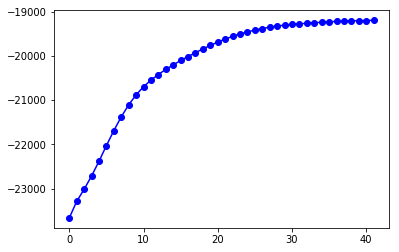

In [97]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

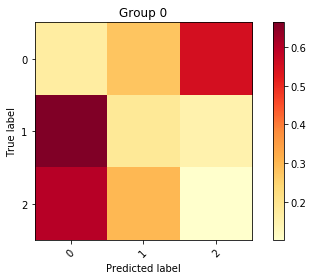

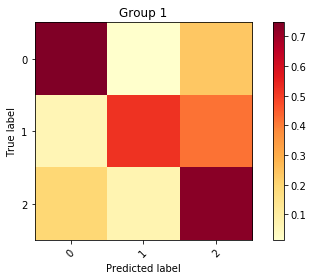

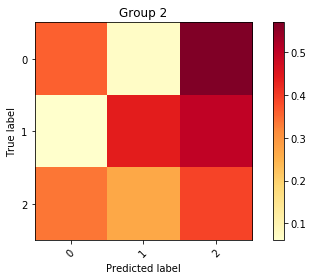

Inertia: 0.12659172527492046
A result
 ====  ========  =========  =========  ===========  =========  =============  =========
  ..    Groups       Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  =========  ===========  =========  =============  =========
   0         0  0.0668789   0.918062     0.152304   1.91645        0.321522  -0.18103
   1         1  0.583417    0.743075     0.666589   0.418815       0.80537    0.333255
   2         2  0.349704    0.946193     0.397353   0.9263         0.601097   0.06402
====  ========  =========  =========  ===========  =========  =============  =========
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.35409       0.35409
====  ======  ==========  ============


In [48]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

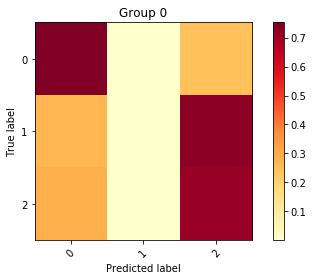

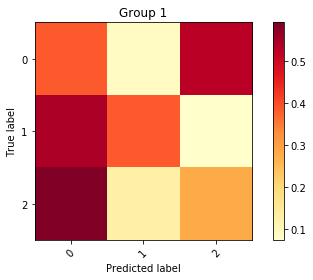

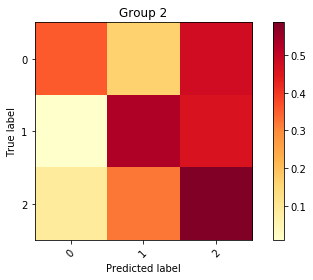

Inertia: 0.16098025565346083
A result
 ====  ========  ========  =========  ===========  =========  =============  =========
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  =========  ===========  =========  =============  =========
   0         0  0.415495   0.586713     0.489071   2.2235         0.57143   0.155738
   1         1  0.21514    0.913499     0.350059   1.06012        0.555461  0.0167254
   2         2  0.369365   0.880749     0.490813   0.734128       0.676285  0.157479
====  ========  ========  =========  ===========  =========  =============  =========
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global   0.0903541     0.0903541
====  ======  ==========  ============


In [61]:
evaluate = Evaluation_metrics(gMixture,'our1') 
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

In [27]:
GenerateData.prob_groups

array([0.25, 0.55, 0.2 ])

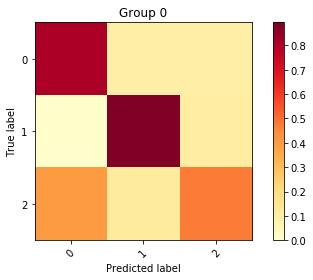

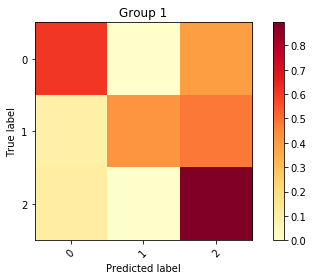

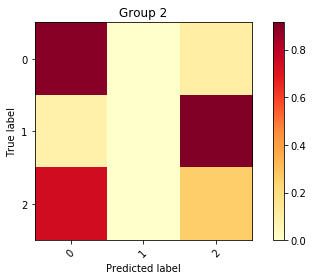

Inertia: 0.16202351067377893
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.189472   0.643653     0.72667    0.355134            0.83733
   1         1  0.588126   0.646593     0.641943   0.489447            0.779772
   2         2  0.222402   0.400478     0.384487   5.86044             0.468836
====  ========  ========  =========  ===========  =========  ==================


In [24]:
evaluate = Evaluation_metrics(gMixture,'our1') 
results = evaluate.calculate_metrics(conf_pred=real_conf_matrix)

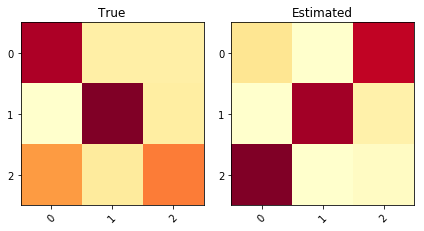

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


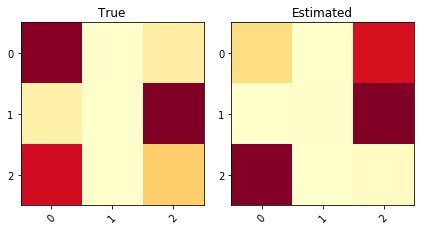

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


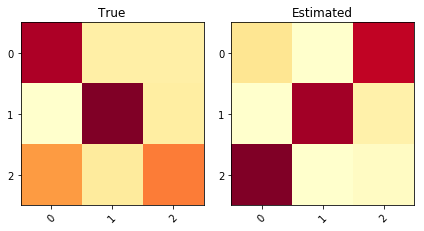

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


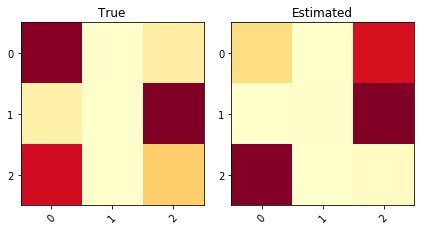

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


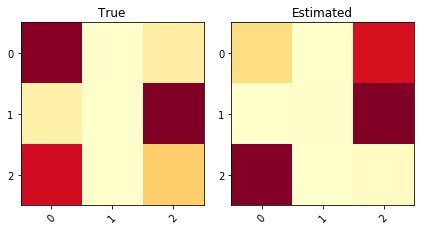

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


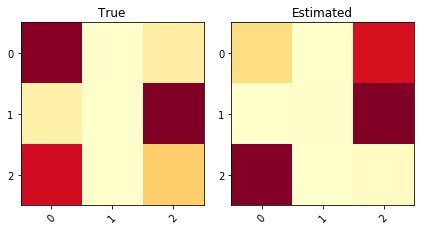

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


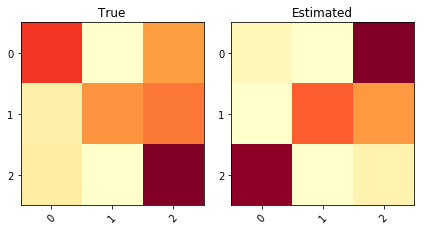

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


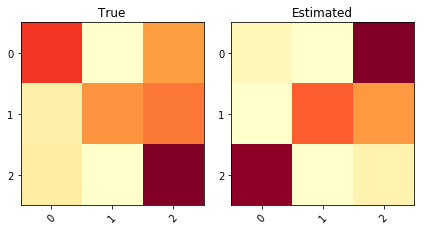

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


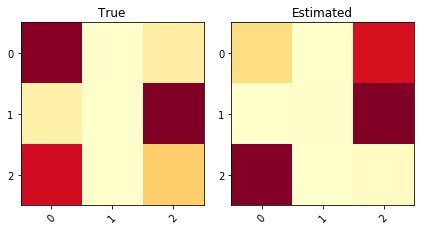

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


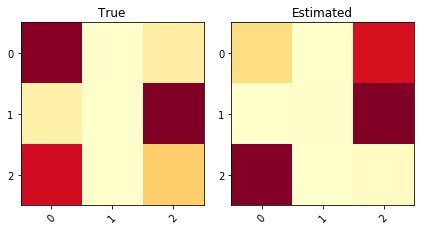

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


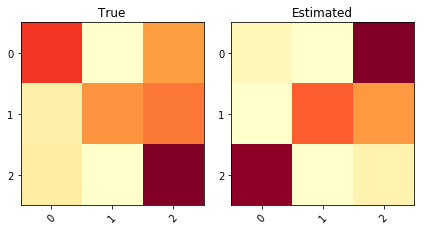

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


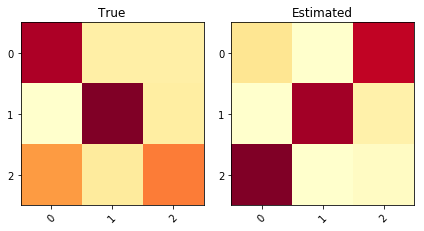

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


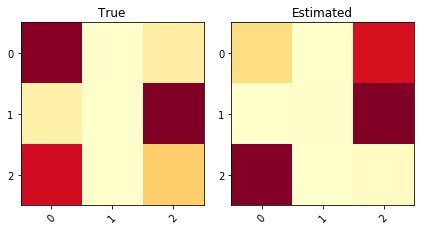

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


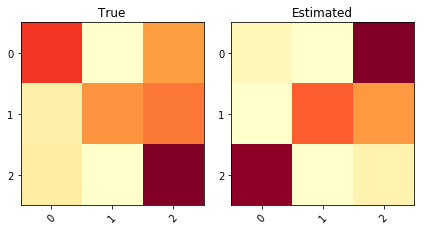

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


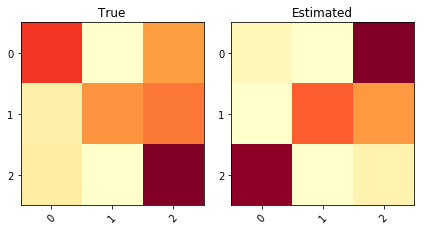

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.400488      0.400488      0.896207               0.234166
====  ======  ==========  ============  ============  =====================


In [17]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [14]:
from code.evaluation import Evaluation_metrics
from tabulate import tabulate
def get_mean_dataframes(df_values):
    if df_values[0].iloc[:,0].dtype == object:
        RT = pd.DataFrame(data=None,columns = df_values[0].columns[1:], index= df_values[0].index)
    else:
        RT = pd.DataFrame(data=None,columns = df_values[0].columns, index= df_values[0].index)
        
    data = []
    for df_value in df_values:
        if df_value.iloc[:,0].dtype == object:
            data.append( df_value.iloc[:,1:].values )
        else:
            data.append(df_value.values)
    RT[:] = np.mean(data,axis=0)
    
    if df_values[0].iloc[:,0].dtype == object:
        RT.insert(0, "", df_values[0].iloc[:,0].values )
    return RT

def run_experiment(pre_init_value):
    aux_test = []
    aux_testA = []
    aux_train = []
    for _ in range(10):
        gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=pre_init_value,dtype_op=DTYPE_OP) 
        gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
        gMixture.lambda_random=False
        gMixture.set_alpha(alphas_clusterized1)
        gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
        logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,relative=True)
        evaluate = Evaluation_metrics(gMixture,'our1',plot=False) 
        c_M = gMixture.get_confusionM()
        Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
        results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)
        aux_test.append(results[1])
        aux_testA.append(results[0])

        aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

        #Usuall train
        Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
        results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
        aux_train += results
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=pre_init_value,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    logL_hists,i = gMixture.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                       ,cluster=True,bulk_annotators=[y_obs,annotators_pca])
    print("**********************************MULTIPLES RUNS**********************************")
    evaluate = Evaluation_metrics(gMixture,'our1',plot=True) 
    c_M = gMixture.get_confusionM()
    Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
    results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

    aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
    predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

    #Usuall train
    Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
    results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
    
    print("**********************************Average Normal**********************************")
    print("A result\n",tabulate(get_mean_dataframes(aux_testA), headers='keys', tablefmt='rst'))
    print("A result\n",tabulate(get_mean_dataframes(aux_test), headers='keys', tablefmt='rst'))
    print("A result\n",tabulate(get_mean_dataframes(aux_train), headers='keys', tablefmt='rst'))

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.21 sec)	logL: -24947.248	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24347.524	Tol1: 0.02404	Tol2: 0.22948	Tol3: 0.01297	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23871.028	Tol1: 0.01957	Tol2: 0.16716	Tol3: 0.00513	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23401.530	Tol1: 0.01967	Tol2: 0.14905	Tol3: 0.00239	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22928.640	Tol1: 0.02021	Tol2: 0.14212	Tol3: 0.00308	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22449.100	Tol1: 0.02091	Tol2: 0.13703	Tol3: 0.00433	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21997.239	Tol1: 0.02013	Tol2: 0.13144	Tol3: 0.00571	
Iter 8/50
M step: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -19994.520	Tol1: 0.00085	Tol2: 0.02701	Tol3: 0.00275	
Iter 29/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19978.249	Tol1: 0.00081	Tol2: 0.02902	Tol3: 0.00348	
Iter 30/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19965.565	Tol1: 0.00063	Tol2: 0.02643	Tol3: 0.00328	
Iter 31/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19953.132	Tol1: 0.00062	Tol2: 0.02426	Tol3: 0.00283	
Iter 32/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19935.037	Tol1: 0.00091	Tol2: 0.02663	Tol3: 0.00313	
Iter 33/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19922.504	Tol1: 0.00063	Tol2: 0.02860	Tol3: 0.00326	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19910.417	Tol1: 0.00061	Tol2: 0.02543	Tol3: 0.00347	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19898.313	Tol1: 0.00061	Tol2: 0.02626	Tol3: 0.00342	
Iter 36/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19891.633	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -25288.589	Tol1: 0.00602	Tol2: 0.07014	Tol3: 0.00258	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25142.411	Tol1: 0.00578	Tol2: 0.05746	Tol3: 0.00231	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24997.523	Tol1: 0.00576	Tol2: 0.04909	Tol3: 0.00218	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24856.563	Tol1: 0.00564	Tol2: 0.04429	Tol3: 0.00248	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24719.119	Tol1: 0.00553	Tol2: 0.04247	Tol3: 0.00283	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24581.176	Tol1: 0.00558	Tol2: 0.04139	Tol3: 0.00289	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24443.444	Tol1: 0.00560	Tol2: 0.04445	Tol3: 0.00298	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24304.316	Tol1: 0.00569	Tol2: 0.04744	Tol3: 0.00320	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24164.034	Tol1:

M step: done,  E step: done //  (in 0.16 sec)	logL: -20732.683	Tol1: 0.00609	Tol2: 0.05682	Tol3: 0.00080	
Iter 17/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20621.982	Tol1: 0.00534	Tol2: 0.04526	Tol3: 0.00097	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20525.969	Tol1: 0.00466	Tol2: 0.03654	Tol3: 0.00069	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20443.068	Tol1: 0.00404	Tol2: 0.02923	Tol3: 0.00099	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20375.719	Tol1: 0.00329	Tol2: 0.02471	Tol3: 0.00096	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20317.004	Tol1: 0.00288	Tol2: 0.02448	Tol3: 0.00041	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20271.557	Tol1: 0.00224	Tol2: 0.02412	Tol3: 0.00078	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20231.006	Tol1: 0.00200	Tol2: 0.02583	Tol3: 0.00068	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20200.022	T

M step: done,  E step: done //  (in 10.01 sec)	logL: -23692.505	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23203.799	Tol1: 0.02063	Tol2: 0.21931	Tol3: 0.01062	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22757.079	Tol1: 0.01925	Tol2: 0.17583	Tol3: 0.00559	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22325.034	Tol1: 0.01899	Tol2: 0.15999	Tol3: 0.00680	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21927.355	Tol1: 0.01781	Tol2: 0.15075	Tol3: 0.00692	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21573.786	Tol1: 0.01612	Tol2: 0.14135	Tol3: 0.00633	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21270.906	Tol1: 0.01404	Tol2: 0.13137	Tol3: 0.00651	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21006.048	Tol1: 0.01245	Tol2: 0.11771	Tol3: 0.00600	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20793.993	Tol1: 0.01009	Tol2: 0.10151	Tol3: 0.00516	
Iter 10

M step: done,  E step: done //  (in 0.13 sec)	logL: -22718.751	Tol1: 0.01667	Tol2: 0.10862	Tol3: 0.00098	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22377.834	Tol1: 0.01501	Tol2: 0.11010	Tol3: 0.00141	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22082.325	Tol1: 0.01321	Tol2: 0.10744	Tol3: 0.00200	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21828.443	Tol1: 0.01150	Tol2: 0.10054	Tol3: 0.00247	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21617.221	Tol1: 0.00968	Tol2: 0.09139	Tol3: 0.00312	
Iter 14/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21437.823	Tol1: 0.00830	Tol2: 0.08075	Tol3: 0.00348	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21273.994	Tol1: 0.00764	Tol2: 0.07118	Tol3: 0.00383	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21126.484	Tol1: 0.00693	Tol2: 0.06350	Tol3: 0.00402	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20990.089	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20310.780	Tol1: 0.00221	Tol2: 0.03326	Tol3: 0.00169	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20267.393	Tol1: 0.00214	Tol2: 0.03013	Tol3: 0.00181	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20228.837	Tol1: 0.00190	Tol2: 0.02807	Tol3: 0.00179	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20192.316	Tol1: 0.00181	Tol2: 0.02567	Tol3: 0.00192	
Iter 33/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20163.798	Tol1: 0.00141	Tol2: 0.02367	Tol3: 0.00175	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20136.198	Tol1: 0.00137	Tol2: 0.02176	Tol3: 0.00186	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20111.547	Tol1: 0.00122	Tol2: 0.02056	Tol3: 0.00192	
Iter 36/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20091.256	Tol1: 0.00101	Tol2: 0.01934	Tol3: 0.00189	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.14 sec)	logL: -20241.246	Tol1: 0.00160	Tol2: 0.02807	Tol3: 0.00161	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20215.436	Tol1: 0.00128	Tol2: 0.02961	Tol3: 0.00136	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20191.085	Tol1: 0.00120	Tol2: 0.03000	Tol3: 0.00149	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20175.734	Tol1: 0.00076	Tol2: 0.02961	Tol3: 0.00145	
Iter 33/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20154.066	Tol1: 0.00107	Tol2: 0.02948	Tol3: 0.00131	
Iter 34/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20132.701	Tol1: 0.00106	Tol2: 0.03008	Tol3: 0.00069	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20112.143	Tol1: 0.00102	Tol2: 0.03146	Tol3: 0.00079	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20094.272	Tol1: 0.00089	Tol2: 0.03216	Tol3: 0.00119	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20077.860	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -24416.516	Tol1: 0.01010	Tol2: 0.07352	Tol3: 0.00045	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24129.567	Tol1: 0.01175	Tol2: 0.07360	Tol3: 0.00045	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23807.450	Tol1: 0.01335	Tol2: 0.07643	Tol3: 0.00055	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23471.451	Tol1: 0.01411	Tol2: 0.08302	Tol3: 0.00070	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23128.147	Tol1: 0.01463	Tol2: 0.08853	Tol3: 0.00071	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22791.511	Tol1: 0.01456	Tol2: 0.09389	Tol3: 0.00104	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22480.603	Tol1: 0.01364	Tol2: 0.09640	Tol3: 0.00182	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22201.112	Tol1: 0.01243	Tol2: 0.09666	Tol3: 0.00310	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21950.066	Tol1:

M step: done,  E step: done //  (in 0.17 sec)	logL: -24907.032	Tol1: 0.02998	Tol2: 0.19140	Tol3: 0.01109	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24256.592	Tol1: 0.02611	Tol2: 0.14811	Tol3: 0.00969	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23670.997	Tol1: 0.02414	Tol2: 0.12640	Tol3: 0.00944	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23121.968	Tol1: 0.02319	Tol2: 0.11511	Tol3: 0.00826	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22637.364	Tol1: 0.02096	Tol2: 0.10872	Tol3: 0.00684	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22227.517	Tol1: 0.01810	Tol2: 0.10664	Tol3: 0.00551	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21917.950	Tol1: 0.01393	Tol2: 0.10322	Tol3: 0.00420	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21697.134	Tol1: 0.01007	Tol2: 0.09652	Tol3: 0.00337	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21542.963	Tol1: 0

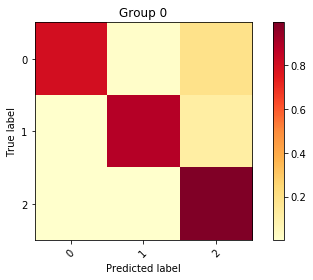

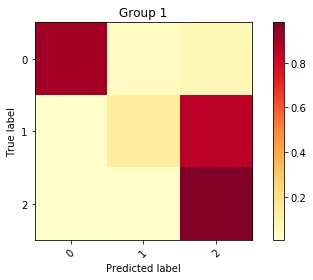

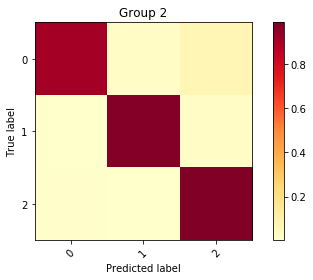

Inertia: 0.09038775088265538
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.531394   0.319756     0.891463  0.11895              0.942105
   1         1  0.155205   0.302014     0.672257  0.71769              0.744472
   2         2  0.313401   0.182315     0.958286  0.0431727            0.978625
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.904762      0.904762
====  ======  ==========  ============


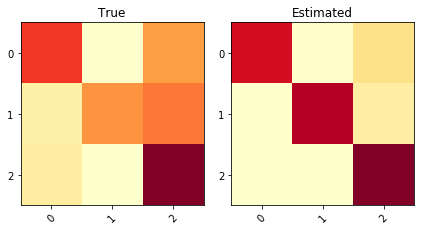

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


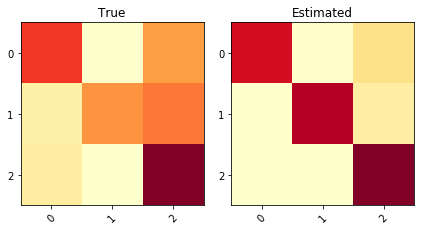

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


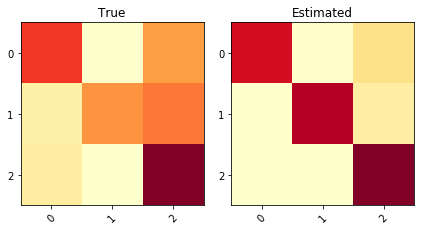

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


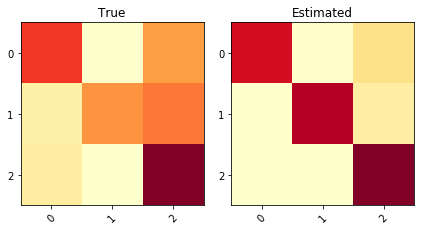

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


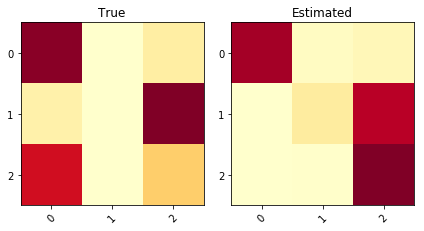

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


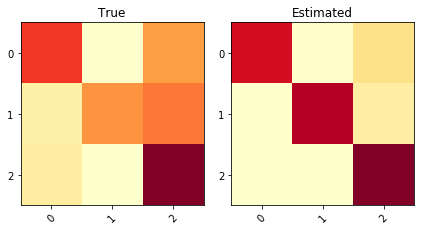

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


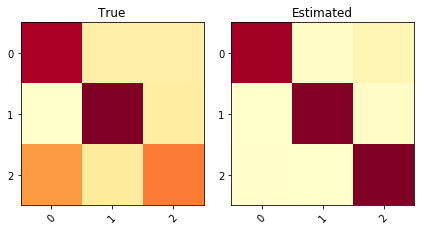

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


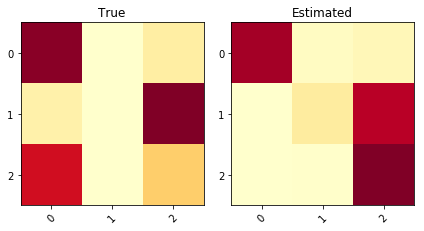

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


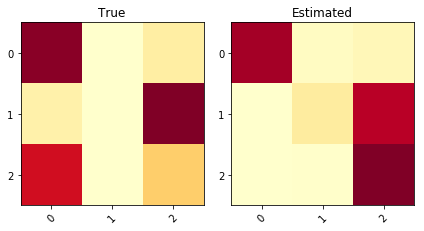

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


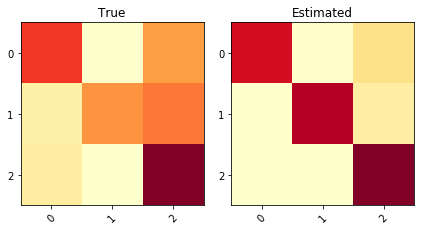

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


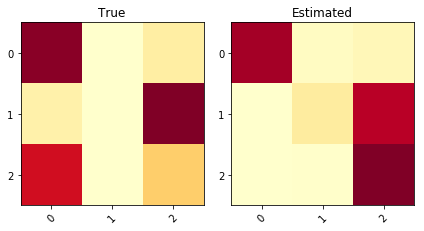

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


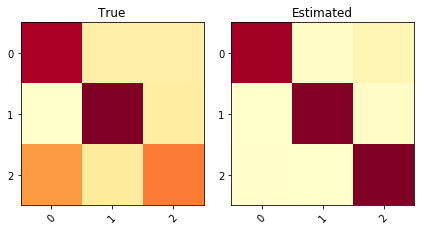

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


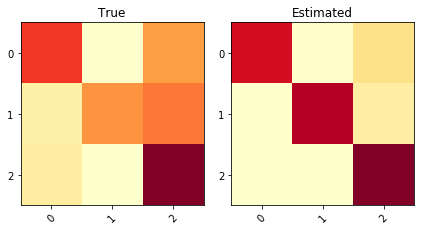

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


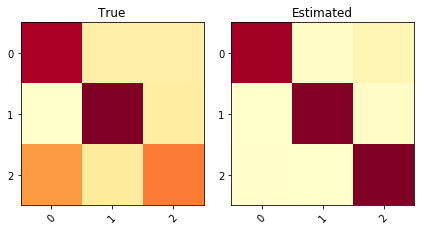

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


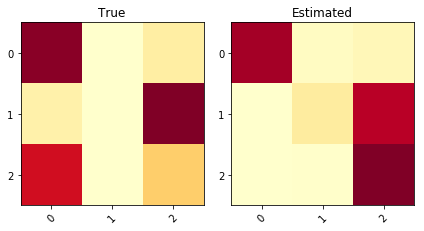

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.895808      0.895808         0.601               0.328088
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.520156   0.402706     0.734198   0.768079            0.807866
   1         1  0.183374   0.302159     0.610063   1.22721             0.669592
   2         2  0.29647    0.275537     0.801024 

In [19]:
#con pre-entrenar 0
run_experiment(0) #funca bien con multiples runs (deja explorar mejor) -- escoje el peor con un bad MV

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.19 sec)	logL: -25369.074	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25024.044	Tol1: 0.01360	Tol2: 0.15578	Tol3: 0.02598	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24784.224	Tol1: 0.00958	Tol2: 0.08865	Tol3: 0.00301	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24489.580	Tol1: 0.01189	Tol2: 0.08265	Tol3: 0.00517	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24129.274	Tol1: 0.01471	Tol2: 0.08693	Tol3: 0.00672	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23701.072	Tol1: 0.01775	Tol2: 0.09491	Tol3: 0.00742	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23220.884	Tol1: 0.02026	Tol2: 0.10750	Tol3: 0.00772	
Iter 8/50
M step:

M step: done,  E step: done //  (in 0.15 sec)	logL: -19969.948	Tol1: 0.00039	Tol2: 0.02577	Tol3: 0.00192	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19960.031	Tol1: 0.00050	Tol2: 0.02511	Tol3: 0.00252	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19956.487	Tol1: 0.00018	Tol2: 0.02366	Tol3: 0.00190	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19951.946	Tol1: 0.00023	Tol2: 0.02167	Tol3: 0.00151	
Iter 38/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19945.052	Tol1: 0.00035	Tol2: 0.02179	Tol3: 0.00217	
Iter 39/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19938.950	Tol1: 0.00031	Tol2: 0.02107	Tol3: 0.00234	
Iter 40/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19939.147	Tol1: 0.00001	Tol2: 0.01966	Tol3: 0.00197	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  

M step: done,  E step: done //  (in 0.16 sec)	logL: -20654.965	Tol1: 0.00524	Tol2: 0.05992	Tol3: 0.00630	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20560.035	Tol1: 0.00460	Tol2: 0.06274	Tol3: 0.00605	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20474.967	Tol1: 0.00414	Tol2: 0.06383	Tol3: 0.00615	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20393.822	Tol1: 0.00396	Tol2: 0.06336	Tol3: 0.00582	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20322.361	Tol1: 0.00350	Tol2: 0.06214	Tol3: 0.00555	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20264.353	Tol1: 0.00285	Tol2: 0.06009	Tol3: 0.00538	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20212.165	Tol1: 0.00258	Tol2: 0.05608	Tol3: 0.00500	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20169.606	Tol1: 0.00211	Tol2: 0.05270	Tol3: 0.00472	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20132.568	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -24570.338	Tol1: 0.00826	Tol2: 0.05908	Tol3: 0.00247	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24359.010	Tol1: 0.00860	Tol2: 0.05791	Tol3: 0.00216	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24131.600	Tol1: 0.00934	Tol2: 0.06118	Tol3: 0.00232	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23887.695	Tol1: 0.01011	Tol2: 0.06844	Tol3: 0.00239	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23630.080	Tol1: 0.01078	Tol2: 0.07540	Tol3: 0.00226	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23348.594	Tol1: 0.01191	Tol2: 0.08202	Tol3: 0.00273	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23065.425	Tol1: 0.01213	Tol2: 0.08805	Tol3: 0.00291	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22769.361	Tol1: 0.01284	Tol2: 0.09235	Tol3: 0.00294	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22478.503	Tol

M step: done,  E step: done //  (in 0.19 sec)	logL: -26203.669	Tol1: 0.03637	Tol2: 0.29928	Tol3: 0.06947	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25944.927	Tol1: 0.00987	Tol2: 0.13361	Tol3: 0.01370	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25758.591	Tol1: 0.00718	Tol2: 0.11111	Tol3: 0.00468	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25593.346	Tol1: 0.00642	Tol2: 0.09004	Tol3: 0.00334	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25427.468	Tol1: 0.00648	Tol2: 0.07620	Tol3: 0.00346	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25246.441	Tol1: 0.00712	Tol2: 0.06809	Tol3: 0.00383	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25037.422	Tol1: 0.00828	Tol2: 0.06336	Tol3: 0.00428	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24785.244	Tol1: 0.01007	Tol2: 0.06661	Tol3: 0.00495	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24470.902	Tol1: 0.

M step: done,  E step: done //  (in 0.17 sec)	logL: -23784.434	Tol1: 0.01513	Tol2: 0.12920	Tol3: 0.00301	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23411.633	Tol1: 0.01567	Tol2: 0.11626	Tol3: 0.00280	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23037.398	Tol1: 0.01598	Tol2: 0.11202	Tol3: 0.00255	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22686.408	Tol1: 0.01524	Tol2: 0.11127	Tol3: 0.00248	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22374.992	Tol1: 0.01373	Tol2: 0.10977	Tol3: 0.00225	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22120.155	Tol1: 0.01139	Tol2: 0.10558	Tol3: 0.00203	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21907.759	Tol1: 0.00960	Tol2: 0.09814	Tol3: 0.00149	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21745.161	Tol1: 0.00742	Tol2: 0.08786	Tol3: 0.00123	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21619.972	Tol1: 0

M step: done,  E step: done //  (in 0.20 sec)	logL: -20246.707	Tol1: 0.00447	Tol2: 0.04516	Tol3: 0.00525	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20169.482	Tol1: 0.00381	Tol2: 0.04468	Tol3: 0.00491	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20108.477	Tol1: 0.00302	Tol2: 0.04385	Tol3: 0.00449	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20064.670	Tol1: 0.00218	Tol2: 0.03920	Tol3: 0.00380	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20028.923	Tol1: 0.00178	Tol2: 0.03714	Tol3: 0.00349	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20001.455	Tol1: 0.00137	Tol2: 0.03592	Tol3: 0.00277	
Iter 30/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19984.824	Tol1: 0.00083	Tol2: 0.03374	Tol3: 0.00185	
Iter 31/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19967.152	Tol1: 0.00088	Tol2: 0.03453	Tol3: 0.00278	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19957.503	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -23187.070	Tol1: 0.01540	Tol2: 0.11393	Tol3: 0.00481	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22798.239	Tol1: 0.01677	Tol2: 0.11917	Tol3: 0.00546	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22388.331	Tol1: 0.01798	Tol2: 0.12298	Tol3: 0.00642	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21986.730	Tol1: 0.01794	Tol2: 0.12378	Tol3: 0.00692	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21613.108	Tol1: 0.01699	Tol2: 0.12065	Tol3: 0.00733	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21296.438	Tol1: 0.01465	Tol2: 0.11277	Tol3: 0.00720	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21023.177	Tol1: 0.01283	Tol2: 0.10251	Tol3: 0.00698	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20808.420	Tol1: 0.01022	Tol2: 0.08905	Tol3: 0.00596	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20641.409	Tol1

M step: done,  E step: done //  (in 0.16 sec)	logL: -20593.301	Tol1: 0.00310	Tol2: 0.02460	Tol3: 0.00026	
Iter 18/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20539.980	Tol1: 0.00259	Tol2: 0.02165	Tol3: 0.00072	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20484.120	Tol1: 0.00272	Tol2: 0.01960	Tol3: 0.00110	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.51 sec)	logL: -26638.971	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25885.647	Tol1: 0.02828	Tol2: 0.26041	Tol3: 0.03626	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25450.252	Tol1: 0.01682	Tol2: 0.17119	Tol3: 0.01090	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25104.292	Tol1: 0.01359	Tol2: 0.13902	Tol3: 0.00889	
Iter 5/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.17 sec)	logL: -20205.936	Tol1: 0.00188	Tol2: 0.04254	Tol3: 0.00311	
Iter 37/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20178.747	Tol1: 0.00135	Tol2: 0.03933	Tol3: 0.00324	
Iter 38/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20153.447	Tol1: 0.00125	Tol2: 0.03577	Tol3: 0.00301	
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20126.227	Tol1: 0.00135	Tol2: 0.03309	Tol3: 0.00346	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20095.706	Tol1: 0.00152	Tol2: 0.03005	Tol3: 0.00325	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20070.265	Tol1: 0.00127	Tol2: 0.02754	Tol3: 0.00323	
Iter 42/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20048.334	Tol1: 0.00109	Tol2: 0.02500	Tol3: 0.00322	
Iter 43/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20032.313	Tol1: 0.00080	Tol2: 0.02239	Tol3: 0.00271	
Iter 44/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20015.631	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -19996.398	Tol1: 0.00086	Tol2: 0.02294	Tol3: 0.00143	
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19981.455	Tol1: 0.00075	Tol2: 0.02250	Tol3: 0.00118	
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19969.723	Tol1: 0.00059	Tol2: 0.02230	Tol3: 0.00136	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19960.252	Tol1: 0.00047	Tol2: 0.02089	Tol3: 0.00068	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19946.166	Tol1: 0.00071	Tol2: 0.02042	Tol3: 0.00123	
Iter 42/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19937.382	Tol1: 0.00044	Tol2: 0.02091	Tol3: 0.00115	
Iter 43/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19932.962	Tol1: 0.00022	Tol2: 0.01914	Tol3: 0.00049	
Finished training!
**********************************MULTIPLES RUNS**********************************


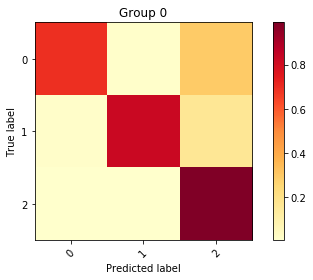

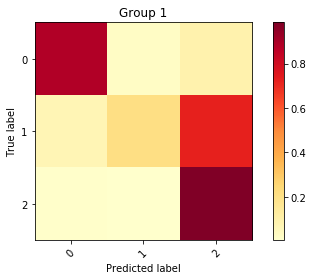

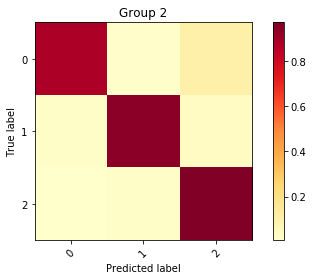

Inertia: 0.0704279625788331
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.533927   0.408676     0.837077  0.188519             0.909823
   1         1  0.177578   0.417015     0.69248   0.569308             0.777471
   2         2  0.288496   0.270643     0.932194  0.0710499            0.96495
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.813187      0.813187
====  ======  ==========  ============


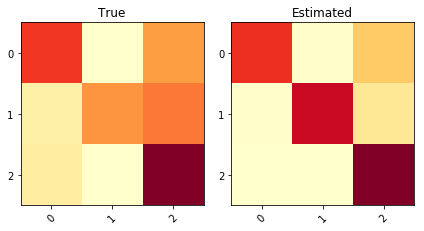

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


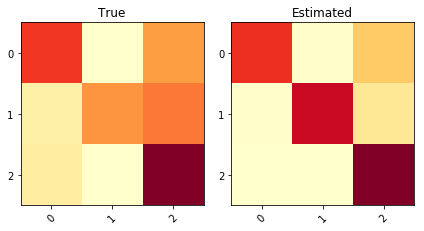

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


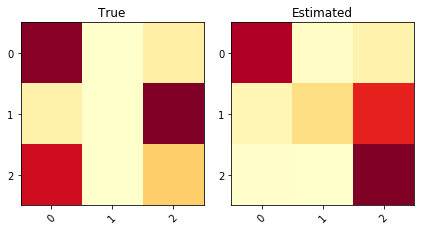

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


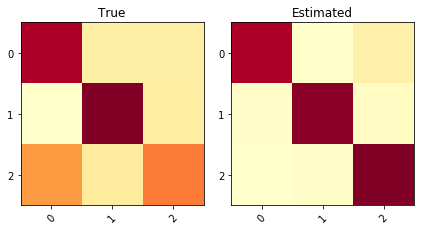

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


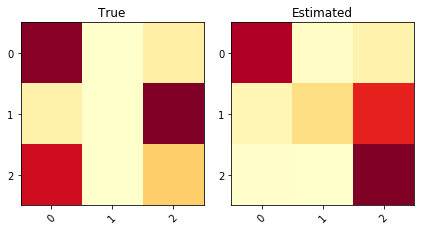

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


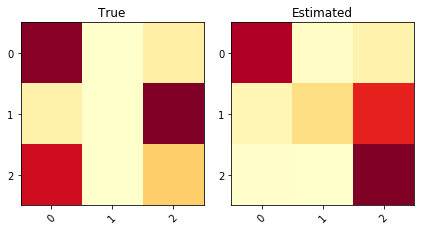

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


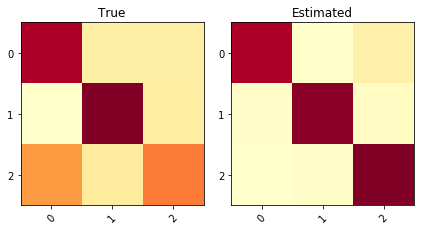

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


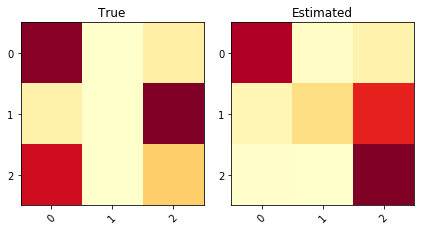

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


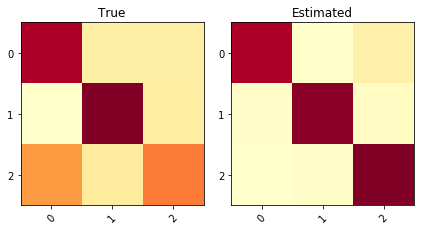

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


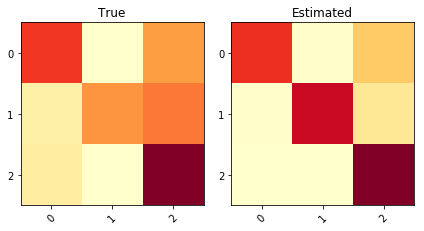

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


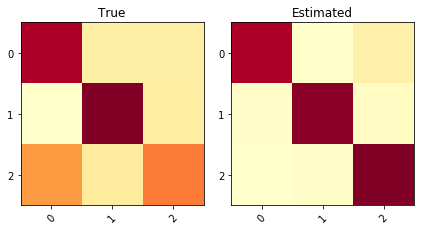

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


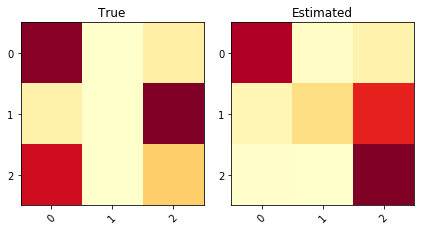

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


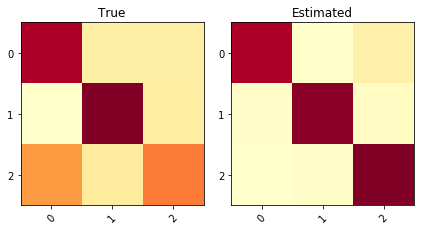

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


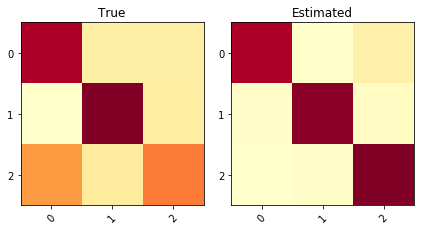

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


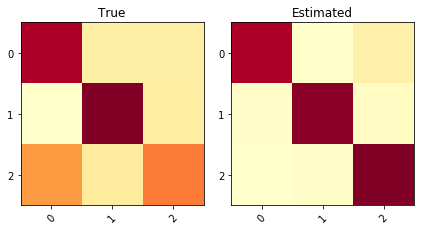

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.800163      0.800163      0.499979               0.298458
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.520388   0.416704     0.76526    0.638699            0.838222
   1         1  0.181608   0.316919     0.643385   1.10452             0.701371
   2         2  0.298004   0.295113     0.817652

In [20]:
#con pre-entrenar 1
run_experiment(1) #escoje el peor con un bad MV-- escoge bien en multiples runs

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 13.52 sec)	logL: -23978.464	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23540.115	Tol1: 0.01828	Tol2: 0.19418	Tol3: 0.00884	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23151.531	Tol1: 0.01651	Tol2: 0.16373	Tol3: 0.00442	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22769.132	Tol1: 0.01652	Tol2: 0.14960	Tol3: 0.00600	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22401.836	Tol1: 0.01613	Tol2: 0.14217	Tol3: 0.00654	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22055.937	Tol1: 0.01544	Tol2: 0.13588	Tol3: 0.00620	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21743.598	Tol1: 0.01416	Tol2: 0.13028	Tol3: 0.00609	
Iter 8/50
M step:

M step: done,  E step: done //  (in 0.17 sec)	logL: -20096.081	Tol1: 0.00051	Tol2: 0.04648	Tol3: 0.00201	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20082.867	Tol1: 0.00066	Tol2: 0.04324	Tol3: 0.00167	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20069.154	Tol1: 0.00068	Tol2: 0.04235	Tol3: 0.00240	
Iter 25/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20060.502	Tol1: 0.00043	Tol2: 0.04026	Tol3: 0.00221	
Iter 26/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20053.407	Tol1: 0.00035	Tol2: 0.03710	Tol3: 0.00216	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20043.329	Tol1: 0.00050	Tol2: 0.03535	Tol3: 0.00206	
Iter 28/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20038.924	Tol1: 0.00022	Tol2: 0.03407	Tol3: 0.00247	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20031.928	Tol1: 0.00035	Tol2: 0.03144	Tol3: 0.00253	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20028.801	T

M step: done,  E step: done //  (in 0.26 sec)	logL: -20404.433	Tol1: 0.00455	Tol2: 0.04794	Tol3: 0.00189	
Iter 17/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20331.600	Tol1: 0.00357	Tol2: 0.04608	Tol3: 0.00147	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20271.073	Tol1: 0.00298	Tol2: 0.04728	Tol3: 0.00158	
Iter 19/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20219.112	Tol1: 0.00256	Tol2: 0.04759	Tol3: 0.00107	
Iter 20/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20174.608	Tol1: 0.00220	Tol2: 0.04756	Tol3: 0.00153	
Iter 21/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20140.778	Tol1: 0.00168	Tol2: 0.04670	Tol3: 0.00139	
Iter 22/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20113.550	Tol1: 0.00135	Tol2: 0.04451	Tol3: 0.00129	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20090.146	Tol1: 0.00116	Tol2: 0.04227	Tol3: 0.00068	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20073.161	T

Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 14.04 sec)	logL: -25573.488	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25088.909	Tol1: 0.01895	Tol2: 0.20012	Tol3: 0.04158	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24791.258	Tol1: 0.01186	Tol2: 0.11051	Tol3: 0.00841	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24468.345	Tol1: 0.01303	Tol2: 0.08728	Tol3: 0.00316	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24108.677	Tol1: 0.01470	Tol2: 0.08333	Tol3: 0.00162	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23703.824	Tol1: 0.01679	Tol2: 0.08860	Tol3: 0.00074	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23284.987	Tol1: 0.01767	Tol2: 0.09794	Tol3: 0.00088	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22872.505	Tol1: 0

M step: done,  E step: done //  (in 0.17 sec)	logL: -20357.343	Tol1: 0.00409	Tol2: 0.05485	Tol3: 0.00418	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20286.111	Tol1: 0.00350	Tol2: 0.05642	Tol3: 0.00379	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20235.968	Tol1: 0.00247	Tol2: 0.05779	Tol3: 0.00336	
Iter 22/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20191.304	Tol1: 0.00221	Tol2: 0.05756	Tol3: 0.00305	
Iter 23/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20153.798	Tol1: 0.00186	Tol2: 0.05547	Tol3: 0.00289	
Iter 24/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20117.401	Tol1: 0.00181	Tol2: 0.05281	Tol3: 0.00273	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20083.383	Tol1: 0.00169	Tol2: 0.05082	Tol3: 0.00307	
Iter 26/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20057.383	Tol1: 0.00129	Tol2: 0.04690	Tol3: 0.00256	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20036.511	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -23562.403	Tol1: 0.01709	Tol2: 0.09747	Tol3: 0.00178	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23127.330	Tol1: 0.01846	Tol2: 0.10369	Tol3: 0.00156	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22695.728	Tol1: 0.01866	Tol2: 0.11080	Tol3: 0.00150	
Iter 8/50
M step: done,  E step: done //  (in 0.42 sec)	logL: -22289.551	Tol1: 0.01790	Tol2: 0.11476	Tol3: 0.00149	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21907.359	Tol1: 0.01715	Tol2: 0.11431	Tol3: 0.00157	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21579.789	Tol1: 0.01495	Tol2: 0.11019	Tol3: 0.00164	
Iter 11/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21308.227	Tol1: 0.01258	Tol2: 0.10091	Tol3: 0.00171	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21090.212	Tol1: 0.01023	Tol2: 0.08790	Tol3: 0.00170	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20925.364	Tol1:

M step: done,  E step: done //  (in 0.17 sec)	logL: -20004.903	Tol1: 0.00058	Tol2: 0.03033	Tol3: 0.00314	
Iter 31/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19996.604	Tol1: 0.00041	Tol2: 0.02918	Tol3: 0.00396	
Iter 32/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19992.138	Tol1: 0.00022	Tol2: 0.02639	Tol3: 0.00321	
Iter 33/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19983.588	Tol1: 0.00043	Tol2: 0.02517	Tol3: 0.00324	
Iter 34/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19977.123	Tol1: 0.00032	Tol2: 0.02281	Tol3: 0.00245	
Iter 35/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19973.422	Tol1: 0.00019	Tol2: 0.02215	Tol3: 0.00195	
Iter 36/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19969.630	Tol1: 0.00019	Tol2: 0.02138	Tol3: 0.00198	
Iter 37/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19963.299	Tol1: 0.00032	Tol2: 0.02217	Tol3: 0.00304	
Iter 38/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19951.931	T

M step: done,  E step: done //  (in 0.19 sec)	logL: -19924.196	Tol1: 0.00034	Tol2: 0.02704	Tol3: 0.00031	
Iter 34/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19920.923	Tol1: 0.00016	Tol2: 0.02522	Tol3: 0.00043	
Iter 35/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19920.540	Tol1: 0.00002	Tol2: 0.02232	Tol3: 0.00034	
Iter 36/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19918.606	Tol1: 0.00010	Tol2: 0.02092	Tol3: 0.00028	
Iter 37/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19915.935	Tol1: 0.00013	Tol2: 0.01970	Tol3: 0.00065	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 17.05 sec)	logL: -23416.086	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22879.423	Tol1: 0.02292	Tol2: 0.21589	Tol3: 0.01347	
Iter 3/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.17 sec)	logL: -20120.570	Tol1: 0.00135	Tol2: 0.03560	Tol3: 0.00191	
Iter 20/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20100.806	Tol1: 0.00098	Tol2: 0.03536	Tol3: 0.00275	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20079.289	Tol1: 0.00107	Tol2: 0.03448	Tol3: 0.00332	
Iter 22/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20066.843	Tol1: 0.00062	Tol2: 0.03360	Tol3: 0.00359	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20056.029	Tol1: 0.00054	Tol2: 0.03242	Tol3: 0.00494	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20040.214	Tol1: 0.00079	Tol2: 0.03166	Tol3: 0.00409	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20027.835	Tol1: 0.00062	Tol2: 0.02948	Tol3: 0.00365	
Iter 26/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20016.199	Tol1: 0.00058	Tol2: 0.02874	Tol3: 0.00389	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20009.008	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -20297.929	Tol1: 0.00289	Tol2: 0.04108	Tol3: 0.00433	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20254.487	Tol1: 0.00214	Tol2: 0.03869	Tol3: 0.00433	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20220.091	Tol1: 0.00170	Tol2: 0.03622	Tol3: 0.00431	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20186.398	Tol1: 0.00167	Tol2: 0.03467	Tol3: 0.00487	
Iter 20/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20152.778	Tol1: 0.00167	Tol2: 0.03315	Tol3: 0.00424	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20128.731	Tol1: 0.00119	Tol2: 0.03314	Tol3: 0.00381	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20107.154	Tol1: 0.00107	Tol2: 0.03275	Tol3: 0.00419	
Iter 23/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20085.981	Tol1: 0.00105	Tol2: 0.03024	Tol3: 0.00425	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20071.831	T

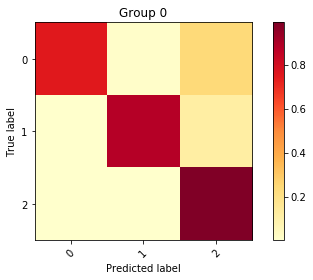

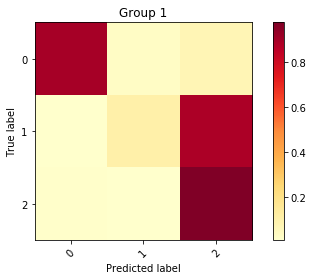

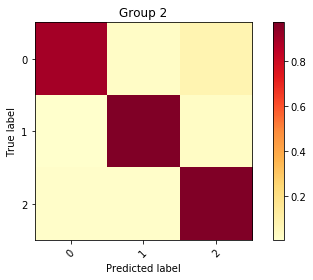

Inertia: 0.09854878578335047
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.538675   0.344538     0.874593  0.140489             0.932098
   1         1  0.163136   0.293304     0.660476  0.800262             0.728018
   2         2  0.298189   0.216458     0.94904   0.0529356            0.973819
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.888889      0.888889
====  ======  ==========  ============


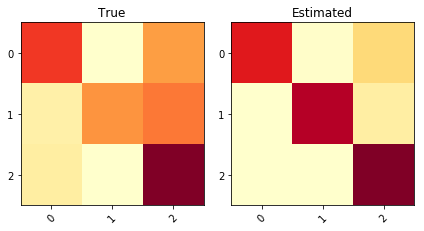

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


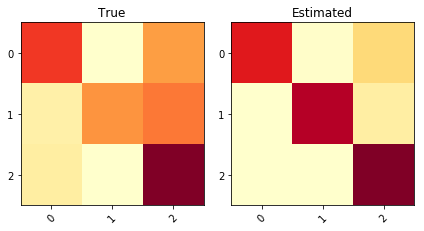

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


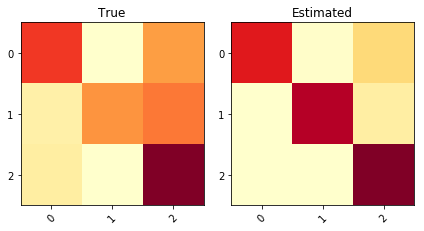

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


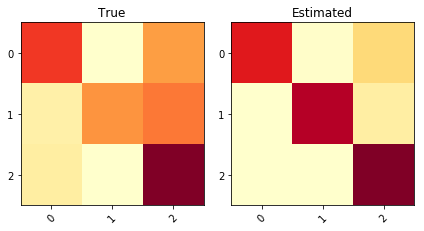

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


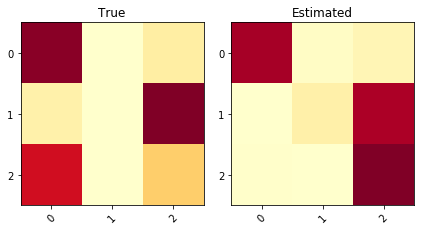

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


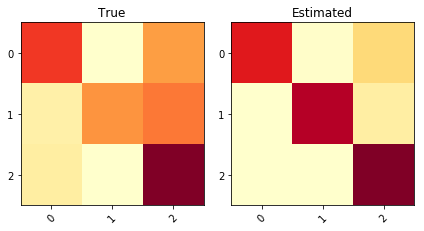

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


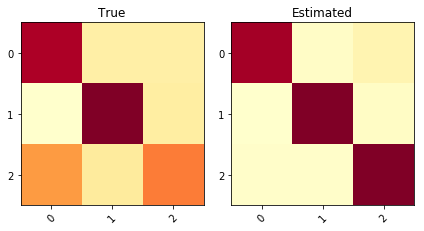

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


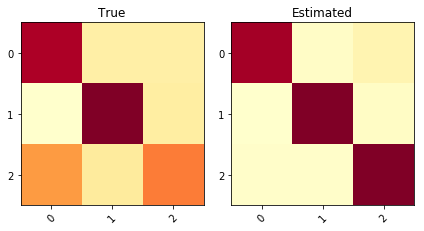

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


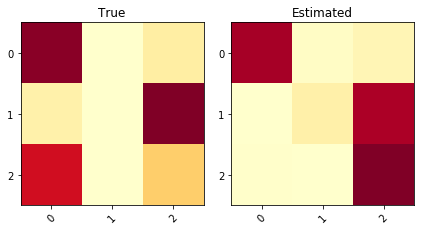

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


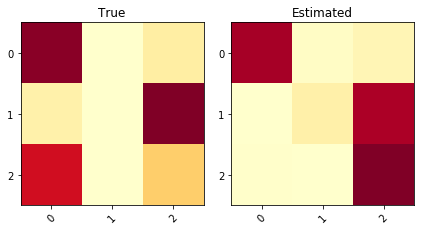

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


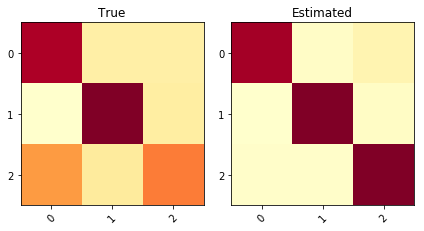

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


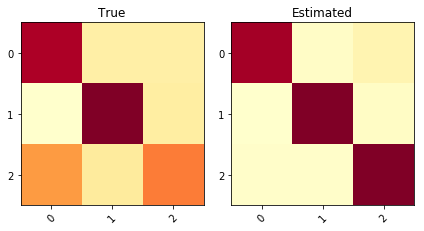

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


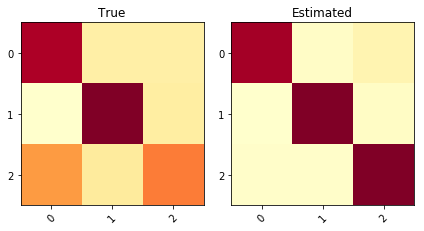

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


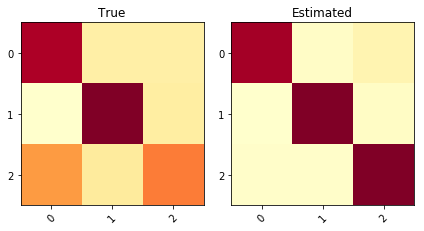

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


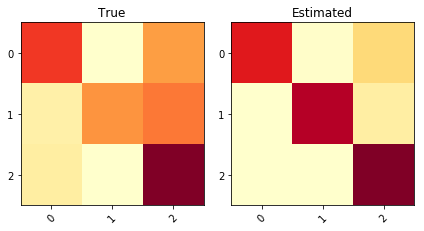

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.883598      0.883598      0.515672               0.319719
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.529088   0.341108     0.866868  0.159141             0.92495
   1         1  0.175087   0.298373     0.658474  0.921669             0.718301
   2         2  0.295825   0.234557     0.940665  

In [21]:
#con pre-entrenar 5
run_experiment(5) #funca relativamente bien en average normal. en multiples runs anda parecido

Conclu de mini experimento:
* Si se ejecuta normal necesario un buen init (pre entrenar 5)
* Si se ejecuta con multiples runs no es tann necesario un buen init (pre entrenar con 1 para que explore más)

In [40]:
%%time
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.41 sec)	logL: -85843.819	F1: 0.7442
Iter 2/25
M step: done	E step: done, (in 2.47 sec)	logL: -83639.140	Tol: 0.02568	F1: 0.7286
Iter 3/25
M step: done	E step: done, (in 2.33 sec)	logL: -82040.527	Tol: 0.01911	F1: 0.7178
Iter 4/25
M step: done	E step: done, (in 2.31 sec)	logL: -81027.269	Tol: 0.01235	F1: 0.7117
Iter 5/25
M step: done	E step: done, (in 2.37 sec)	logL: -80444.867	Tol: 0.00719	F1: 0.7142
Iter 6/25
M step: done	E step: done, (in 2.39 sec)	logL: -80116.539	Tol: 0.00408	F1: 0.7248
Iter 7/25
M step: done	E step: done, (in 2.43 sec)	logL: -79915.121	Tol: 0.00251	F1: 0.7397
Iter 8/25
M step: done	E step: done, (in 2.43 sec)	logL: -79781.112	Tol: 0.00168	F1: 0.7502
Iter 9/25
M step: done	E step: done, (in 2.42 sec)	logL: -79677

In [143]:
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=7,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',256,2)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.40107749624626565, 0.6643001499237149, 0.5331640955460885, 0.1617082682059309, 0.46440295869359777, 0.3517687543555905, 0.7898108127238789]
Alphas:  (2700, 7)
MV init:  (2700, 3)
Betas:  (7, 3, 3)
Q estimate:  (2700, 3, 7, 3)
Iter 1/25
M step: done	E step: done, (in 1.96 sec)	logL: -80827.414	
Iter 2/25
M step: done	E step: done, (in 1.88 sec)	logL: -80249.518	Tol: 0.00715	
Iter 3/25
M step: done	E step: done, (in 1.90 sec)	logL: -79907.925	Tol: 0.00426	
Iter 4/25
M step: done	E step: done, (in 1.90 sec)	logL: -79695.919	Tol: 0.00265	
Iter 5/25
M step: done	E step: done, (in 1.90 sec)	logL: -79573.557	Tol: 0.00154	
Iter 6/25
M step: done	E step: done, (in 1.92 sec)	logL: -79498.354	Tol: 0.00095	
Iter 7/25
M step: done	E step: done, (in 1.89 sec)	logL: -79452.646	Tol: 0.00057	
Iter 8/25
M step: done	E step: done, (in 1.90 sec)	logL: -79421.224	Tol: 0.00040	
Iter 9/25
M step: done	E step:

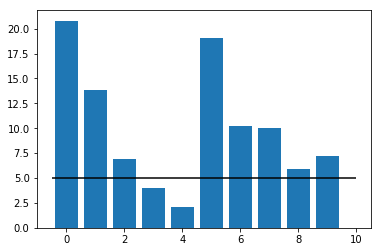

In [63]:
plt.bar(np.arange(M),gMixture.get_alpha()*100)
plt.hlines(5,-0.5,M) #treshold en Numero de anotadores x grupo--quizas no sirva...
#que pasa si hay un grupo que tiene 5 anotadores y otro que tiene 10 pero se comparte con otro que tiene 1?
#sirve para tener una idea general de cuantos anotadores x grupo hay

In [69]:
### comparar resultados con mas grupos o menos grupos
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.50 sec)	logL: -84431.118	F1: 0.8277
Iter 2/25
M step: done	E step: done, (in 2.49 sec)	logL: -82027.963	Tol: 0.02846	F1: 0.8218
Iter 3/25
M step: done	E step: done, (in 2.42 sec)	logL: -80732.001	Tol: 0.01580	F1: 0.8196
Iter 4/25
M step: done	E step: done, (in 2.41 sec)	logL: -80087.666	Tol: 0.00798	F1: 0.8191
Iter 5/25
M step: done	E step: done, (in 2.36 sec)	logL: -79755.607	Tol: 0.00415	F1: 0.8215
Iter 6/25
M step: done	E step: done, (in 2.40 sec)	logL: -79562.342	Tol: 0.00242	F1: 0.8249
Iter 7/25
M step: done	E step: done, (in 2.41 sec)	logL: -79413.819	Tol: 0.00187	F1: 0.8332
Iter 8/25
M step: done	E step: done, (in 2.39 sec)	logL: -79296.041	Tol: 0.00148	F1: 0.8391
Iter 9/25
M step: done	E step: done, (in 2.36 sec)	logL: -79187

In [68]:
#and multiples runs
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.00738633966784168, 0.033873725693389055]
Alphas:  (2,)
MV init:  (2700, 3)
Betas:  (2, 3, 3)
Q estimate:  (2700, 3, 2, 3)
Iter 1/25
M step: done	E step: done, (in 1.03 sec)	logL: -84088.130	
Iter 2/25
M step: done	E step: done, (in 1.23 sec)	logL: -82295.538	Tol: 0.02132	
Iter 3/25
M step: done	E step: done, (in 1.01 sec)	logL: -81493.772	Tol: 0.00974	
Iter 4/25
M step: done	E step: done, (in 1.05 sec)	logL: -81109.277	Tol: 0.00472	
Iter 5/25
M step: done	E step: done, (in 1.08 sec)	logL: -80929.009	Tol: 0.00222	
Iter 6/25
M step: done	E step: done, (in 1.05 sec)	logL: -80839.120	Tol: 0.00111	
Iter 7/25
M step: done	E step: done, (in 1.00 sec)	logL: -80784.744	Tol: 0.00067	
Iter 8/25
M step: done	E step: done, (in 0.98 sec)	logL: -80757.410	Tol: 0.00034	
Iter 9/25
M step: done	E step: done, (in 0.99 sec)	logL: -80739.910	Tol: 0.00022	
Finished training!
Initializing new EM...
Pre-train 

In [56]:
groups_annot_pred = np.argmax(prob_Gt,axis=1)
print(groups_annot_pred)
print(set(groups_annot_pred)) #revisar fast el numero de grupos utilizados...

[2 2 1 2 0 2 2 0 0 1 0 1 2 2 0 0 0 0 1 1 0 1 0 2 0 2 2 2 0 0 2 2 1 2 2 1 1
 1 0 2 1 2 0 0 1 0 1 0 1 0 0 2 1 2 2 0 0 1 1 2 1 0 1 2 2 0 2 0 2 0 0 2 2 0
 2 1 0 2 1 2 0 2 0 1 2 0 0 0 2 0 1 0 0 0 2 0 1 0 0 0]
{0, 1, 2}
CPU times: user 32.9 s, sys: 635 ms, total: 33.6 s
Wall time: 33 s


In [41]:
#obtain p(y^o|x,g=m)
gMixture.get_predictions_group(1,Xstd_train) #puedo medir acc con eso

array([[0.22092701, 0.66987641, 0.10919658],
       [0.18366501, 0.769683  , 0.04665199],
       [0.36506755, 0.28602405, 0.34890843],
       ...,
       [0.18930534, 0.75472514, 0.0559695 ],
       [0.33724762, 0.3600254 , 0.30272705],
       [0.44818453, 0.03039722, 0.5214183 ]])

In [36]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=5)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (50000, 10)
Betas:  (3, 10, 10)
Q estimate:  (50000, 10, 3, 10)
Iter 1/50
M step: done	E step: done, (in 72.82 sec)	logL: -2715965.263	F1: 0.6261
Iter 2/50
M step:

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 done	E step: done, (in 70.89 sec)	logL: -2679319.023	Tol: 0.01349	F1: 0.6246
Iter 3/50
M step: done	E step: done, (in 71.24 sec)	logL: -2637561.656	Tol: 0.01559	F1: 0.6541
Iter 4/50
M step: done	E step: done, (in 73.48 sec)	logL: -2620187.453	Tol: 0.00659	F1: 0.6679
Iter 5/50
M step: done	E step: done, (in 72.33 sec)	logL: -2608219.150	Tol: 0.00457	F1: 0.6693
Iter 6/50
M step: done	E step: done, (in 71.42 sec)	logL: -2592777.869	Tol: 0.00592	F1: 0.6812
Iter 7/50
M step: done	E step: done, (in 71.17 sec)	logL: -2581476.336	Tol: 0.00436	F1: 0.6877
Iter 8/50
M step: done	E step: done, (in 71.09 sec)	logL: -2576276.410	Tol: 0.00201	F1: 0.6841
Iter 9/50
M step: done	E step: done, (in 72.50 sec)	logL: -2566063.387	Tol: 0.00396	F1: 0.6931
Iter 10/50
M step: done	E step: done, (in 70.87 sec)	logL: -2562741.495	Tol: 0.00129	F1: 0.6959
Iter 11/50
M step: done	E step: done, (in 70.85 sec)	logL: -2559842.885	Tol: 0.00113	F1: 0.6933
Iter 12/50
M step: done	E step: done, (in 71.25 sec)	logL: -25533

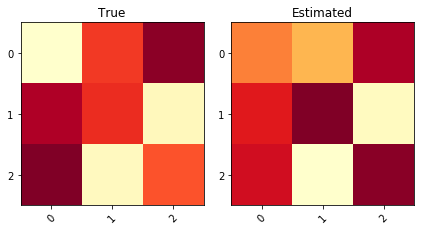

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


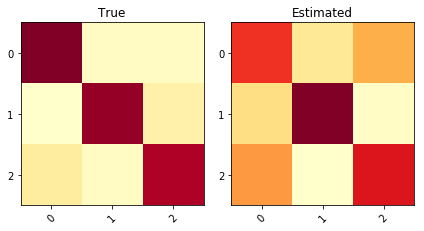

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


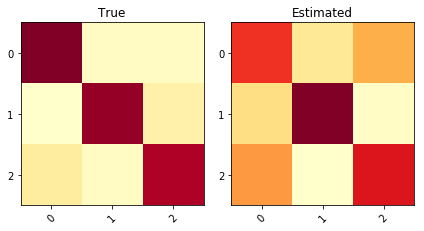

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


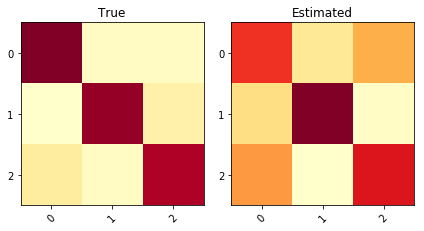

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


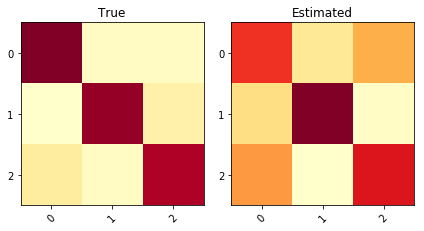

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


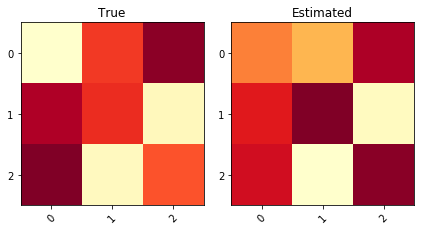

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


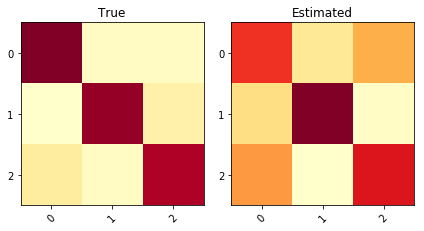

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


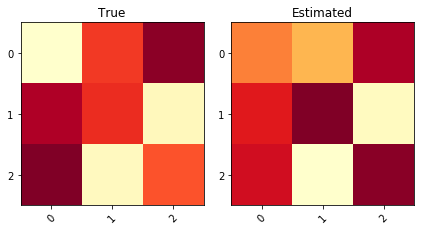

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


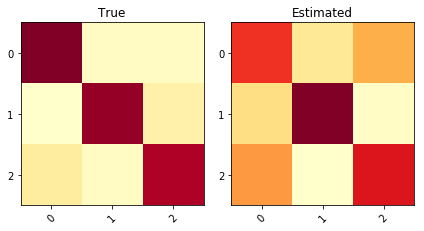

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


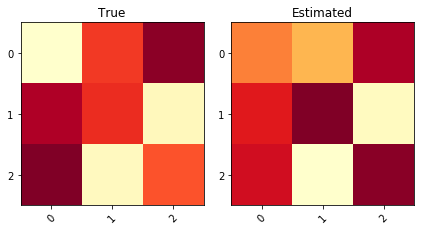

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


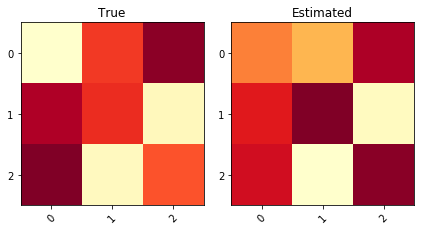

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


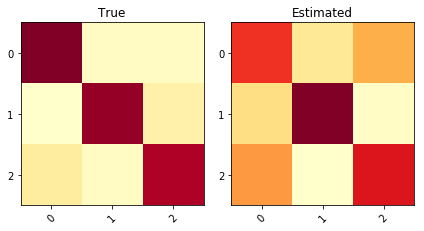

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


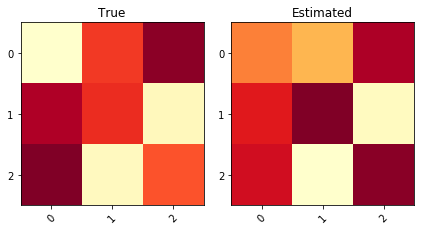

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


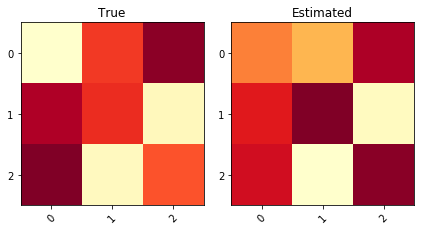

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


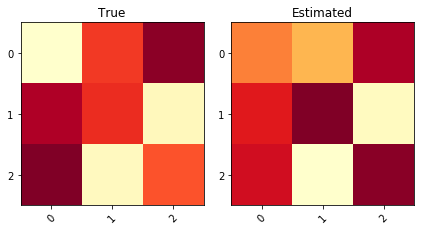

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


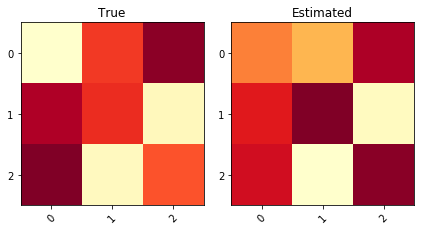

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


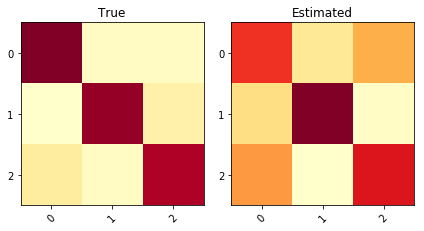

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


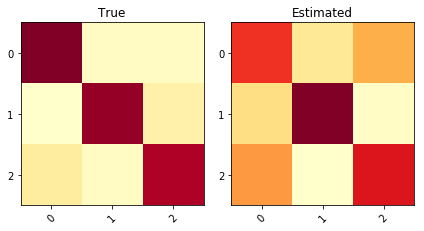

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


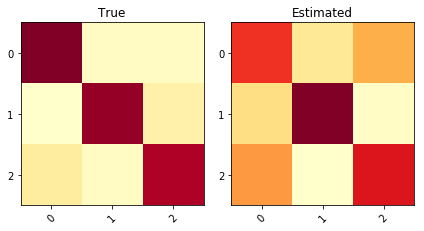

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


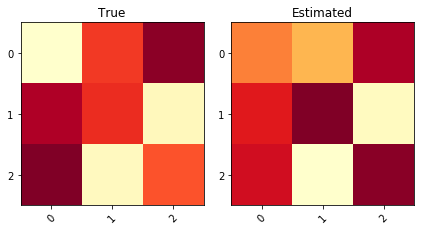

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


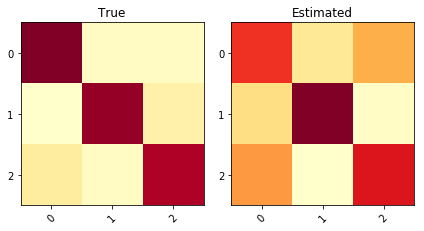

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


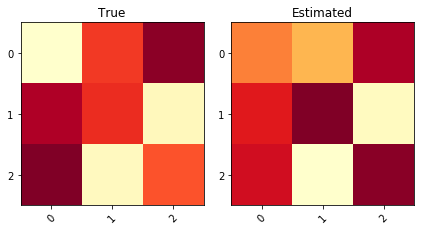

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


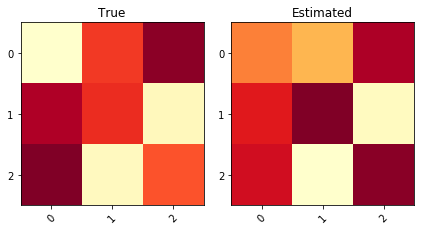

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


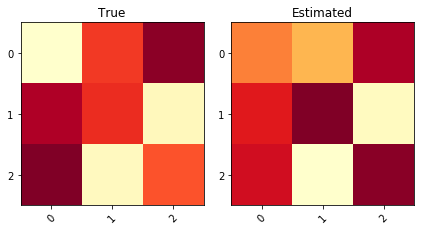

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


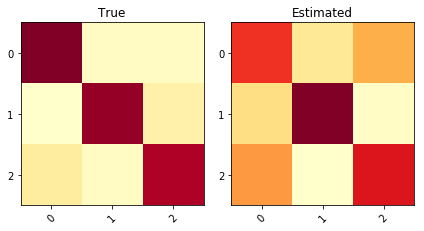

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


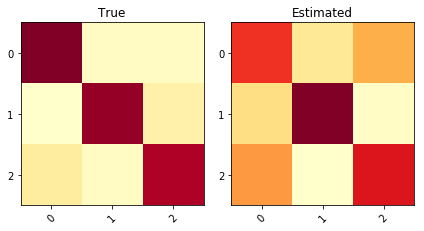

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


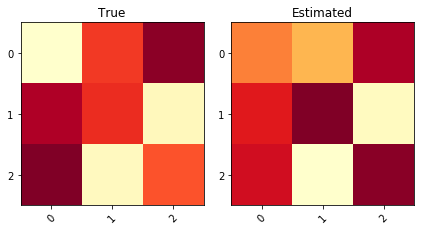

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


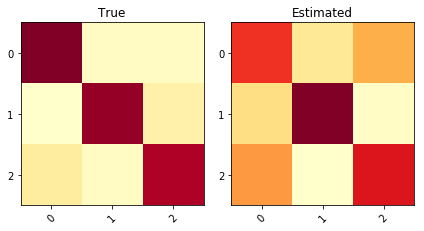

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


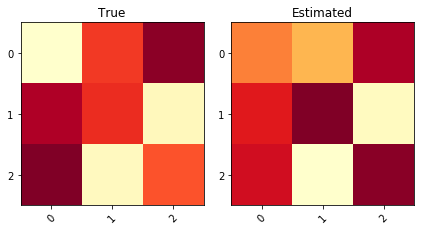

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


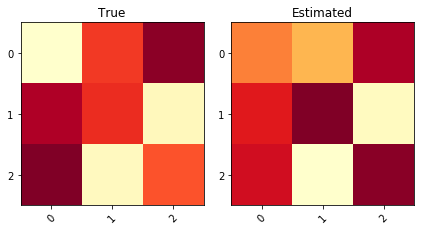

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


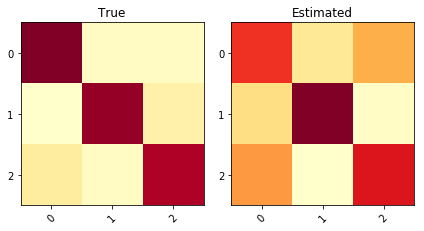

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


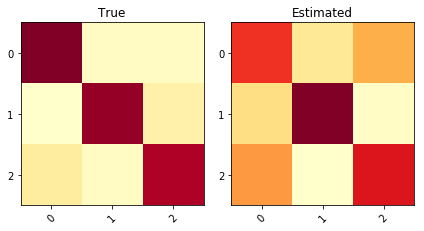

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


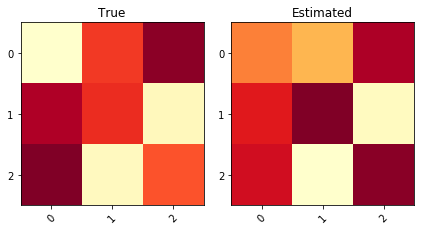

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


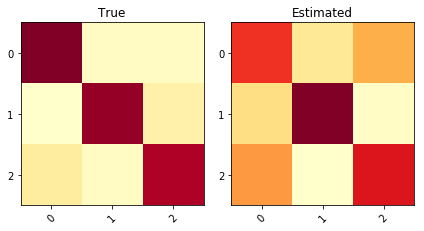

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


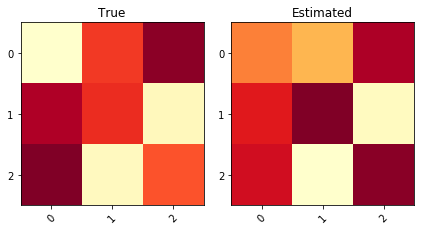

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


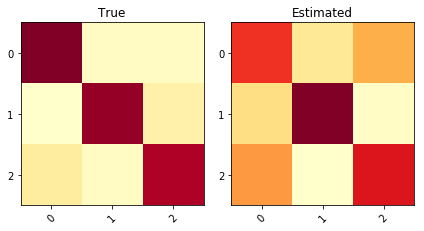

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


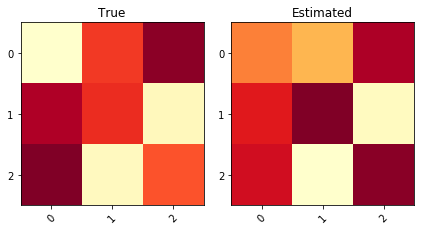

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


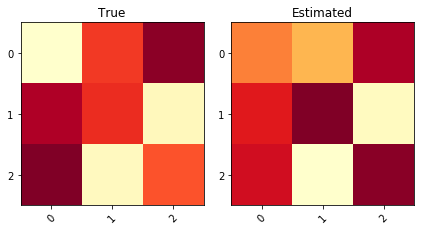

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


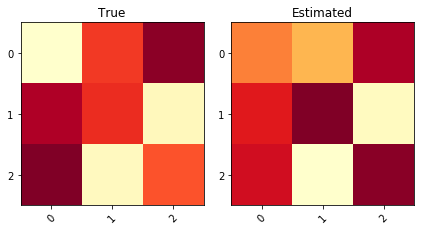

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


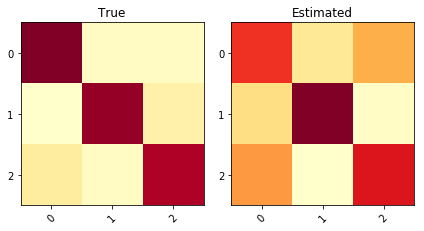

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


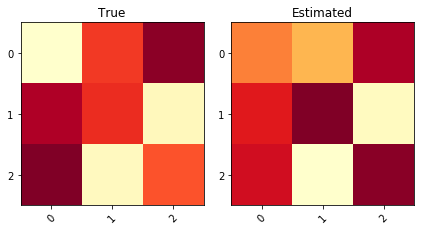

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


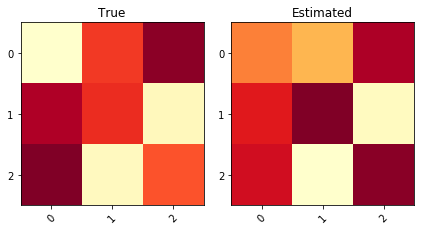

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


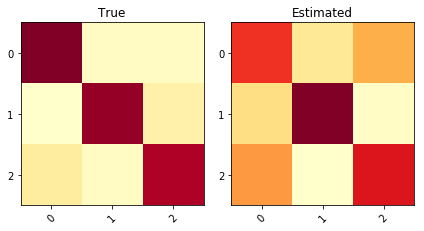

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


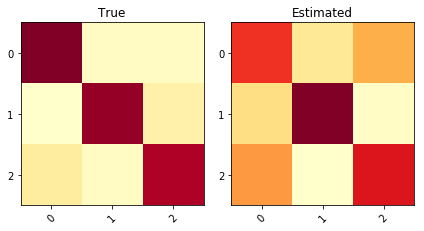

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


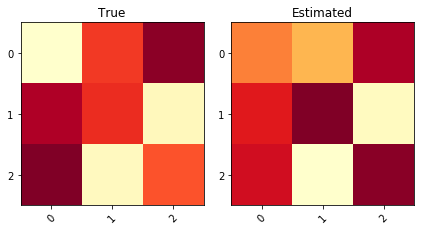

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


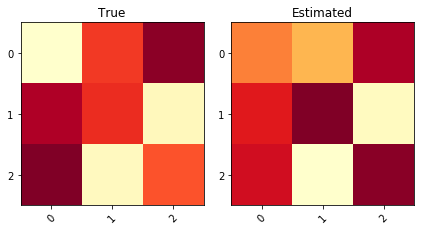

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


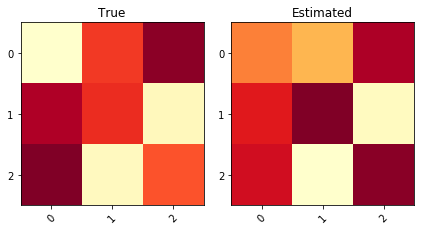

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


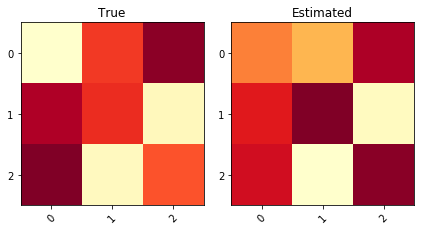

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


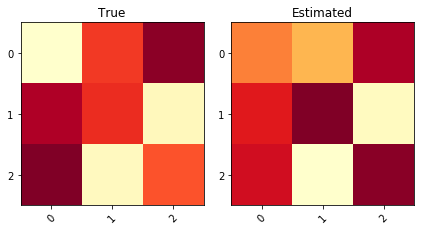

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


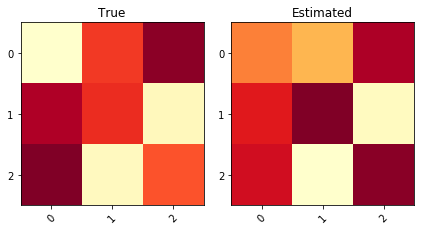

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


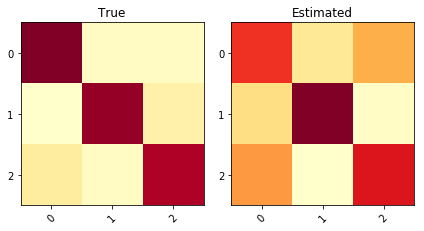

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


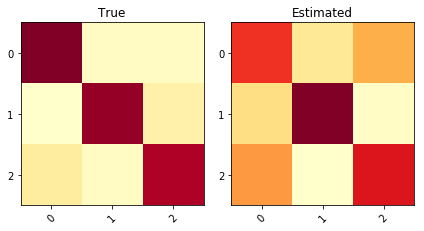

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


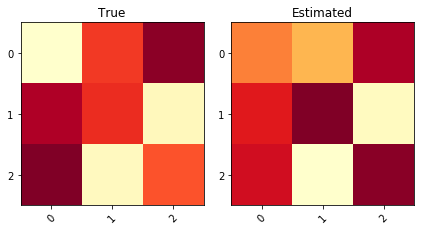

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


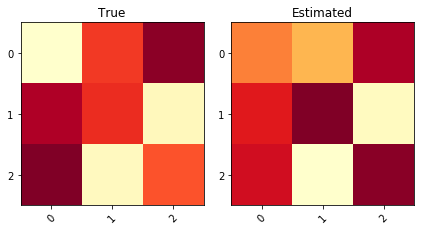

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


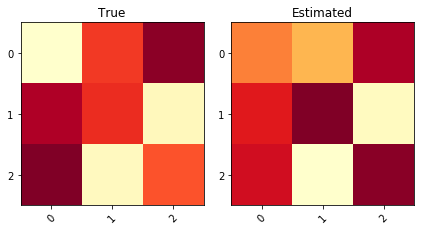

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


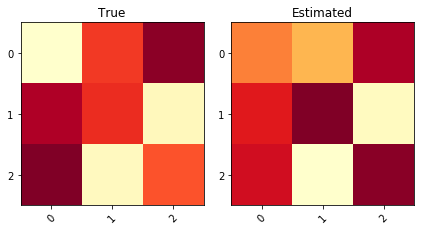

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


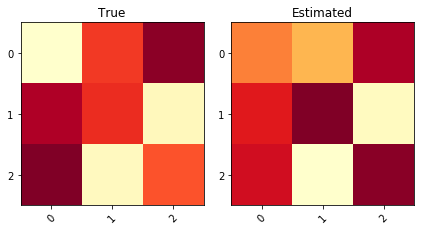

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


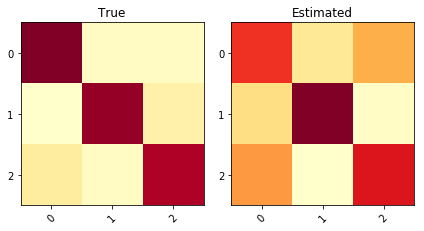

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


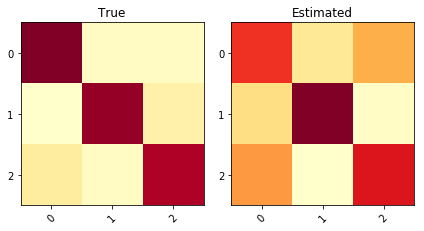

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


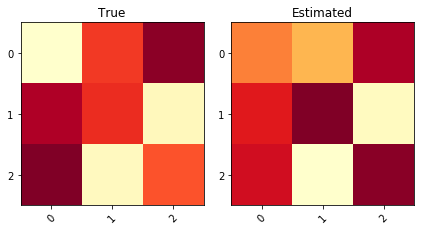

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


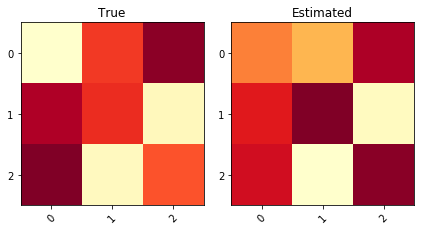

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


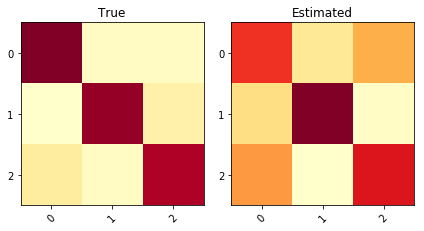

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


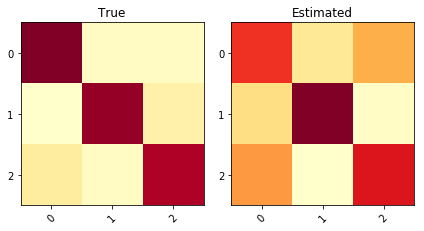

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


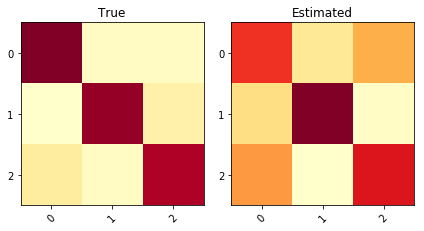

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


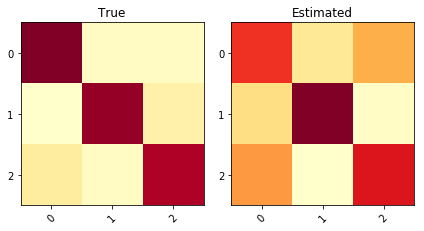

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


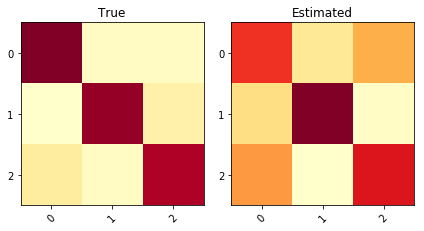

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


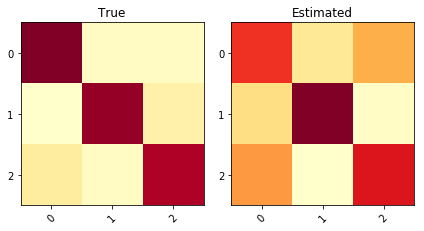

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


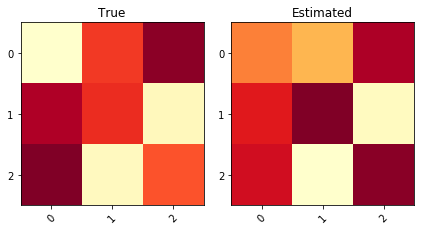

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


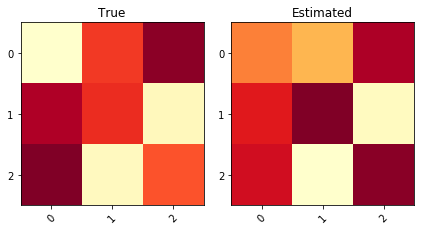

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


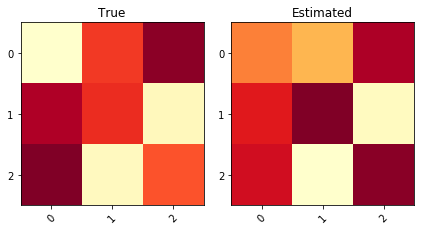

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


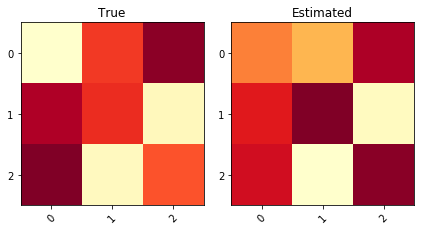

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


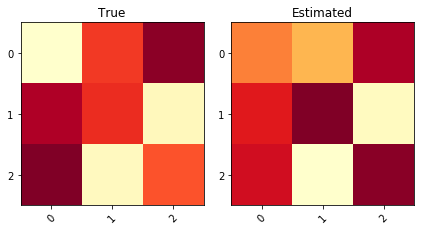

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


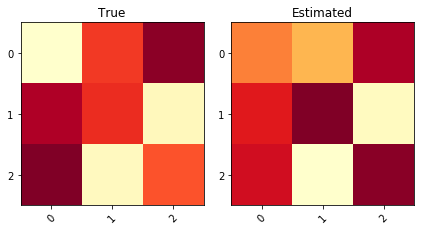

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


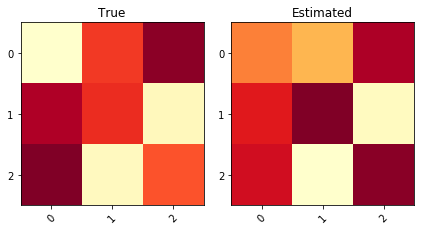

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


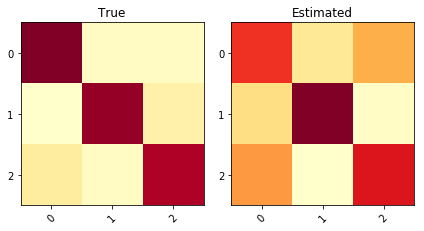

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


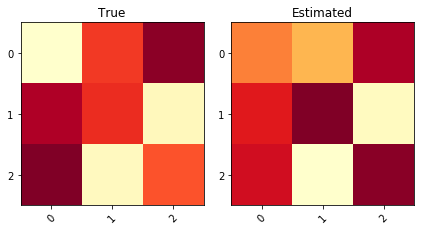

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


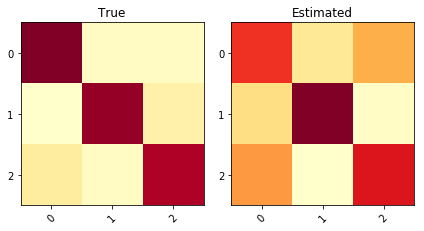

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


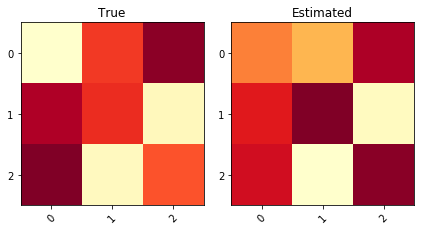

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


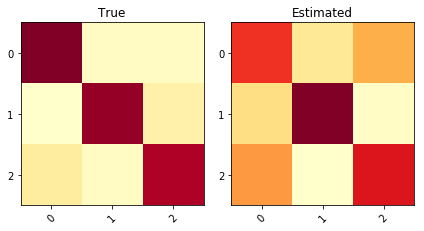

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


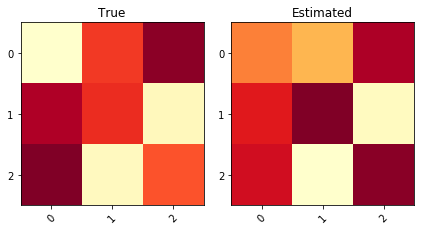

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


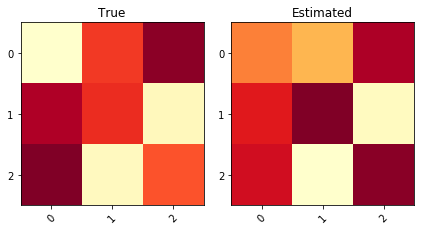

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


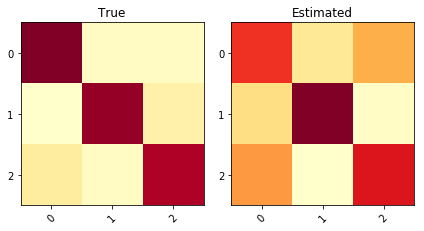

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


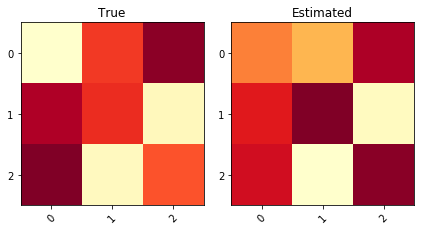

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


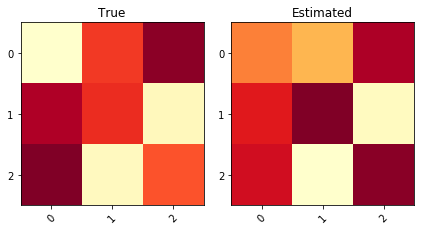

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


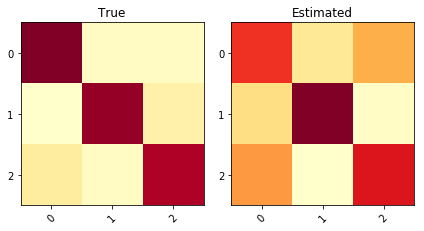

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


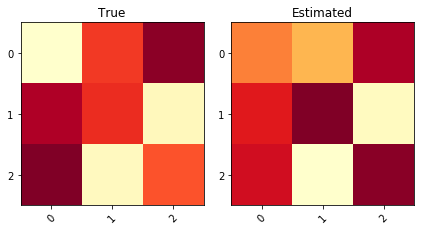

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


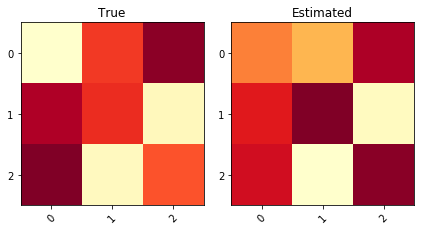

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


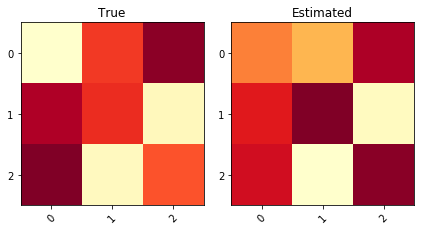

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


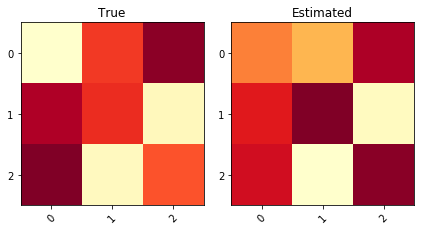

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


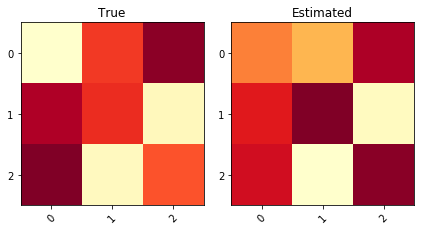

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


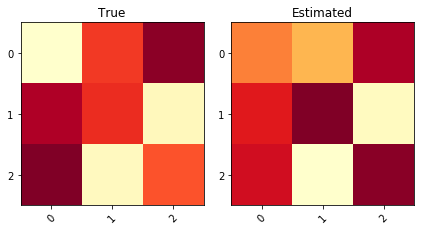

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


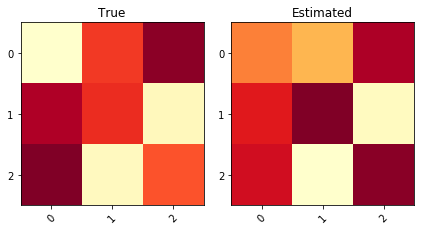

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


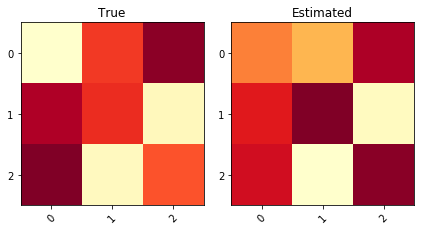

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


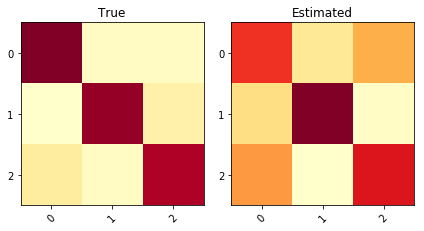

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


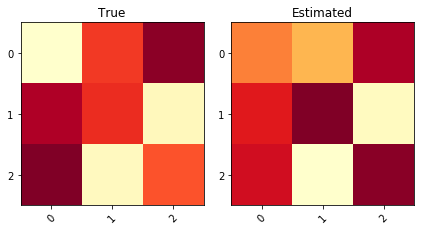

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


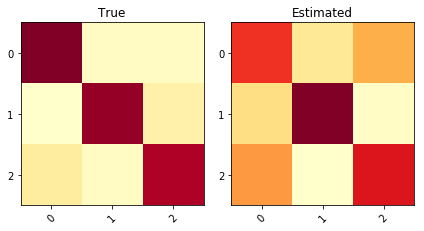

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


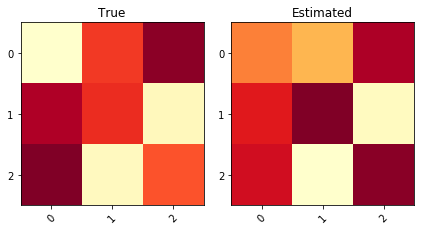

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


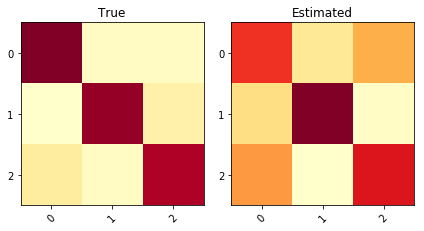

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


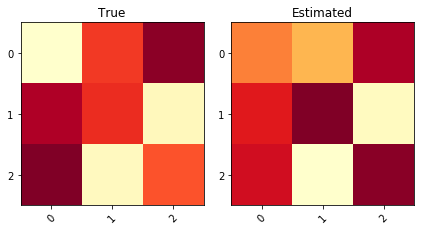

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


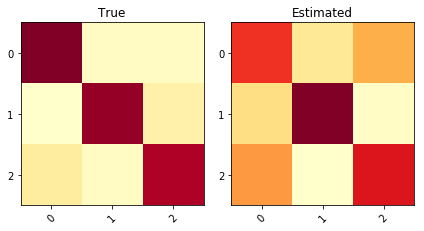

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.894444 |           0.894314 |
|  1 |       1 |   0.600741 |           0.538118 |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.891481 |           0.892084 |     0.185925 |              0.521372 |       0.143939 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.3 s, sys: 517 ms, total: 31.8 s
Wall time: 31.3 s


In [80]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


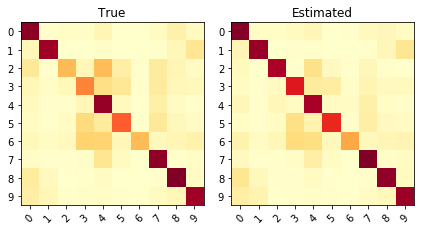

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


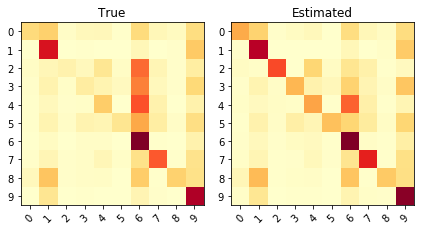

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


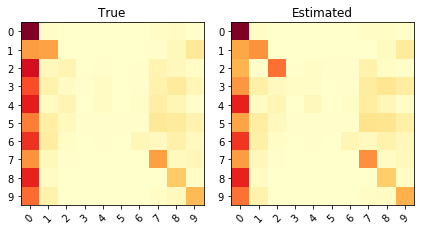

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


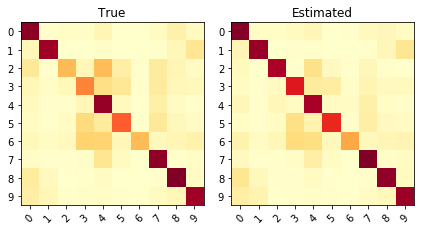

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1114	Pearson Correlation between diagonals: 0.4132


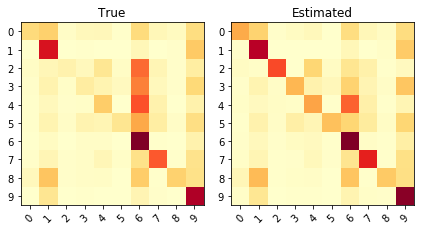

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


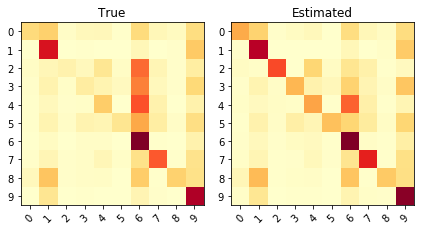

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


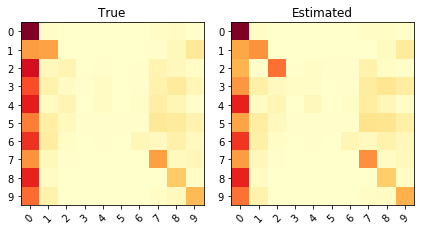

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


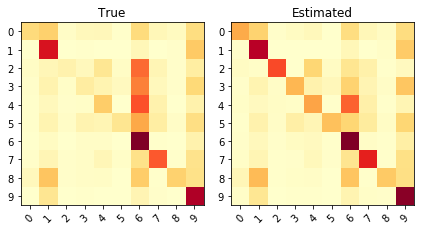

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


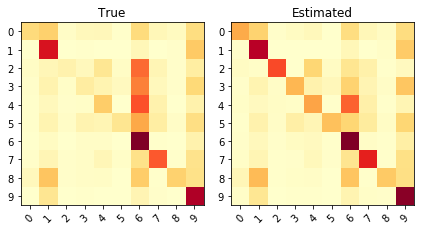

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


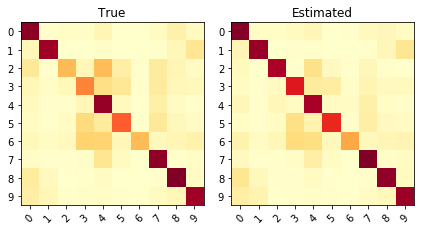

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


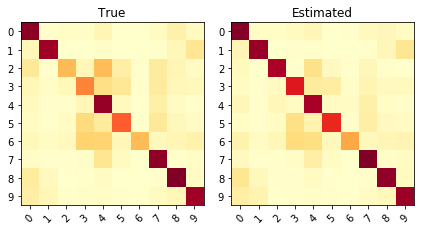

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


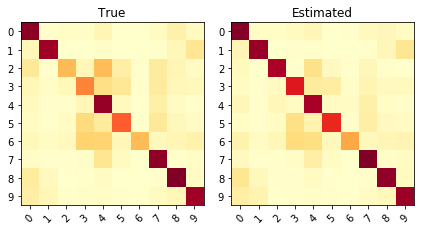

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


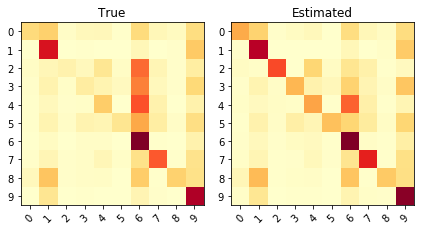

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


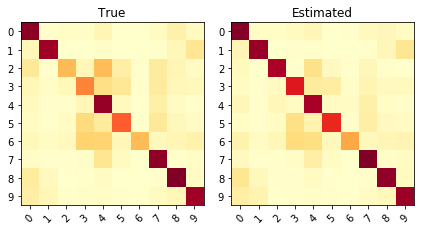

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


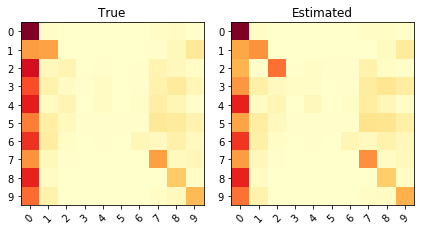

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation betwee

In [37]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [31]:
gMixture = GroupMixtureOpt(X_train.shape[1:],Kl=r_obs.shape[1],M=4,epochs=1,optimizer=OPT,pre_init=8)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
#gMixture.define_model("simple cnn",start_units=32,deep=3,BatchN=True,drop=0.25)
logL_hist = gMixture.multiples_run(10,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca]) #more runs

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 8 epochs... Done!
Lambda by group:  [0.1378987600466675, 0.24523473249025382, 0.8920139342354865, 0.12216360576995895]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done	E step: done, (in 19.07 sec)	logL: -2638904.850	
Iter 2/50
M step: done	E step: done, (in 19.08 sec)	logL: -2610500.685	Tol: 0.01076	
Iter 3/50
M step: done	E step: done, (in 19.63 sec)	logL: -2591147.926	Tol: 0.00741	
Iter 4/50
M step: done	E step: done, (in 19.23 sec)	logL: -2583362.544	Tol: 0.00300	
Iter 5/50
M step: done	E step: done, (in 18.98 sec)	logL: -2565883.684	Tol: 0.00677	
Iter 6/50
M step: done	E step: done, (in 19.05 sec)	logL: -2578962.508	Tol: 0.00510	
Iter 7/50
M step: done	E step: done, (in 18.66 sec)	logL: -2561385.656	Tol: 0.00682	
Iter 8/50
M step: done	E step: done, (in 18.67 sec)	logL: -2549138.193	Tol: 0.00478	
Iter 9/50
M step: done	E step: done, (in 18.30 sec)	l

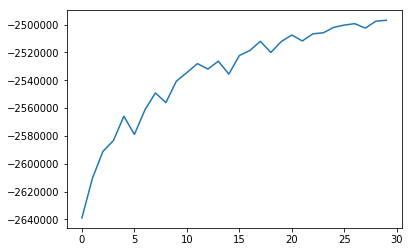

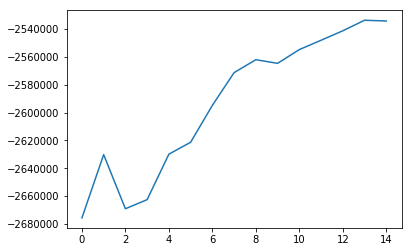

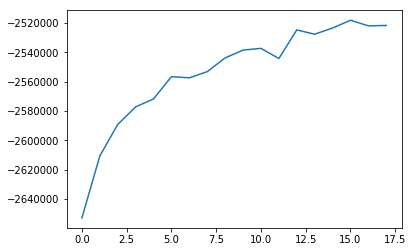

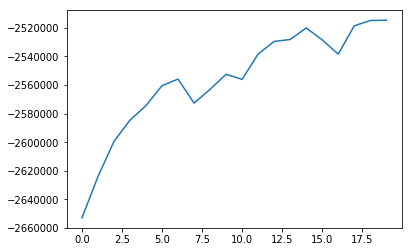

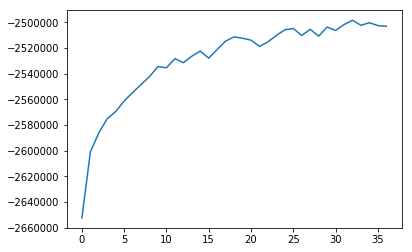

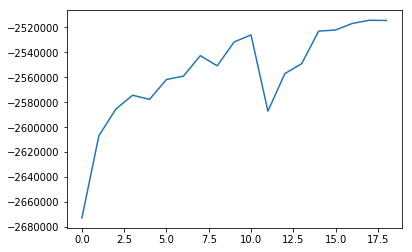

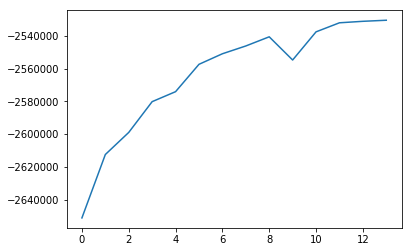

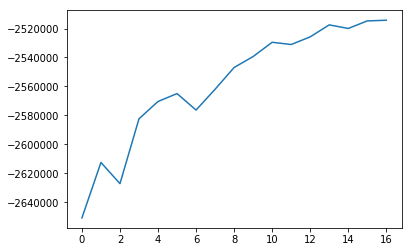

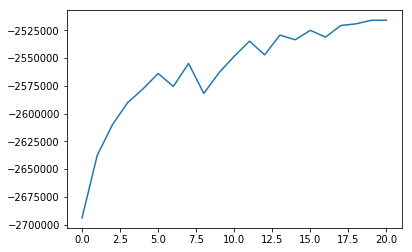

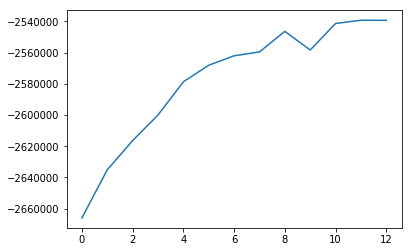

In [32]:
for value in logL_hist:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()
#plt.plot(logL_hist)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


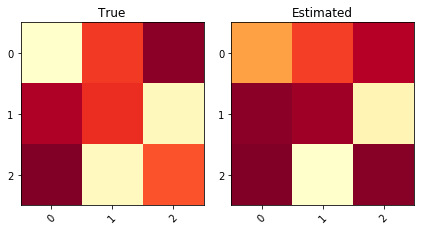

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


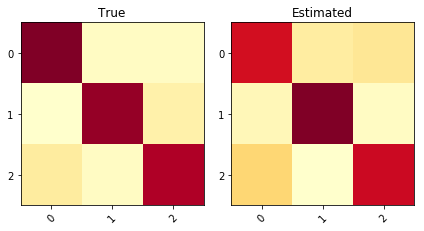

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


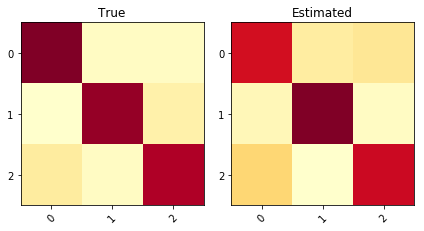

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


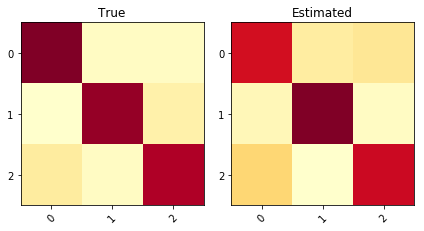

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


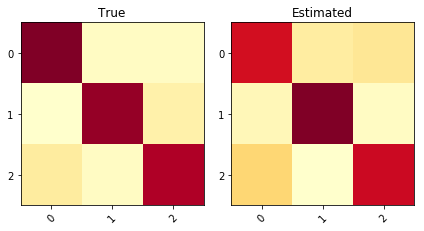

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


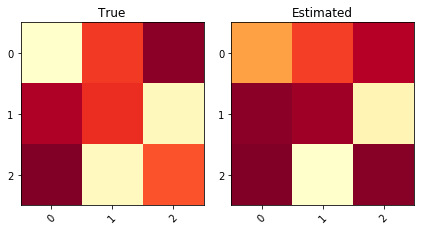

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


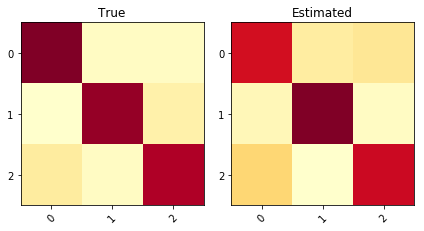

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


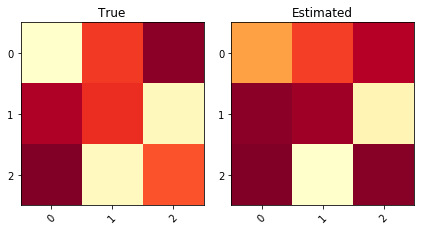

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


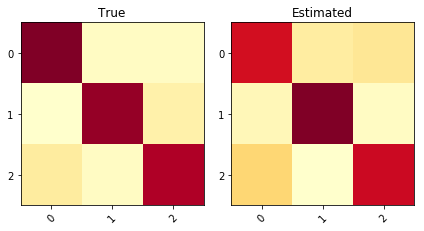

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


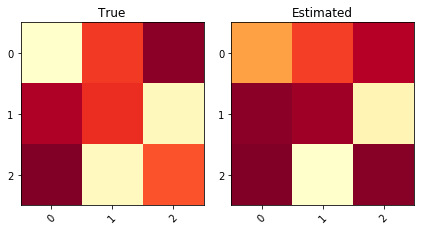

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


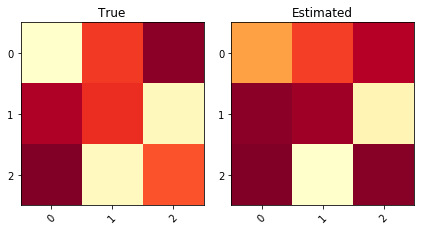

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


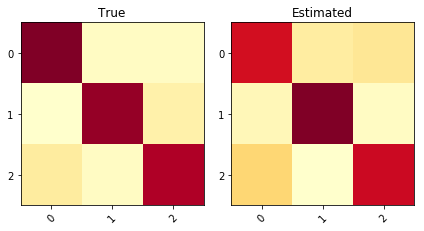

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


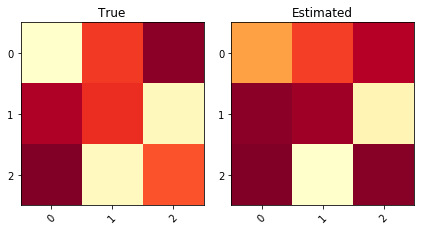

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


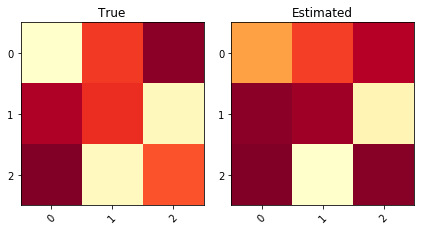

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


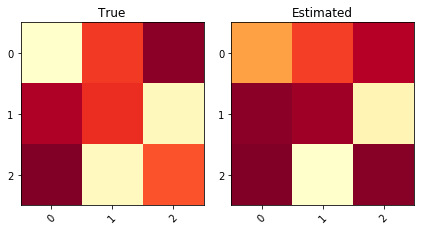

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


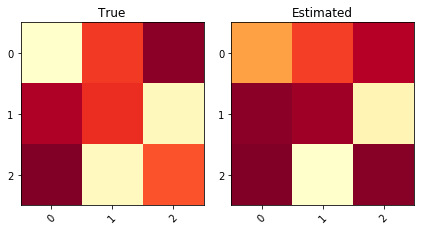

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


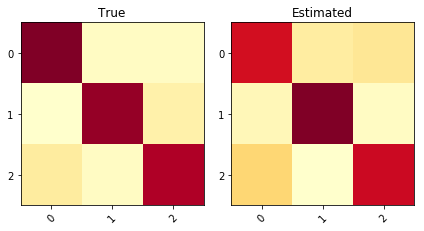

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


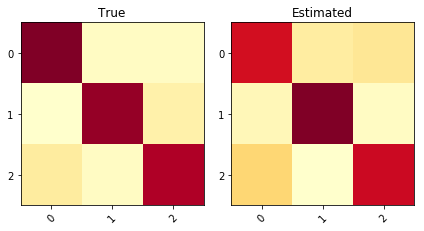

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


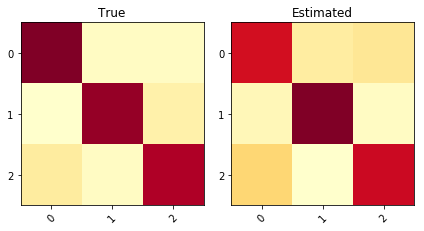

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


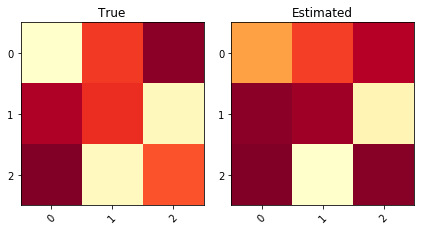

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


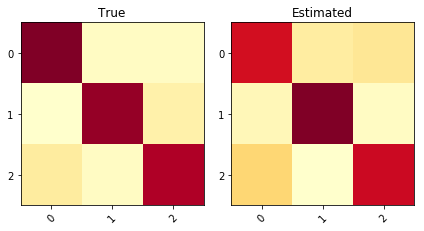

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


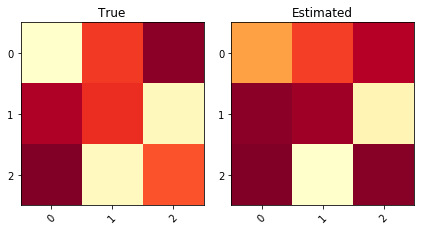

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


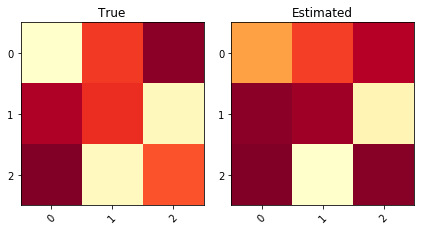

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


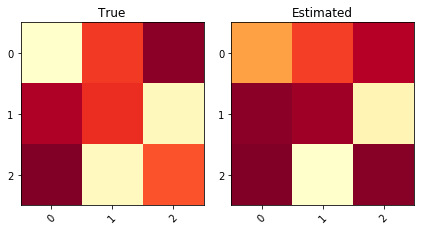

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


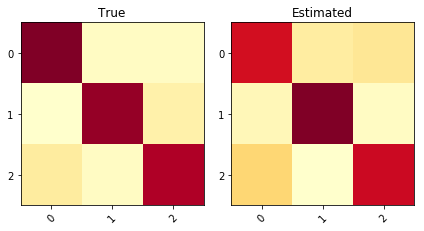

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


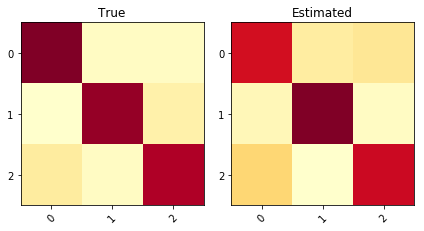

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


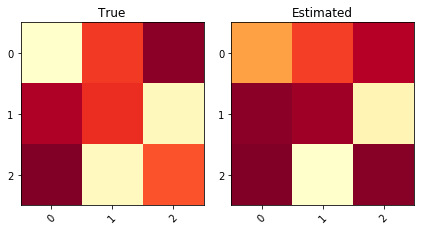

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


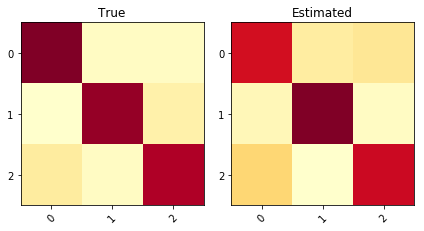

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


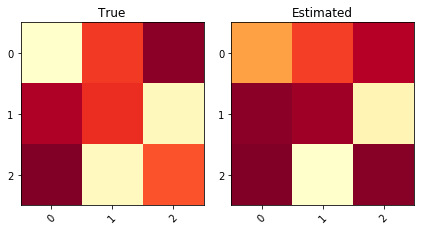

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


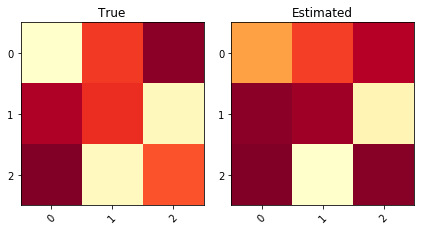

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


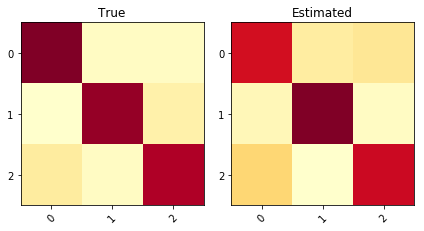

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


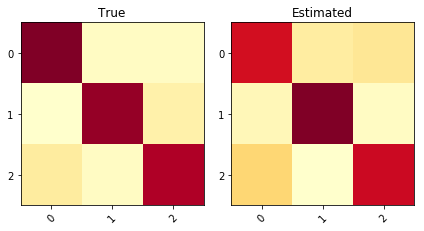

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


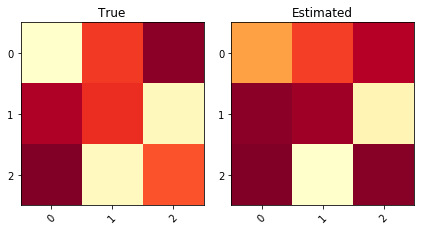

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


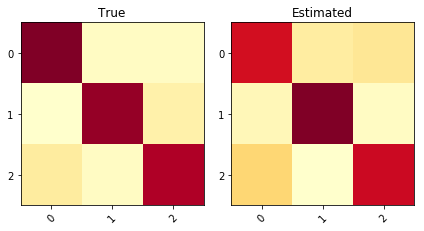

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


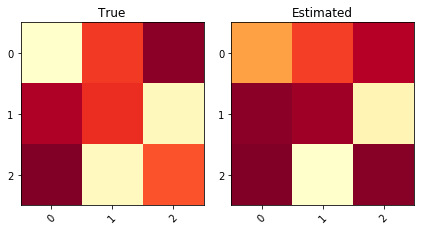

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


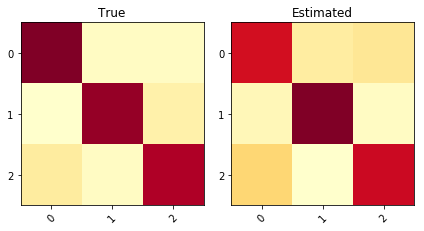

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


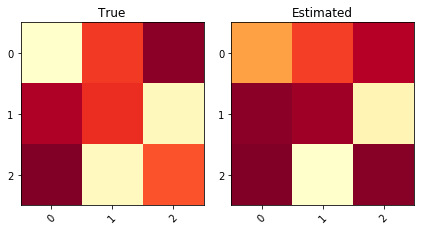

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


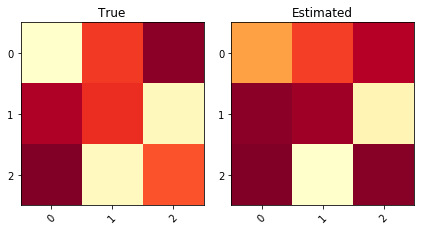

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


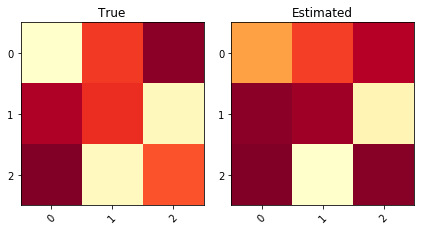

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


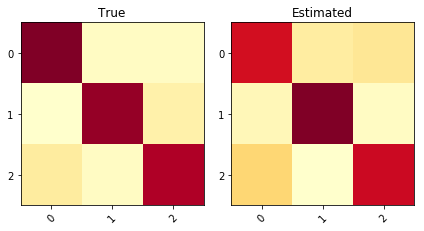

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


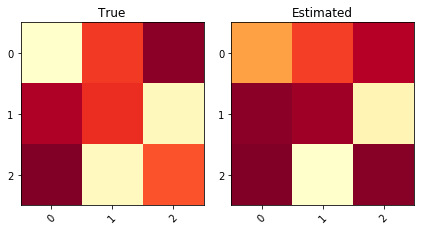

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


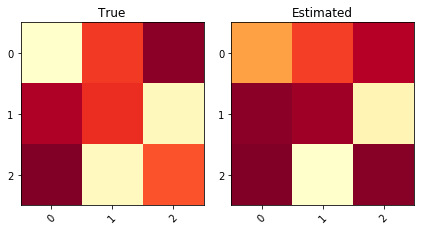

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


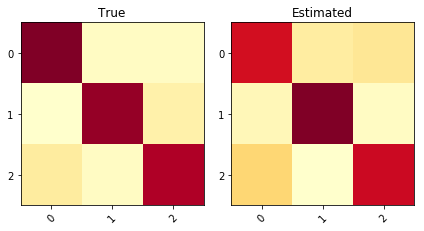

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


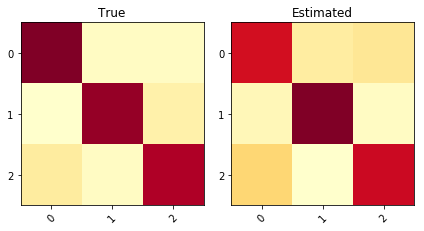

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


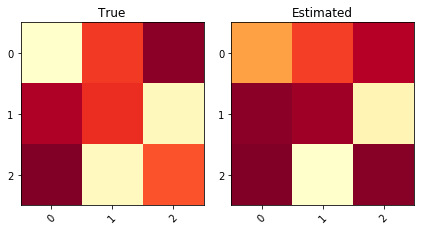

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


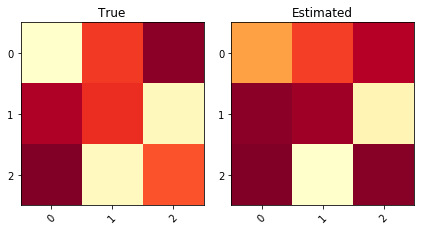

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


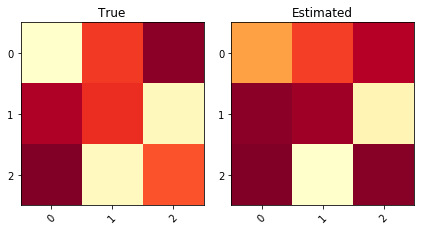

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


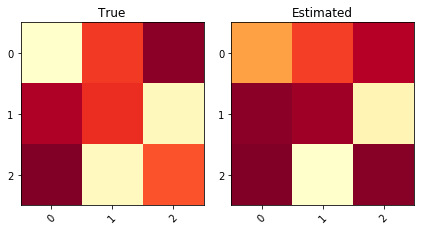

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


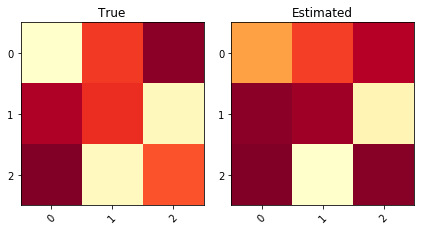

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


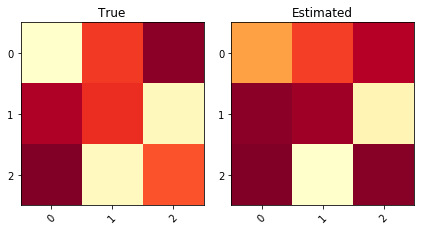

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


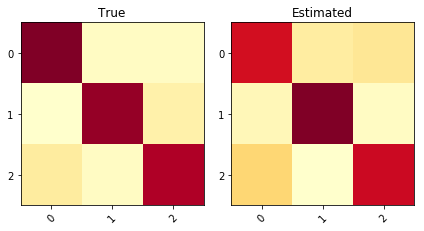

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


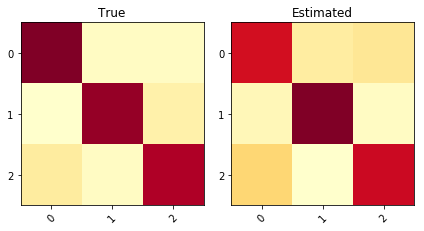

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


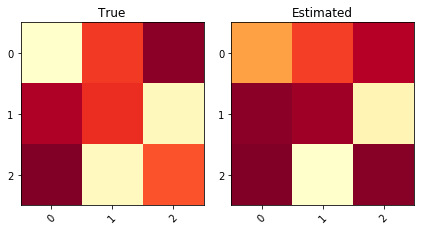

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


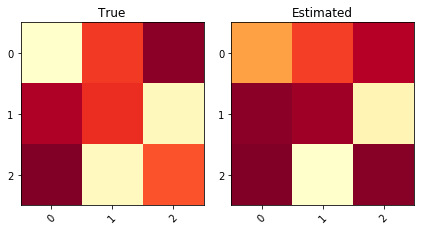

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


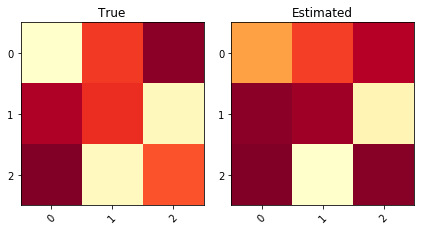

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


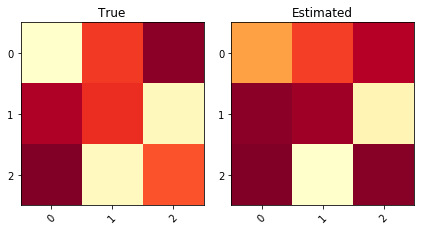

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


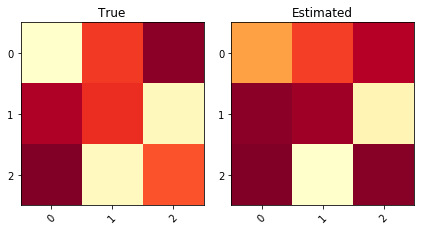

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


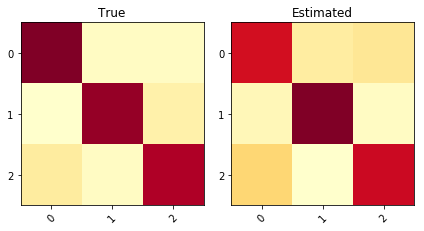

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


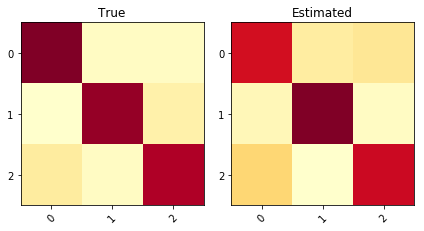

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


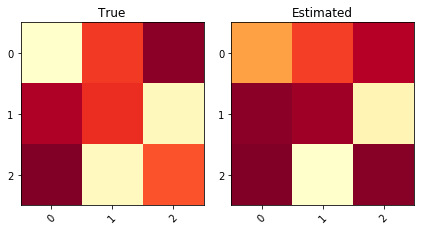

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


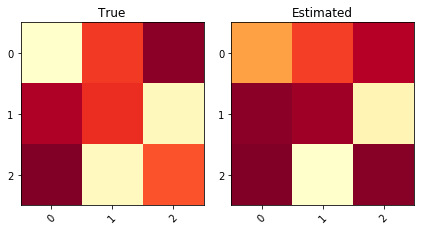

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


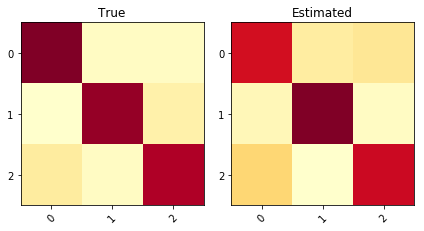

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


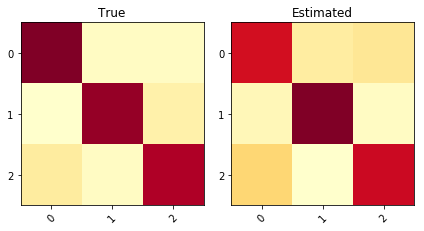

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


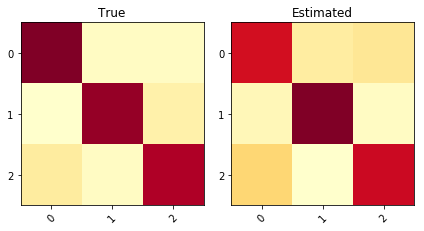

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


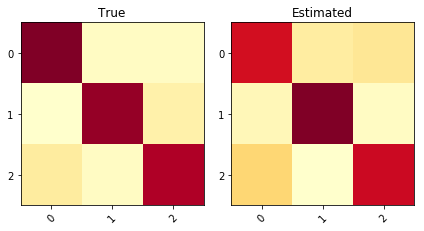

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


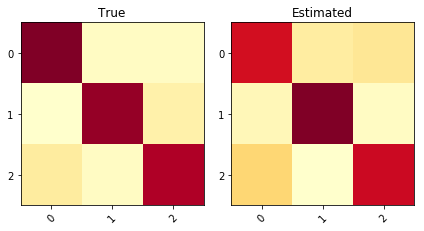

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


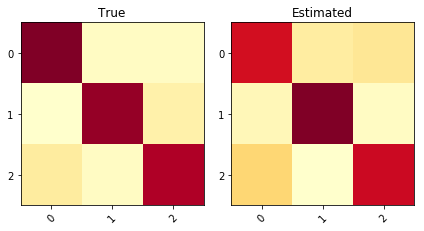

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


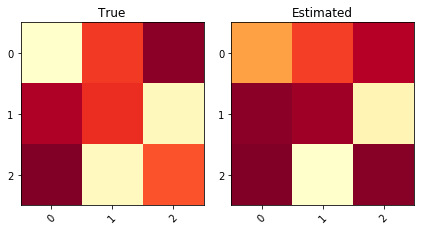

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


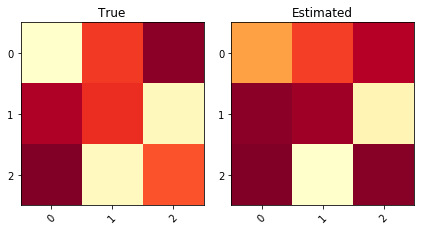

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


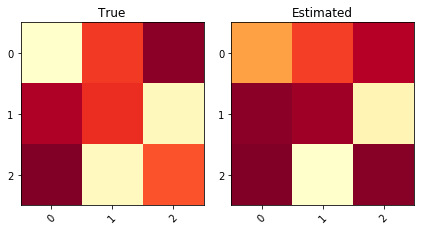

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


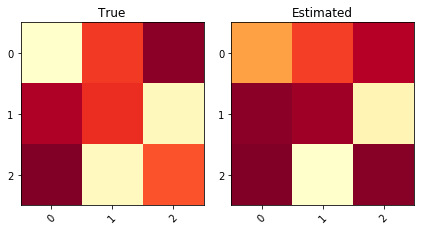

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


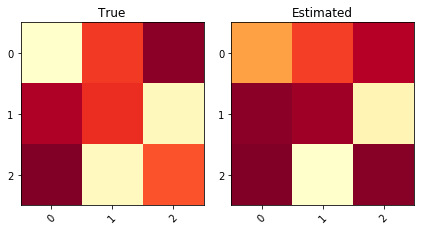

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


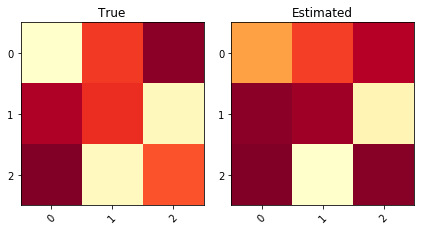

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


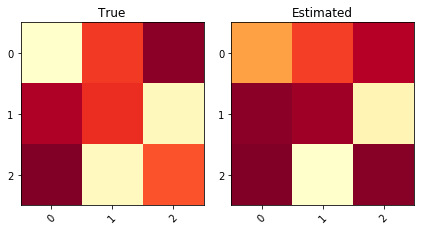

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


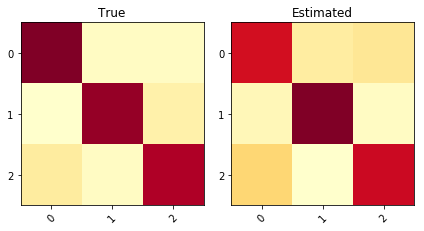

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


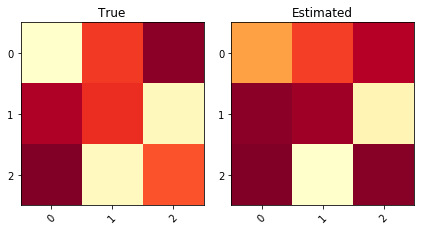

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


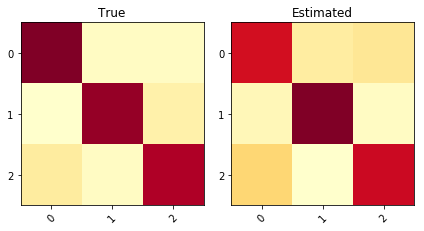

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


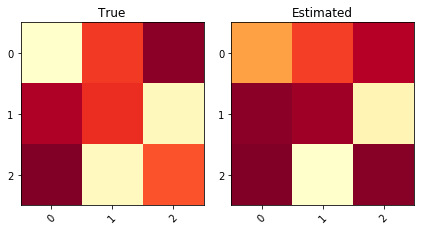

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


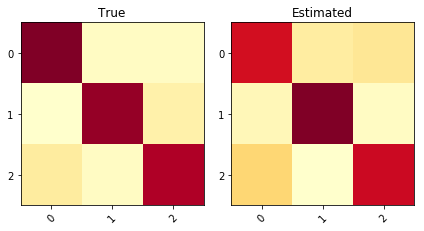

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


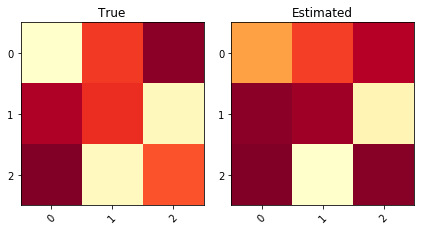

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


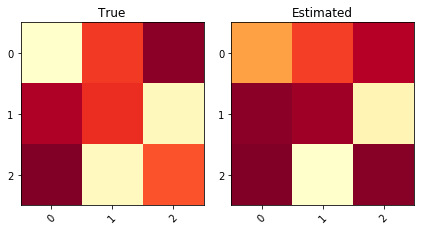

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


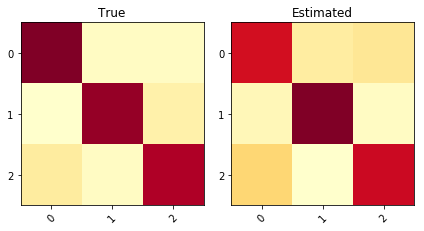

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


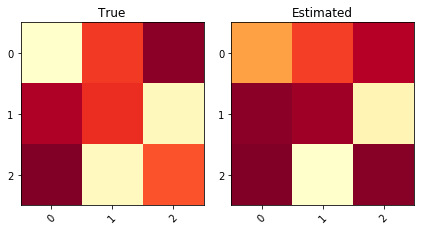

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


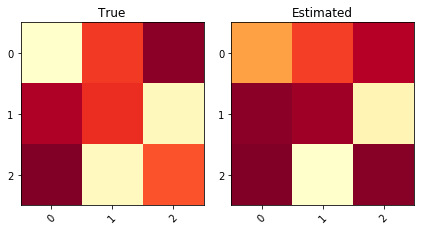

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


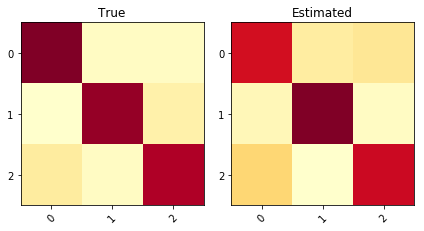

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


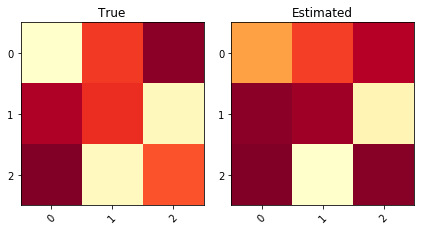

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


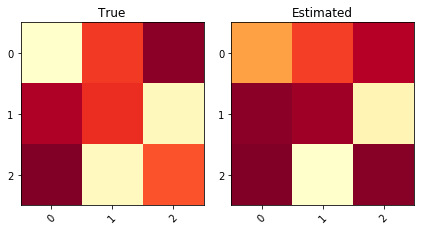

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


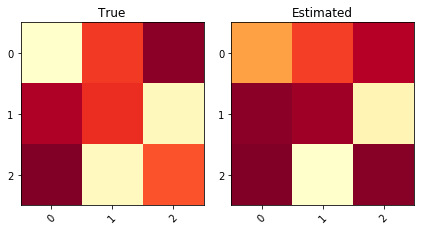

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


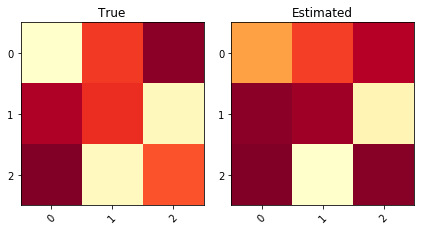

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


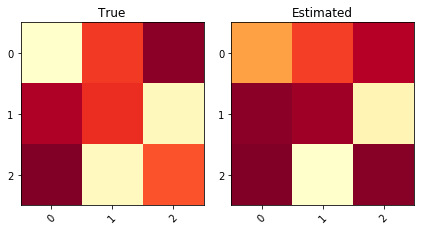

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


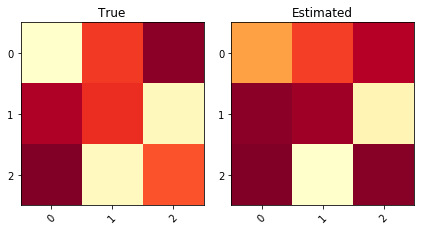

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


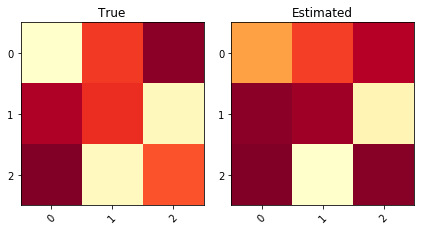

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


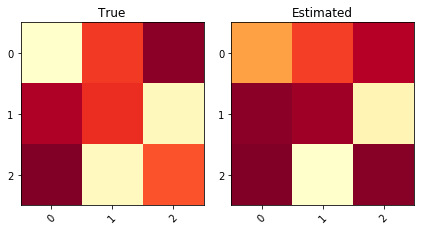

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


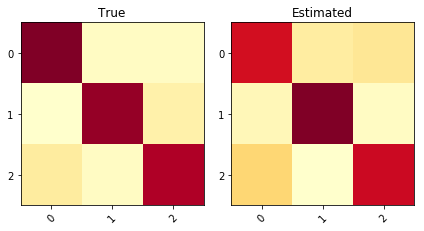

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


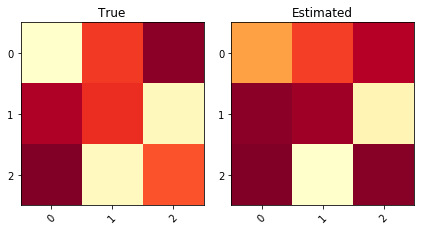

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


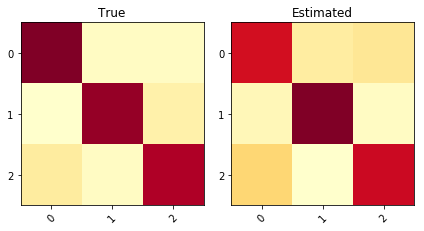

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


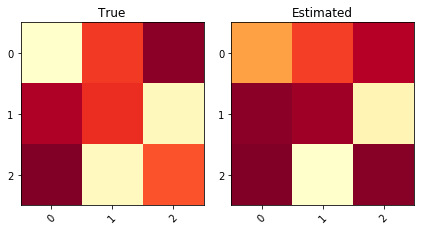

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


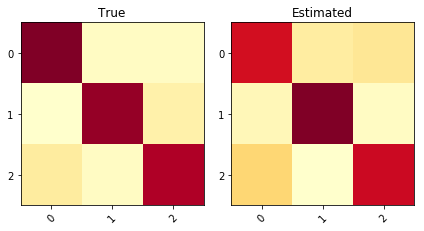

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


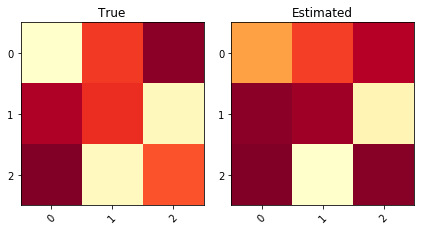

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


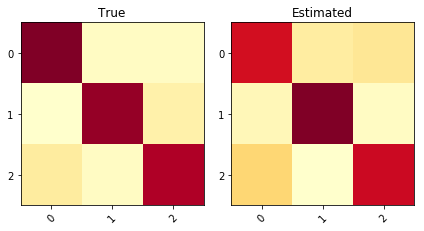

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.29963  |           0.220811 |
|  1 |       1 |   0.897037 |           0.89708  |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.894444 |           0.894994 |     0.094598 |              0.565182 |        0.16847 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.4 s, sys: 555 ms, total: 31.9 s
Wall time: 31.4 s


In [74]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

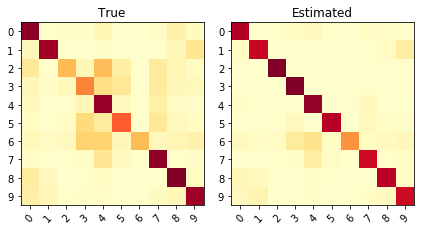

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


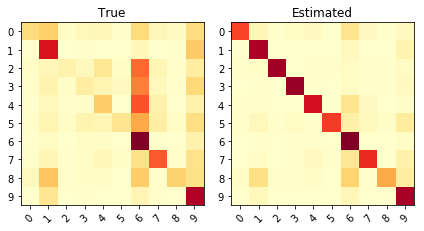

KL divergence: 0.6230	Pearson Correlation between diagonals: 0.3983


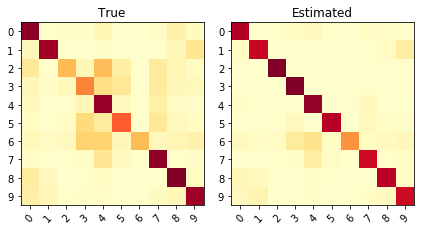

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


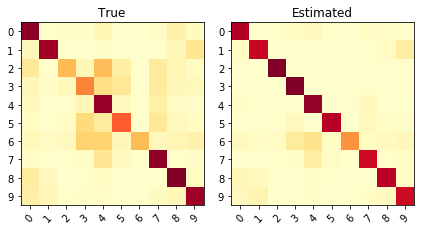

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


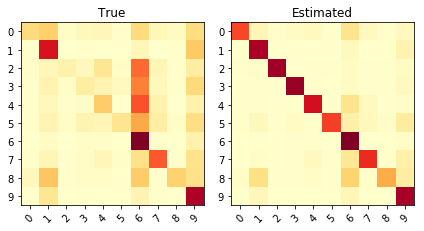

KL divergence: 0.6187	Pearson Correlation between diagonals: 0.4000


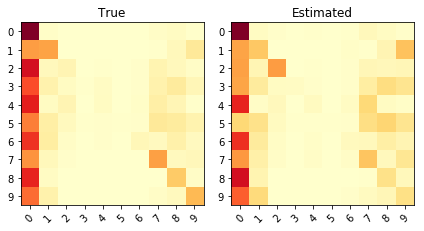

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


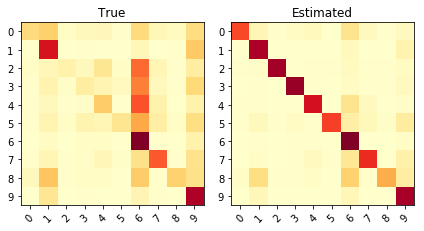

KL divergence: 0.6106	Pearson Correlation between diagonals: 0.4034


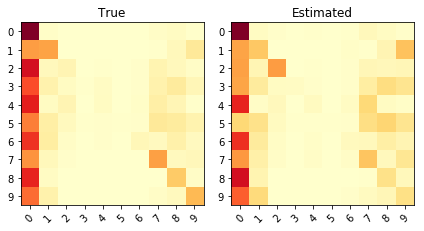

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


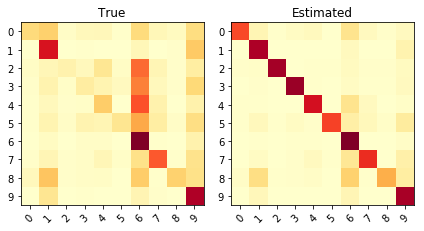

KL divergence: 0.6022	Pearson Correlation between diagonals: 0.4069


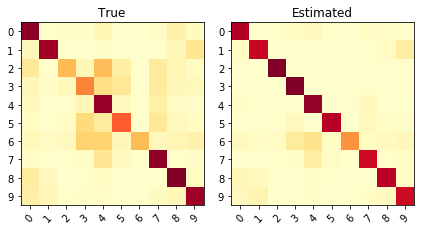

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


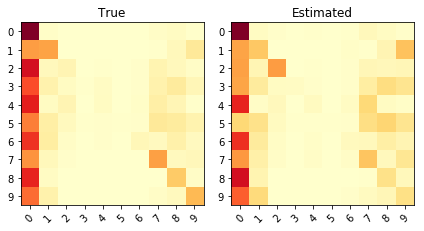

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


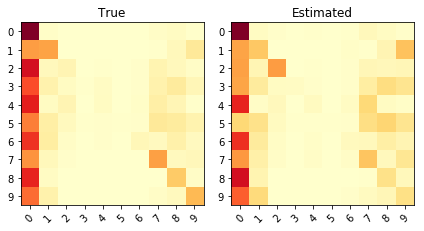

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


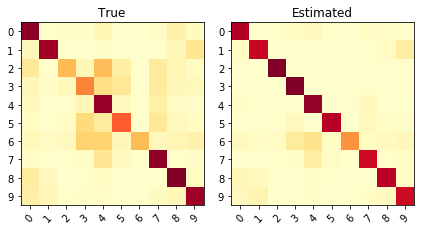

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


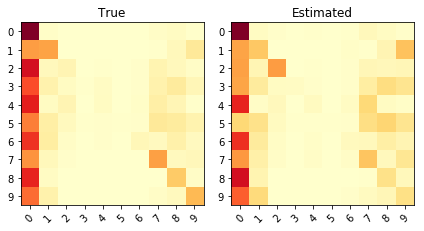

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


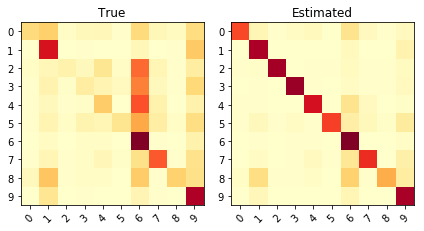

KL divergence: 0.6063	Pearson Correlation between diagonals: 0.4052
A result
 +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |    0.63382 |            0.63382 |
|  1 |       1 |    0.8407  |            0.8407  |
|  2 |       2 |    0.1     |            0.1     |
|  3 |       3 |    0.65312 |            0.65312 |
+----+---------+------------+--------------------+
A result
 +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |    0.75984 |            0.75984 |     0.429922 |              0.428081 |       0.143167 |
+----+--------+------------+--------------------+--------------+----------------

In [34]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [31]:
from  scipy.stats import entropy
from sklearn.metrics import accuracy_score
from code.evaluation import Evaluation_metrics
def distance_function(predicted,ob): # to cluster
    return [-np.sum(predicted*np.log(ob))] #funciona bien -- over 90 = 5 -- over 90 = 8 (lambda=1)

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004531 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9083646  0.37818074 0.8743462 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 7.91 sec)	logL: -26343.553	
Iter 2/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -25175.854	Tol1: 0.04433	Tol2: 0.23760	Tol3: 0.00845	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24725.989	Tol1: 0.01787	Tol2: 0.12381	Tol3: 0.00556	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24379.375	Tol1: 0.01402	Tol2: 0.10846	Tol3: 0.00605	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24066.842	Tol1: 0.01282	Tol2: 0.10404	Tol3: 0.00761	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23758.880	Tol1: 0.01280	Tol2: 0.09879	Tol3: 0.00860	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL

M step: done,  E step: done //  (in 0.14 sec)	logL: -22342.488	Tol1: 0.01309	Tol2: 0.12479	Tol3: 0.00991	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22084.404	Tol1: 0.01155	Tol2: 0.12003	Tol3: 0.00845	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21870.062	Tol1: 0.00971	Tol2: 0.11217	Tol3: 0.00811	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21687.617	Tol1: 0.00834	Tol2: 0.10032	Tol3: 0.00784	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21534.689	Tol1: 0.00705	Tol2: 0.08619	Tol3: 0.00741	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21404.273	Tol1: 0.00606	Tol2: 0.07132	Tol3: 0.00708	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21290.428	Tol1: 0.00532	Tol2: 0.05683	Tol3: 0.00678	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21198.364	Tol1: 0.00432	Tol2: 0.04360	Tol3: 0.00658	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21126.471	To

M step: done,  E step: done //  (in 0.15 sec)	logL: -24331.054	Tol1: 0.01681	Tol2: 0.06757	Tol3: 0.00777	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23955.889	Tol1: 0.01542	Tol2: 0.08054	Tol3: 0.00848	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23606.138	Tol1: 0.01460	Tol2: 0.09159	Tol3: 0.00890	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23282.511	Tol1: 0.01371	Tol2: 0.10001	Tol3: 0.00905	
Iter 9/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22970.989	Tol1: 0.01338	Tol2: 0.10387	Tol3: 0.00877	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22677.072	Tol1: 0.01280	Tol2: 0.10607	Tol3: 0.00827	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22416.522	Tol1: 0.01149	Tol2: 0.10489	Tol3: 0.00734	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22185.647	Tol1: 0.01030	Tol2: 0.09628	Tol3: 0.00592	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21965.528	Tol1:

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4858628  0.8706779  0.62824714]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.54 sec)	logL: -28044.587	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25915.016	Tol1: 0.07594	Tol2: 0.35170	Tol3: 0.05115	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25337.039	Tol1: 0.02230	Tol2: 0.13540	Tol3: 0.03959	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25018.612	Tol1: 0.01257	Tol2: 0.08527	Tol3: 0.01827	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24759.762	Tol1: 0.01035	Tol2: 0.06575	Tol3: 0.00694	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24527.662	Tol1: 0.00937	Tol2: 0.05820	Tol3: 0.00110	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24301.248	Tol1: 0.00923	Tol2: 0.05749	Tol3: 0.00448	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	l

M step: done,  E step: done //  (in 0.14 sec)	logL: -21598.958	Tol1: 0.00587	Tol2: 0.05580	Tol3: 0.00428	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21493.032	Tol1: 0.00490	Tol2: 0.04757	Tol3: 0.00357	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21398.687	Tol1: 0.00439	Tol2: 0.03888	Tol3: 0.00289	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21313.257	Tol1: 0.00399	Tol2: 0.03142	Tol3: 0.00231	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21239.930	Tol1: 0.00344	Tol2: 0.02559	Tol3: 0.00168	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003062 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.55664164 0.34968168 0.35916418]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.41 sec)	logL: -25870.631	
Iter 2/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.14 sec)	logL: -20040.391	Tol1: 0.00273	Tol2: 0.03395	Tol3: 0.00129	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19985.650	Tol1: 0.00273	Tol2: 0.03279	Tol3: 0.00115	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19947.017	Tol1: 0.00193	Tol2: 0.03538	Tol3: 0.00105	
Iter 24/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19914.650	Tol1: 0.00162	Tol2: 0.03472	Tol3: 0.00093	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19889.182	Tol1: 0.00128	Tol2: 0.03457	Tol3: 0.00082	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19865.803	Tol1: 0.00118	Tol2: 0.03503	Tol3: 0.00077	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19845.991	Tol1: 0.00100	Tol2: 0.03507	Tol3: 0.00066	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19831.323	Tol1: 0.00074	Tol2: 0.03518	Tol3: 0.00060	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19821.225	T

M step: done,  E step: done //  (in 0.20 sec)	logL: -22733.543	Tol1: 0.01383	Tol2: 0.09127	Tol3: 0.01588	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22415.471	Tol1: 0.01399	Tol2: 0.09697	Tol3: 0.01563	
Iter 13/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22117.192	Tol1: 0.01331	Tol2: 0.10000	Tol3: 0.01459	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21844.647	Tol1: 0.01232	Tol2: 0.10119	Tol3: 0.01282	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21598.738	Tol1: 0.01126	Tol2: 0.10002	Tol3: 0.01122	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21384.267	Tol1: 0.00993	Tol2: 0.09640	Tol3: 0.00949	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21182.745	Tol1: 0.00942	Tol2: 0.09055	Tol3: 0.00805	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20997.736	Tol1: 0.00873	Tol2: 0.08434	Tol3: 0.00711	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20836.641	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -23372.053	Tol1: 0.02105	Tol2: 0.10109	Tol3: 0.00938	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22953.162	Tol1: 0.01792	Tol2: 0.08743	Tol3: 0.00696	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22584.161	Tol1: 0.01608	Tol2: 0.08673	Tol3: 0.00667	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22244.603	Tol1: 0.01504	Tol2: 0.08386	Tol3: 0.00611	
Iter 7/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21944.744	Tol1: 0.01348	Tol2: 0.08468	Tol3: 0.00540	
Iter 8/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21673.419	Tol1: 0.01236	Tol2: 0.08704	Tol3: 0.00446	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21426.857	Tol1: 0.01138	Tol2: 0.08636	Tol3: 0.00391	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21201.317	Tol1: 0.01053	Tol2: 0.08212	Tol3: 0.00370	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20999.370	Tol1: 0

M step: done,  E step: done //  (in 0.14 sec)	logL: -21220.255	Tol1: 0.00829	Tol2: 0.04186	Tol3: 0.00192	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21057.446	Tol1: 0.00767	Tol2: 0.03863	Tol3: 0.00205	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20915.208	Tol1: 0.00675	Tol2: 0.03777	Tol3: 0.00189	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20790.269	Tol1: 0.00597	Tol2: 0.03626	Tol3: 0.00194	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20677.288	Tol1: 0.00543	Tol2: 0.03575	Tol3: 0.00210	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20576.554	Tol1: 0.00487	Tol2: 0.03619	Tol3: 0.00207	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20493.218	Tol1: 0.00405	Tol2: 0.03731	Tol3: 0.00195	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20416.668	Tol1: 0.00374	Tol2: 0.03822	Tol3: 0.00214	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20344.259	T

M step: done,  E step: done //  (in 0.24 sec)	logL: -24260.485	Tol1: 0.02393	Tol2: 0.14152	Tol3: 0.01971	
Iter 3/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -23877.043	Tol1: 0.01581	Tol2: 0.10396	Tol3: 0.01326	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23537.984	Tol1: 0.01420	Tol2: 0.10233	Tol3: 0.01176	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23234.344	Tol1: 0.01290	Tol2: 0.10139	Tol3: 0.01086	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22958.445	Tol1: 0.01187	Tol2: 0.10017	Tol3: 0.00943	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22706.897	Tol1: 0.01096	Tol2: 0.09781	Tol3: 0.00788	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22485.269	Tol1: 0.00976	Tol2: 0.09482	Tol3: 0.00617	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22294.098	Tol1: 0.00850	Tol2: 0.08950	Tol3: 0.00469	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22124.271	Tol1: 0.

M step: done,  E step: done //  (in 0.15 sec)	logL: -19870.674	Tol1: 0.00154	Tol2: 0.03668	Tol3: 0.00148	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19851.285	Tol1: 0.00098	Tol2: 0.03333	Tol3: 0.00138	
Iter 36/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19828.114	Tol1: 0.00117	Tol2: 0.03049	Tol3: 0.00203	
Iter 37/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19806.080	Tol1: 0.00111	Tol2: 0.02678	Tol3: 0.00167	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003728 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.39350352 0.24786142 0.77713406]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.26 sec)	logL: -26921.415	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25683.723	Tol1: 0.04597	Tol2: 0.29330	Tol3: 0.04150	
Iter 3/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.14 sec)	logL: -21428.456	Tol1: 0.01031	Tol2: 0.05843	Tol3: 0.00210	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21228.876	Tol1: 0.00931	Tol2: 0.05398	Tol3: 0.00182	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21061.859	Tol1: 0.00787	Tol2: 0.05030	Tol3: 0.00111	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20913.497	Tol1: 0.00704	Tol2: 0.04580	Tol3: 0.00102	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20794.653	Tol1: 0.00568	Tol2: 0.04004	Tol3: 0.00097	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20683.032	Tol1: 0.00537	Tol2: 0.03551	Tol3: 0.00090	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20589.511	Tol1: 0.00452	Tol2: 0.03096	Tol3: 0.00079	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20503.148	Tol1: 0.00419	Tol2: 0.02632	Tol3: 0.00073	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!

M step: done,  E step: done //  (in 0.19 sec)	logL: -21623.513	Tol1: 0.00976	Tol2: 0.10094	Tol3: 0.00137	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21455.192	Tol1: 0.00778	Tol2: 0.09205	Tol3: 0.00092	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21321.248	Tol1: 0.00624	Tol2: 0.08154	Tol3: 0.00060	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21232.414	Tol1: 0.00417	Tol2: 0.07096	Tol3: 0.00046	
Iter 20/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21154.908	Tol1: 0.00365	Tol2: 0.05934	Tol3: 0.00254	
Iter 21/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21091.606	Tol1: 0.00299	Tol2: 0.04779	Tol3: 0.00195	
Iter 22/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21036.850	Tol1: 0.00260	Tol2: 0.03683	Tol3: 0.00241	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20983.503	Tol1: 0.00254	Tol2: 0.03295	Tol3: 0.00295	
Iter 24/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20933.423	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20345.297	Tol1: 0.00377	Tol2: 0.03794	Tol3: 0.00059	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20278.688	Tol1: 0.00327	Tol2: 0.03511	Tol3: 0.00065	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20215.233	Tol1: 0.00313	Tol2: 0.03025	Tol3: 0.00046	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20158.716	Tol1: 0.00280	Tol2: 0.02660	Tol3: 0.00048	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003286 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.21364853 0.9118874  0.663985  ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.83 sec)	logL: -25087.924	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23888.960	Tol1: 0.04779	Tol2: 0.31903	Tol3: 0.00558	
Iter 3/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.19 sec)	logL: -20556.864	Tol1: 0.00179	Tol2: 0.04147	Tol3: 0.00288	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20518.692	Tol1: 0.00186	Tol2: 0.03955	Tol3: 0.00285	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20481.024	Tol1: 0.00184	Tol2: 0.03869	Tol3: 0.00266	
Iter 30/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20442.242	Tol1: 0.00189	Tol2: 0.03891	Tol3: 0.00252	
Iter 31/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20403.778	Tol1: 0.00188	Tol2: 0.03958	Tol3: 0.00233	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20360.029	Tol1: 0.00214	Tol2: 0.03774	Tol3: 0.00278	
Iter 33/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20317.428	Tol1: 0.00209	Tol2: 0.03912	Tol3: 0.00239	
Iter 34/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20278.043	Tol1: 0.00194	Tol2: 0.03750	Tol3: 0.00260	
Iter 35/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20237.269	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20751.034	Tol1: 0.00579	Tol2: 0.03798	Tol3: 0.00599	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20653.393	Tol1: 0.00471	Tol2: 0.03105	Tol3: 0.00450	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20577.752	Tol1: 0.00366	Tol2: 0.02501	Tol3: 0.00302	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004204 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49902257 0.5870901  0.16355525]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.48 sec)	logL: -24131.915	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23334.688	Tol1: 0.03304	Tol2: 0.19520	Tol3: 0.02516	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22797.368	Tol1: 0.02303	Tol2: 0.12530	Tol3: 0.01630	
Iter 4/50
M step: done,  E step: done //  (in 0.

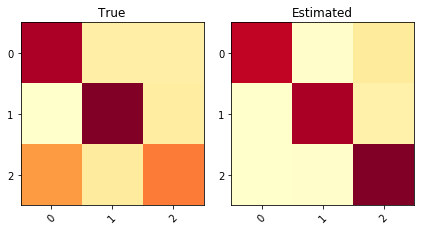

KL divergence: 0.8424	Pearson Correlation between diagonals: -0.8309


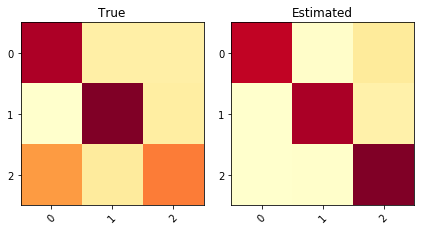

KL divergence: 0.8438	Pearson Correlation between diagonals: -0.8317


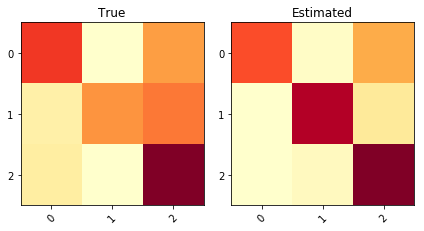

KL divergence: 0.3671	Pearson Correlation between diagonals: 0.3983


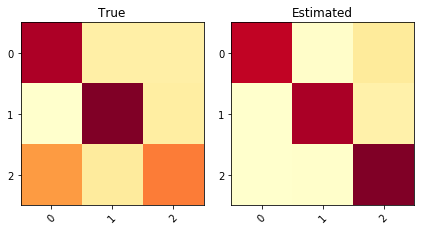

KL divergence: 0.8434	Pearson Correlation between diagonals: -0.8315


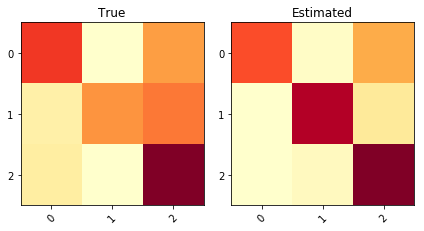

KL divergence: 0.3671	Pearson Correlation between diagonals: 0.3982


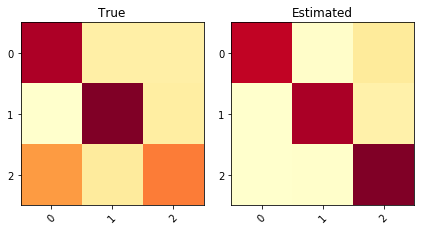

KL divergence: 0.8438	Pearson Correlation between diagonals: -0.8317


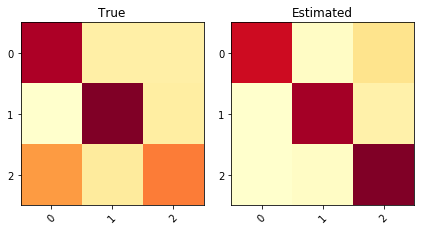

KL divergence: 0.6729	Pearson Correlation between diagonals: -0.6856


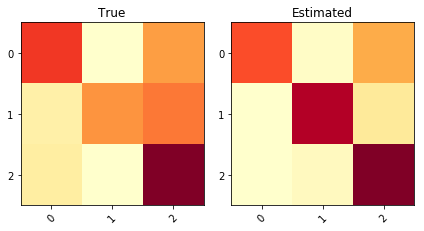

KL divergence: 0.3671	Pearson Correlation between diagonals: 0.3982


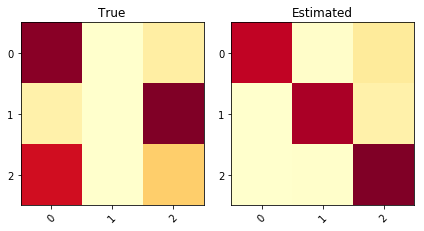

KL divergence: 2.3529	Pearson Correlation between diagonals: -0.5922


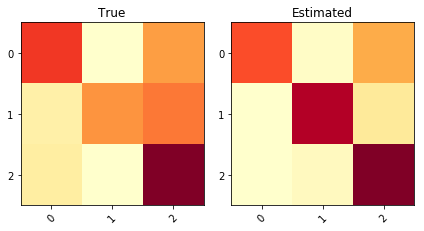

KL divergence: 0.3671	Pearson Correlation between diagonals: 0.3982


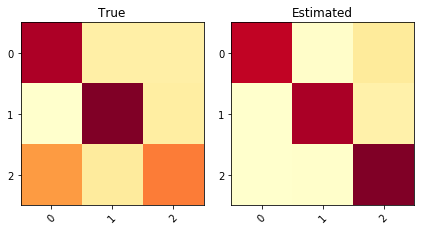

KL divergence: 0.8438	Pearson Correlation between diagonals: -0.8317


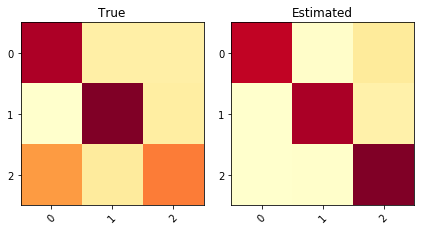

KL divergence: 0.8438	Pearson Correlation between diagonals: -0.8317


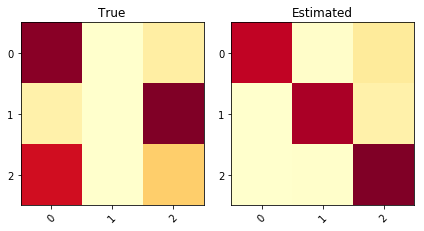

KL divergence: 2.3529	Pearson Correlation between diagonals: -0.5922


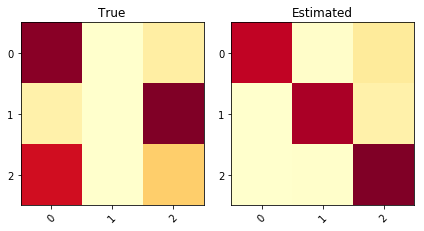

KL divergence: 2.3529	Pearson Correlation between diagonals: -0.5922


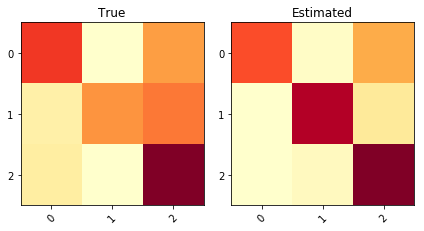

KL divergence: 0.3671	Pearson Correlation between diagonals: 0.3982
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.858364      0.858364   0.858107   0.108589           -0.099296
====  ======  ==========  ============  =========  =========  ==================


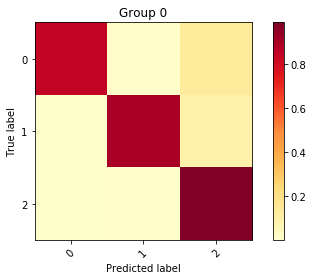

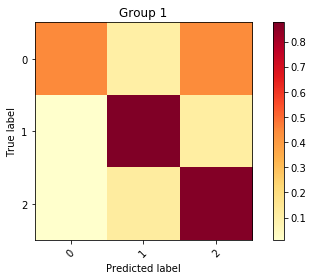

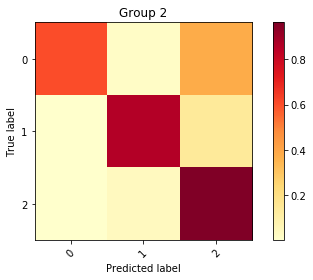

Inertia: 0.024773743469268084
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  ======  =========  ===========  =========  =============  =========
   0         0  0.538111       53   0.279554     0.915234  0.0905374       0.955587   0.872851
   1         1  0.0647703       6   0.59946      0.730951  0.358414        0.837495   0.596427
   2         2  0.397119       39   0.440096     0.808642  0.231498        0.891019   0.712963
====  ========  =========  ======  =========  ===========  =========  =============  =========


In [32]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc model

In [33]:
from  scipy.stats import entropy
def distance_function(predicted,ob): # to cluster
    return -predicted*np.log(ob) #without sum -- over 90 = 6 -- over 90 = 3 (lambda=1)

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.002327 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5172861  0.94071734 0.93640435]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.40 sec)	logL: -27016.502	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25495.567	Tol1: 0.05630	Tol2: 0.56927	Tol3: 0.08534	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24762.361	Tol1: 0.02876	Tol2: 0.26348	Tol3: 0.03825	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24404.904	Tol1: 0.01444	Tol2: 0.15499	Tol3: 0.02364	
Iter 5/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -24203.229	Tol1: 0.00826	Tol2: 0.11700	Tol3: 0.01537	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24072.477	Tol1: 0.00540	Tol2: 0.09323	Tol3: 0.01148	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	log

M step: done,  E step: done //  (in 0.16 sec)	logL: -21182.205	Tol1: 0.00626	Tol2: 0.04464	Tol3: 0.01001	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21066.275	Tol1: 0.00547	Tol2: 0.03983	Tol3: 0.01004	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20966.146	Tol1: 0.00475	Tol2: 0.04051	Tol3: 0.01061	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20873.341	Tol1: 0.00443	Tol2: 0.04227	Tol3: 0.01072	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20783.878	Tol1: 0.00429	Tol2: 0.04379	Tol3: 0.01070	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20696.355	Tol1: 0.00421	Tol2: 0.04368	Tol3: 0.01184	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20623.449	Tol1: 0.00352	Tol2: 0.04781	Tol3: 0.01175	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20551.131	Tol1: 0.00351	Tol2: 0.04989	Tol3: 0.01224	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20477.631	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -24115.070	Tol1: 0.01568	Tol2: 0.17171	Tol3: 0.01103	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23792.788	Tol1: 0.01336	Tol2: 0.13429	Tol3: 0.01062	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23495.645	Tol1: 0.01249	Tol2: 0.11710	Tol3: 0.01070	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23226.719	Tol1: 0.01145	Tol2: 0.10736	Tol3: 0.00963	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22971.599	Tol1: 0.01098	Tol2: 0.10192	Tol3: 0.00832	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22739.841	Tol1: 0.01009	Tol2: 0.09755	Tol3: 0.00658	
Iter 9/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -22529.271	Tol1: 0.00926	Tol2: 0.09229	Tol3: 0.00487	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22337.948	Tol1: 0.00849	Tol2: 0.08584	Tol3: 0.00320	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22163.099	Tol1: 0

M step: done,  E step: done //  (in 0.15 sec)	logL: -20775.389	Tol1: 0.00034	Tol2: 0.02938	Tol3: 0.00047	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.002375 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.20337977 0.80545115 0.22855508]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 14.07 sec)	logL: -28281.052	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -27243.018	Tol1: 0.03670	Tol2: 0.53638	Tol3: 0.06757	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -26452.483	Tol1: 0.02902	Tol2: 0.29051	Tol3: 0.04683	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25812.988	Tol1: 0.02418	Tol2: 0.20211	Tol3: 0.03777	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25311.909	Tol1: 0.01941	Tol2: 0.15499	Tol3: 0.02924	
Iter 6/50
M step: done,  E step: done //  (in 0.16

M step: done,  E step: done //  (in 0.16 sec)	logL: -20285.330	Tol1: 0.00452	Tol2: 0.04417	Tol3: 0.01277	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20209.239	Tol1: 0.00375	Tol2: 0.04235	Tol3: 0.01065	
Iter 23/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20137.570	Tol1: 0.00355	Tol2: 0.04035	Tol3: 0.01043	
Iter 24/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20081.895	Tol1: 0.00276	Tol2: 0.03895	Tol3: 0.00917	
Iter 25/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20037.414	Tol1: 0.00221	Tol2: 0.03811	Tol3: 0.00899	
Iter 26/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19992.663	Tol1: 0.00223	Tol2: 0.03779	Tol3: 0.00956	
Iter 27/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19960.270	Tol1: 0.00162	Tol2: 0.03807	Tol3: 0.00855	
Iter 28/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19937.066	Tol1: 0.00116	Tol2: 0.03737	Tol3: 0.00821	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19918.161	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -22494.303	Tol1: 0.01065	Tol2: 0.09073	Tol3: 0.00428	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22277.728	Tol1: 0.00963	Tol2: 0.08451	Tol3: 0.00569	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22081.745	Tol1: 0.00880	Tol2: 0.07533	Tol3: 0.00674	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21905.432	Tol1: 0.00798	Tol2: 0.06660	Tol3: 0.00784	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21753.030	Tol1: 0.00696	Tol2: 0.05727	Tol3: 0.00858	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21616.139	Tol1: 0.00629	Tol2: 0.04816	Tol3: 0.00887	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21492.477	Tol1: 0.00572	Tol2: 0.04084	Tol3: 0.00931	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21387.360	Tol1: 0.00489	Tol2: 0.03417	Tol3: 0.00987	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21288.897	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -22578.833	Tol1: 0.01323	Tol2: 0.10963	Tol3: 0.01172	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22313.829	Tol1: 0.01174	Tol2: 0.10436	Tol3: 0.01204	
Iter 9/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22080.509	Tol1: 0.01046	Tol2: 0.09718	Tol3: 0.01194	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21879.887	Tol1: 0.00909	Tol2: 0.08904	Tol3: 0.01195	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21706.675	Tol1: 0.00792	Tol2: 0.07926	Tol3: 0.01158	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21557.767	Tol1: 0.00686	Tol2: 0.06866	Tol3: 0.01073	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21430.589	Tol1: 0.00590	Tol2: 0.05984	Tol3: 0.01008	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21325.265	Tol1: 0.00491	Tol2: 0.05134	Tol3: 0.00937	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21239.052	Tol

M step: done,  E step: done //  (in 0.20 sec)	logL: -19954.678	Tol1: 0.00157	Tol2: 0.03962	Tol3: 0.00385	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19929.272	Tol1: 0.00127	Tol2: 0.03655	Tol3: 0.00415	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19900.142	Tol1: 0.00146	Tol2: 0.03386	Tol3: 0.00287	
Iter 42/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19875.058	Tol1: 0.00126	Tol2: 0.03333	Tol3: 0.00292	
Iter 43/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19854.085	Tol1: 0.00106	Tol2: 0.03158	Tol3: 0.00299	
Iter 44/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19833.404	Tol1: 0.00104	Tol2: 0.02898	Tol3: 0.00203	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.002309 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.85036653 0.13171443 0.52443725]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter

M step: done,  E step: done //  (in 0.15 sec)	logL: -21976.574	Tol1: 0.00812	Tol2: 0.05959	Tol3: 0.01331	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21797.483	Tol1: 0.00815	Tol2: 0.05700	Tol3: 0.01384	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21623.511	Tol1: 0.00798	Tol2: 0.05436	Tol3: 0.01456	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21457.147	Tol1: 0.00769	Tol2: 0.05195	Tol3: 0.01522	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21302.231	Tol1: 0.00722	Tol2: 0.04924	Tol3: 0.01531	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21155.262	Tol1: 0.00690	Tol2: 0.04740	Tol3: 0.01558	
Iter 22/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21020.710	Tol1: 0.00636	Tol2: 0.04455	Tol3: 0.01577	
Iter 23/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20890.822	Tol1: 0.00618	Tol2: 0.04188	Tol3: 0.01613	
Iter 24/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -20779.771	T

M step: done,  E step: done //  (in 0.22 sec)	logL: -23637.306	Tol1: 0.01376	Tol2: 0.11327	Tol3: 0.00376	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23320.098	Tol1: 0.01342	Tol2: 0.10905	Tol3: 0.00451	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23026.966	Tol1: 0.01257	Tol2: 0.11068	Tol3: 0.00482	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22759.193	Tol1: 0.01163	Tol2: 0.11197	Tol3: 0.00472	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22504.713	Tol1: 0.01118	Tol2: 0.10962	Tol3: 0.00490	
Iter 10/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22271.733	Tol1: 0.01035	Tol2: 0.10474	Tol3: 0.00600	
Iter 11/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22068.791	Tol1: 0.00911	Tol2: 0.09610	Tol3: 0.00658	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21881.567	Tol1: 0.00848	Tol2: 0.08427	Tol3: 0.00671	
Iter 13/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21724.264	Tol1:

M step: done,  E step: done //  (in 0.16 sec)	logL: -20700.152	Tol1: 0.00288	Tol2: 0.03706	Tol3: 0.00356	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20641.084	Tol1: 0.00285	Tol2: 0.03821	Tol3: 0.00310	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20591.298	Tol1: 0.00241	Tol2: 0.04195	Tol3: 0.00301	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20542.027	Tol1: 0.00239	Tol2: 0.04366	Tol3: 0.00355	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20493.130	Tol1: 0.00238	Tol2: 0.04521	Tol3: 0.00385	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20452.934	Tol1: 0.00196	Tol2: 0.04790	Tol3: 0.00299	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20415.072	Tol1: 0.00185	Tol2: 0.04749	Tol3: 0.00317	
Iter 26/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20375.424	Tol1: 0.00194	Tol2: 0.04597	Tol3: 0.00279	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20342.750	T

M step: done,  E step: done //  (in 15.39 sec)	logL: -26472.273	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -25257.048	Tol1: 0.04591	Tol2: 0.42690	Tol3: 0.14249	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24681.463	Tol1: 0.02279	Tol2: 0.17528	Tol3: 0.03769	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24190.183	Tol1: 0.01990	Tol2: 0.11286	Tol3: 0.02543	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23739.294	Tol1: 0.01864	Tol2: 0.09397	Tol3: 0.02161	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23313.915	Tol1: 0.01792	Tol2: 0.09575	Tol3: 0.02022	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22905.100	Tol1: 0.01754	Tol2: 0.09763	Tol3: 0.01968	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22523.695	Tol1: 0.01665	Tol2: 0.09958	Tol3: 0.01969	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22152.839	Tol1: 0.01647	Tol2: 0.09915	Tol3: 0.01899	
Iter 10

M step: done,  E step: done //  (in 0.25 sec)	logL: -21875.248	Tol1: 0.00226	Tol2: 0.03515	Tol3: 0.00135	
Iter 31/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21822.840	Tol1: 0.00240	Tol2: 0.03514	Tol3: 0.00176	
Iter 32/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21771.509	Tol1: 0.00235	Tol2: 0.03482	Tol3: 0.00235	
Iter 33/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21721.346	Tol1: 0.00230	Tol2: 0.03430	Tol3: 0.00285	
Iter 34/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21665.564	Tol1: 0.00257	Tol2: 0.03438	Tol3: 0.00307	
Iter 35/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21609.819	Tol1: 0.00257	Tol2: 0.03443	Tol3: 0.00370	
Iter 36/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21552.073	Tol1: 0.00267	Tol2: 0.03396	Tol3: 0.00412	
Iter 37/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21489.581	Tol1: 0.00290	Tol2: 0.03369	Tol3: 0.00446	
Iter 38/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21424.947	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -20714.363	Tol1: 0.00460	Tol2: 0.04708	Tol3: 0.01450	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20623.705	Tol1: 0.00438	Tol2: 0.04575	Tol3: 0.01445	
Iter 22/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20541.827	Tol1: 0.00397	Tol2: 0.04632	Tol3: 0.01404	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20466.230	Tol1: 0.00368	Tol2: 0.04882	Tol3: 0.01305	
Iter 24/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20396.602	Tol1: 0.00340	Tol2: 0.04977	Tol3: 0.01241	
Iter 25/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20333.231	Tol1: 0.00311	Tol2: 0.05269	Tol3: 0.01127	
Iter 26/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20276.346	Tol1: 0.00280	Tol2: 0.05223	Tol3: 0.01069	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20224.469	Tol1: 0.00256	Tol2: 0.05390	Tol3: 0.00918	
Iter 28/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20178.831	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -21210.643	Tol1: 0.00548	Tol2: 0.06309	Tol3: 0.00644	
Iter 18/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21125.343	Tol1: 0.00402	Tol2: 0.05744	Tol3: 0.00450	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21070.355	Tol1: 0.00260	Tol2: 0.05296	Tol3: 0.00258	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21032.115	Tol1: 0.00181	Tol2: 0.05037	Tol3: 0.00098	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21001.550	Tol1: 0.00145	Tol2: 0.04781	Tol3: 0.00101	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20979.379	Tol1: 0.00106	Tol2: 0.04420	Tol3: 0.00142	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20959.615	Tol1: 0.00094	Tol2: 0.04055	Tol3: 0.00191	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20941.789	Tol1: 0.00085	Tol2: 0.03716	Tol3: 0.00272	
Iter 25/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20924.276	T

M step: done,  E step: done //  (in 0.31 sec)	logL: -25174.851	Tol1: 0.01143	Tol2: 0.11675	Tol3: 0.00367	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24898.797	Tol1: 0.01097	Tol2: 0.08068	Tol3: 0.00202	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24613.908	Tol1: 0.01144	Tol2: 0.06992	Tol3: 0.00088	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24323.875	Tol1: 0.01178	Tol2: 0.07082	Tol3: 0.00214	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24017.977	Tol1: 0.01258	Tol2: 0.07721	Tol3: 0.00423	
Iter 9/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23704.805	Tol1: 0.01304	Tol2: 0.08385	Tol3: 0.00564	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23385.041	Tol1: 0.01349	Tol2: 0.08965	Tol3: 0.00717	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23061.231	Tol1: 0.01385	Tol2: 0.09565	Tol3: 0.00851	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22749.015	Tol1: 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3117805  0.01496793 0.95610166]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.59 sec)	logL: -27275.624	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -26363.009	Tol1: 0.03346	Tol2: 0.48886	Tol3: 0.10332	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25804.145	Tol1: 0.02120	Tol2: 0.25287	Tol3: 0.03199	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25328.218	Tol1: 0.01844	Tol2: 0.17789	Tol3: 0.02199	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24887.424	Tol1: 0.01740	Tol2: 0.13187	Tol3: 0.01782	
Iter 6/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -24475.045	Tol1: 0.01657	Tol2: 0.10443	Tol3: 0.01613	
Iter 7/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24067.308	Tol1: 0.01666	Tol2: 0.09464	Tol3: 0.01545	
Iter 8/50
M step: done,  E step: done //  (in 0.22 sec)	

M step: done,  E step: done //  (in 0.18 sec)	logL: -22202.242	Tol1: 0.01136	Tol2: 0.12268	Tol3: 0.00421	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21975.677	Tol1: 0.01020	Tol2: 0.11358	Tol3: 0.00328	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21770.869	Tol1: 0.00932	Tol2: 0.10403	Tol3: 0.00387	
Iter 11/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21586.965	Tol1: 0.00845	Tol2: 0.09519	Tol3: 0.00511	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21421.089	Tol1: 0.00768	Tol2: 0.08700	Tol3: 0.00623	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21280.195	Tol1: 0.00658	Tol2: 0.07944	Tol3: 0.00732	
Iter 14/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21151.678	Tol1: 0.00604	Tol2: 0.07390	Tol3: 0.00856	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21041.041	Tol1: 0.00523	Tol2: 0.06794	Tol3: 0.00997	
Iter 16/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20934.803	To

M step: done,  E step: done //  (in 0.22 sec)	logL: -23309.053	Tol1: 0.01672	Tol2: 0.11931	Tol3: 0.02935	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22905.285	Tol1: 0.01732	Tol2: 0.11576	Tol3: 0.02718	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22514.562	Tol1: 0.01706	Tol2: 0.11656	Tol3: 0.02836	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22143.935	Tol1: 0.01646	Tol2: 0.11706	Tol3: 0.02954	
Iter 9/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21788.788	Tol1: 0.01604	Tol2: 0.11428	Tol3: 0.02995	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21467.817	Tol1: 0.01473	Tol2: 0.10853	Tol3: 0.03004	
Iter 11/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21173.514	Tol1: 0.01371	Tol2: 0.09848	Tol3: 0.02814	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20936.729	Tol1: 0.01118	Tol2: 0.08649	Tol3: 0.02605	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20730.050	Tol1:

M step: done,  E step: done //  (in 0.18 sec)	logL: -19820.822	Tol1: 0.00064	Tol2: 0.02945	Tol3: 0.00636	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.002866 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5745338  0.05977431 0.0704249 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 16.29 sec)	logL: -26821.875	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24332.669	Tol1: 0.09281	Tol2: 0.63202	Tol3: 0.19446	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23634.352	Tol1: 0.02870	Tol2: 0.28033	Tol3: 0.08069	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23256.845	Tol1: 0.01597	Tol2: 0.18246	Tol3: 0.04458	
Iter 5/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -22963.369	Tol1: 0.01262	Tol2: 0.13833	Tol3: 0.02828	
Iter 6/50
M step: done,  E step: done //  (in 0.18

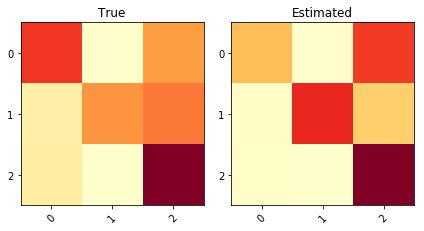

KL divergence: 0.1599	Pearson Correlation between diagonals: 0.5368


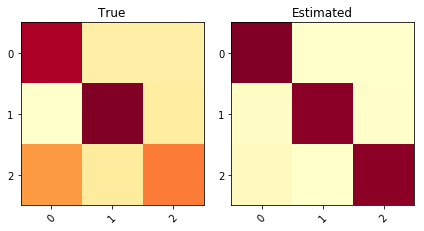

KL divergence: 0.5717	Pearson Correlation between diagonals: 0.4824


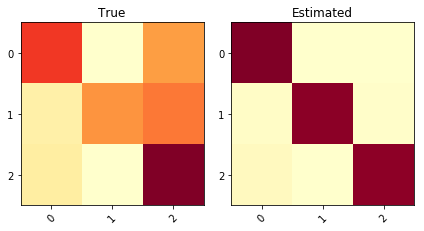

KL divergence: 1.0339	Pearson Correlation between diagonals: -0.2963


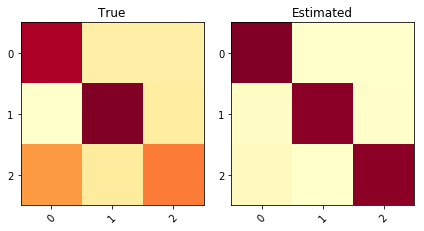

KL divergence: 0.5717	Pearson Correlation between diagonals: 0.4824


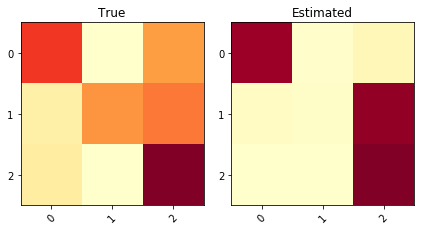

KL divergence: 0.6250	Pearson Correlation between diagonals: 0.8275


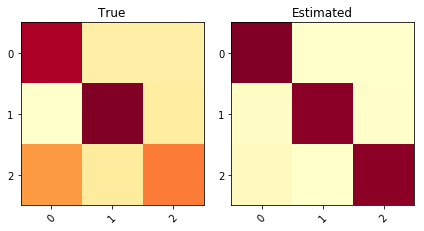

KL divergence: 0.5717	Pearson Correlation between diagonals: 0.4824


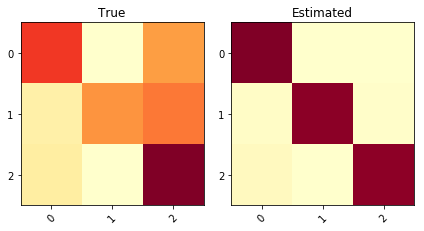

KL divergence: 1.0339	Pearson Correlation between diagonals: -0.2963


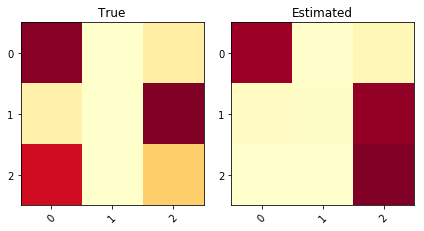

KL divergence: 1.2004	Pearson Correlation between diagonals: 0.6843


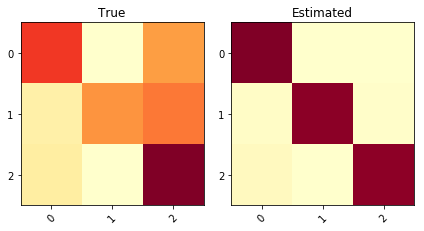

KL divergence: 1.0339	Pearson Correlation between diagonals: -0.2963


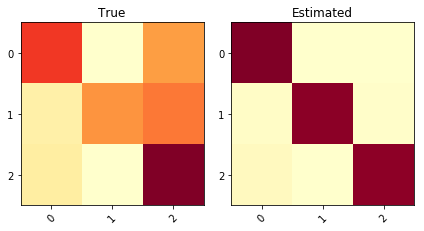

KL divergence: 1.0297	Pearson Correlation between diagonals: -0.2954


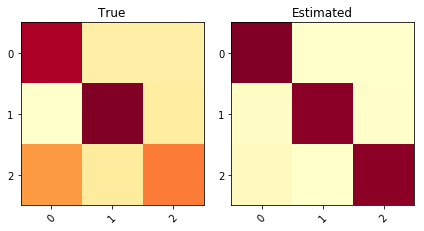

KL divergence: 0.5717	Pearson Correlation between diagonals: 0.4824


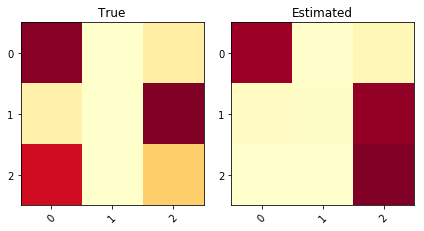

KL divergence: 1.2004	Pearson Correlation between diagonals: 0.6843


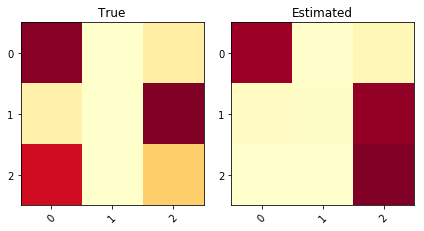

KL divergence: 1.2004	Pearson Correlation between diagonals: 0.6843


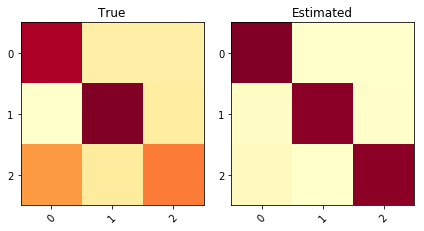

KL divergence: 0.5717	Pearson Correlation between diagonals: 0.4824


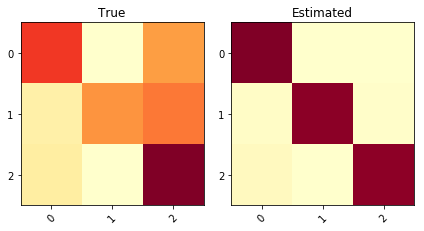

KL divergence: 1.0332	Pearson Correlation between diagonals: -0.2950
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.876272      0.876272    0.83472   0.105273            0.312341
====  ======  ==========  ============  =========  =========  ==================


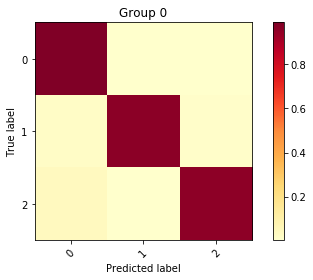

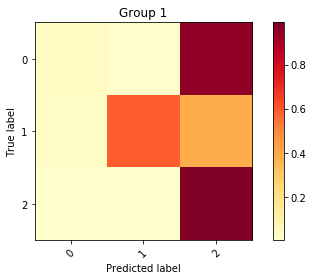

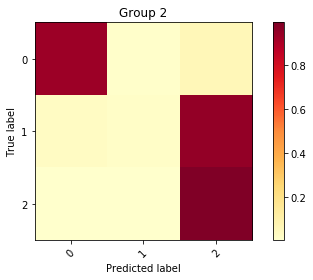

Inertia: 0.23327377686897913
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.386835      38   0.13238      0.972937  0.0275215       0.986305   0.959406
   1         1  0.190635      19   0.339799     0.538897  1.30611         0.620237   0.308346
   2         2  0.42253       42   0.172721     0.648214  1.38694         0.674949   0.472321
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [34]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc model

In [35]:
def distance_function(predicted,ob): # to cluster
    return [entropy(predicted, qk=ob)] #over 90 = 5-6 -- no son tan buenos pero encunetra 3
    

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.005533 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8420627  0.3552974  0.40967965]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 16.10 sec)	logL: -24584.934	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23761.743	Tol1: 0.03348	Tol2: 0.21634	Tol3: 0.01528	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23290.186	Tol1: 0.01985	Tol2: 0.11425	Tol3: 0.00872	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22875.791	Tol1: 0.01779	Tol2: 0.10048	Tol3: 0.00952	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22480.600	Tol1: 0.01728	Tol2: 0.10607	Tol3: 0.01012	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22113.575	Tol1: 0.01633	Tol2: 0.11067	Tol3: 0.01018	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	log

M step: done,  E step: done //  (in 0.18 sec)	logL: -27454.408	Tol1: 0.06244	Tol2: 0.37002	Tol3: 0.17139	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -26184.497	Tol1: 0.04626	Tol2: 0.28672	Tol3: 0.14018	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25316.654	Tol1: 0.03314	Tol2: 0.23035	Tol3: 0.11620	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24697.082	Tol1: 0.02447	Tol2: 0.19154	Tol3: 0.09692	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24223.842	Tol1: 0.01916	Tol2: 0.16527	Tol3: 0.08151	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23838.714	Tol1: 0.01590	Tol2: 0.14695	Tol3: 0.06892	
Iter 10/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23510.640	Tol1: 0.01376	Tol2: 0.13372	Tol3: 0.05841	
Iter 11/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23222.459	Tol1: 0.01226	Tol2: 0.12322	Tol3: 0.04922	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22974.754	Tol1: 

M step: done,  E step: done //  (in 0.17 sec)	logL: -20441.870	Tol1: 0.00613	Tol2: 0.05605	Tol3: 0.00755	
Iter 21/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20324.197	Tol1: 0.00576	Tol2: 0.05246	Tol3: 0.00691	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20230.431	Tol1: 0.00461	Tol2: 0.04755	Tol3: 0.00627	
Iter 23/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20159.793	Tol1: 0.00349	Tol2: 0.04260	Tol3: 0.00580	
Iter 24/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20099.610	Tol1: 0.00299	Tol2: 0.03855	Tol3: 0.00553	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20043.848	Tol1: 0.00277	Tol2: 0.03707	Tol3: 0.00477	
Iter 26/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20004.166	Tol1: 0.00198	Tol2: 0.03346	Tol3: 0.00412	
Iter 27/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19968.679	Tol1: 0.00177	Tol2: 0.03137	Tol3: 0.00415	
Iter 28/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -19942.096	T

M step: done,  E step: done //  (in 0.31 sec)	logL: -20793.109	Tol1: 0.00354	Tol2: 0.03618	Tol3: 0.00735	
Iter 24/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -20724.462	Tol1: 0.00330	Tol2: 0.03402	Tol3: 0.00684	
Iter 25/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20663.019	Tol1: 0.00296	Tol2: 0.03242	Tol3: 0.00616	
Iter 26/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20609.774	Tol1: 0.00258	Tol2: 0.03152	Tol3: 0.00572	
Iter 27/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20562.556	Tol1: 0.00229	Tol2: 0.03051	Tol3: 0.00581	
Iter 28/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20512.771	Tol1: 0.00242	Tol2: 0.02958	Tol3: 0.00539	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.005749 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36902833 0.00116054 0.5499561 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter

M step: done,  E step: done //  (in 0.17 sec)	logL: -22278.252	Tol1: 0.01148	Tol2: 0.04724	Tol3: 0.01581	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22020.001	Tol1: 0.01159	Tol2: 0.04785	Tol3: 0.01645	
Iter 14/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21775.409	Tol1: 0.01111	Tol2: 0.05078	Tol3: 0.01688	
Iter 15/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21546.310	Tol1: 0.01052	Tol2: 0.05308	Tol3: 0.01672	
Iter 16/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21335.867	Tol1: 0.00977	Tol2: 0.05506	Tol3: 0.01594	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21151.154	Tol1: 0.00866	Tol2: 0.05653	Tol3: 0.01463	
Iter 18/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20986.955	Tol1: 0.00776	Tol2: 0.05422	Tol3: 0.01276	
Iter 19/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20853.288	Tol1: 0.00637	Tol2: 0.05477	Tol3: 0.01022	
Iter 20/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20736.587	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -21033.602	Tol1: 0.00836	Tol2: 0.06478	Tol3: 0.00775	
Iter 23/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20868.245	Tol1: 0.00786	Tol2: 0.06031	Tol3: 0.00730	
Iter 24/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20714.388	Tol1: 0.00737	Tol2: 0.05835	Tol3: 0.00644	
Iter 25/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20579.622	Tol1: 0.00651	Tol2: 0.05463	Tol3: 0.00537	
Iter 26/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20461.163	Tol1: 0.00576	Tol2: 0.05210	Tol3: 0.00458	
Iter 27/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20356.739	Tol1: 0.00510	Tol2: 0.04818	Tol3: 0.00420	
Iter 28/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20260.577	Tol1: 0.00472	Tol2: 0.04438	Tol3: 0.00353	
Iter 29/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20184.515	Tol1: 0.00375	Tol2: 0.04066	Tol3: 0.00320	
Iter 30/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20117.352	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -21346.964	Tol1: 0.00753	Tol2: 0.08872	Tol3: 0.00525	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21214.352	Tol1: 0.00621	Tol2: 0.08009	Tol3: 0.00407	
Iter 20/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21100.494	Tol1: 0.00537	Tol2: 0.07001	Tol3: 0.00316	
Iter 21/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20998.079	Tol1: 0.00485	Tol2: 0.06010	Tol3: 0.00238	
Iter 22/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20906.608	Tol1: 0.00436	Tol2: 0.05015	Tol3: 0.00257	
Iter 23/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20826.458	Tol1: 0.00383	Tol2: 0.04120	Tol3: 0.00214	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20753.373	Tol1: 0.00351	Tol2: 0.03386	Tol3: 0.00223	
Iter 25/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20689.453	Tol1: 0.00308	Tol2: 0.02737	Tol3: 0.00195	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!

M step: done,  E step: done //  (in 0.22 sec)	logL: -20177.597	Tol1: 0.00208	Tol2: 0.02847	Tol3: 0.00207	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.005571 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.50013465 0.5503243  0.8692576 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 19.80 sec)	logL: -24034.918	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23437.480	Tol1: 0.02486	Tol2: 0.18599	Tol3: 0.01793	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23020.089	Tol1: 0.01781	Tol2: 0.10829	Tol3: 0.01251	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22581.481	Tol1: 0.01905	Tol2: 0.11366	Tol3: 0.01224	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22141.537	Tol1: 0.01948	Tol2: 0.12226	Tol3: 0.01237	
Iter 6/50
M step: done,  E step: done //  (in 0.18

M step: done,  E step: done //  (in 0.22 sec)	logL: -25995.956	Tol1: 0.09886	Tol2: 0.62180	Tol3: 0.04346	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25178.609	Tol1: 0.03144	Tol2: 0.20635	Tol3: 0.03878	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24822.717	Tol1: 0.01413	Tol2: 0.09392	Tol3: 0.01327	
Iter 5/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24527.163	Tol1: 0.01191	Tol2: 0.06027	Tol3: 0.00284	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24239.384	Tol1: 0.01173	Tol2: 0.04808	Tol3: 0.00073	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23952.252	Tol1: 0.01185	Tol2: 0.04734	Tol3: 0.00056	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23645.810	Tol1: 0.01279	Tol2: 0.06122	Tol3: 0.00043	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23330.248	Tol1: 0.01335	Tol2: 0.07552	Tol3: 0.00093	
Iter 10/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22997.188	Tol1: 0.

M step: done,  E step: done //  (in 0.19 sec)	logL: -19988.055	Tol1: 0.00163	Tol2: 0.02543	Tol3: 0.00375	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.005755 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.06978603 0.56758356 0.10195197]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 20.71 sec)	logL: -25124.999	
Iter 2/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -24275.505	Tol1: 0.03381	Tol2: 0.36853	Tol3: 0.00428	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23729.300	Tol1: 0.02250	Tol2: 0.25380	Tol3: 0.01916	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23333.996	Tol1: 0.01666	Tol2: 0.17618	Tol3: 0.01804	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23026.044	Tol1: 0.01320	Tol2: 0.12059	Tol3: 0.01169	
Iter 6/50
M step: done,  E step: done //  (in 0.23

M step: done,  E step: done //  (in 0.18 sec)	logL: -22919.500	Tol1: 0.01322	Tol2: 0.08315	Tol3: 0.01265	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22634.688	Tol1: 0.01243	Tol2: 0.08394	Tol3: 0.01115	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22370.871	Tol1: 0.01166	Tol2: 0.08302	Tol3: 0.00945	
Iter 11/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22130.903	Tol1: 0.01073	Tol2: 0.08249	Tol3: 0.00764	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21908.114	Tol1: 0.01007	Tol2: 0.08159	Tol3: 0.00625	
Iter 13/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21708.579	Tol1: 0.00911	Tol2: 0.07872	Tol3: 0.00517	
Iter 14/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21521.498	Tol1: 0.00862	Tol2: 0.07344	Tol3: 0.00433	
Iter 15/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21354.300	Tol1: 0.00777	Tol2: 0.06551	Tol3: 0.00404	
Iter 16/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21211.177	To

M step: done,  E step: done //  (in 0.19 sec)	logL: -21284.310	Tol1: 0.00651	Tol2: 0.04746	Tol3: 0.00335	
Iter 20/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21165.357	Tol1: 0.00559	Tol2: 0.04283	Tol3: 0.00296	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21057.318	Tol1: 0.00510	Tol2: 0.03640	Tol3: 0.00256	
Iter 22/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20974.448	Tol1: 0.00394	Tol2: 0.03083	Tol3: 0.00200	
Iter 23/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20903.968	Tol1: 0.00336	Tol2: 0.02332	Tol3: 0.00134	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.005388 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6153302  0.881443   0.20083864]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 20.77 sec)	logL: -27117.392	
Iter 2/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.21 sec)	logL: -24304.697	Tol1: 0.01756	Tol2: 0.09279	Tol3: 0.00727	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23927.471	Tol1: 0.01552	Tol2: 0.06534	Tol3: 0.00385	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23570.749	Tol1: 0.01491	Tol2: 0.05450	Tol3: 0.00199	
Iter 7/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23224.238	Tol1: 0.01470	Tol2: 0.06280	Tol3: 0.00567	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22873.385	Tol1: 0.01511	Tol2: 0.07450	Tol3: 0.00861	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22538.653	Tol1: 0.01463	Tol2: 0.08235	Tol3: 0.01074	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22216.217	Tol1: 0.01431	Tol2: 0.08484	Tol3: 0.01185	
Iter 11/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21912.992	Tol1: 0.01365	Tol2: 0.08316	Tol3: 0.01205	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21628.152	Tol1: 

M step: done,  E step: done //  (in 22.92 sec)	logL: -25981.493	
Iter 2/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -24993.852	Tol1: 0.03801	Tol2: 0.26696	Tol3: 0.02993	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24391.859	Tol1: 0.02409	Tol2: 0.14724	Tol3: 0.02789	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23907.423	Tol1: 0.01986	Tol2: 0.11320	Tol3: 0.02734	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23496.625	Tol1: 0.01718	Tol2: 0.10852	Tol3: 0.02766	
Iter 6/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23123.737	Tol1: 0.01587	Tol2: 0.10774	Tol3: 0.02793	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22789.970	Tol1: 0.01443	Tol2: 0.10698	Tol3: 0.02821	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22484.072	Tol1: 0.01342	Tol2: 0.10440	Tol3: 0.02763	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22204.160	Tol1: 0.01245	Tol2: 0.10041	Tol3: 0.02728	
Iter 10

M step: done,  E step: done //  (in 0.22 sec)	logL: -25302.082	Tol1: 0.01817	Tol2: 0.10703	Tol3: 0.02154	
Iter 5/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24946.036	Tol1: 0.01407	Tol2: 0.07694	Tol3: 0.01610	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24676.036	Tol1: 0.01082	Tol2: 0.05424	Tol3: 0.01160	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24456.633	Tol1: 0.00889	Tol2: 0.03858	Tol3: 0.00742	
Iter 8/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24274.288	Tol1: 0.00746	Tol2: 0.02866	Tol3: 0.00321	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.005295 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6097811  0.12169649 0.59289277]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 21.01 sec)	logL: -26461.432	
Iter 2/50
M step: done,  E step: done //  (in 0.25

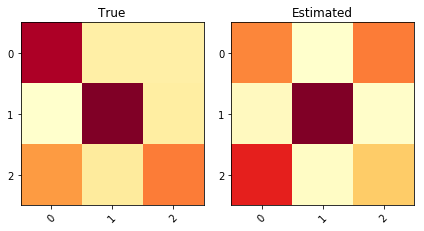

KL divergence: 0.1812	Pearson Correlation between diagonals: 0.8586


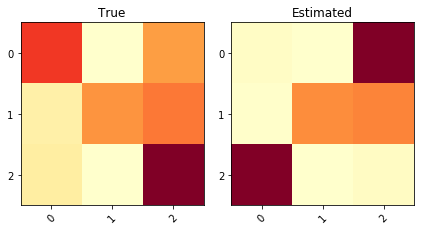

KL divergence: 1.5152	Pearson Correlation between diagonals: -0.7907


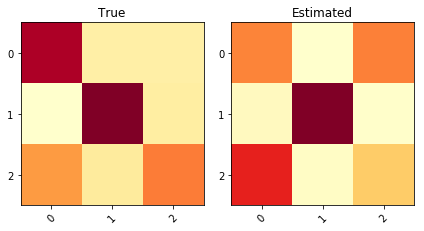

KL divergence: 0.1790	Pearson Correlation between diagonals: 0.8603


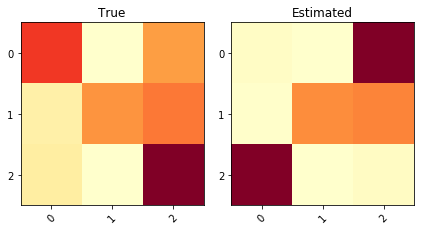

KL divergence: 1.5111	Pearson Correlation between diagonals: -0.7908


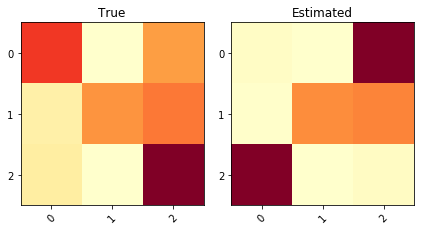

KL divergence: 1.5149	Pearson Correlation between diagonals: -0.7907


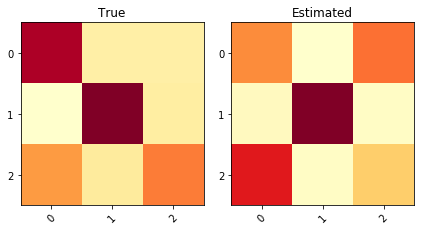

KL divergence: 0.1900	Pearson Correlation between diagonals: 0.8519


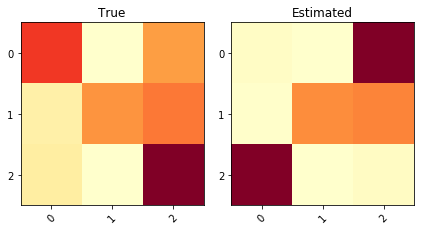

KL divergence: 1.5152	Pearson Correlation between diagonals: -0.7907


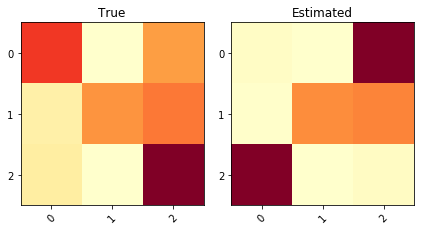

KL divergence: 1.5152	Pearson Correlation between diagonals: -0.7907


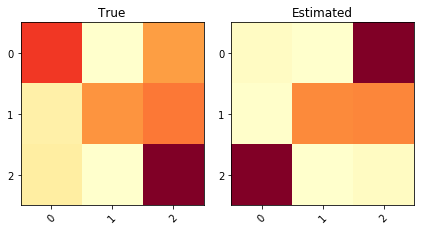

KL divergence: 1.4720	Pearson Correlation between diagonals: -0.7922


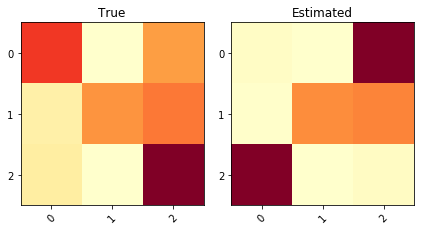

KL divergence: 1.4999	Pearson Correlation between diagonals: -0.7912


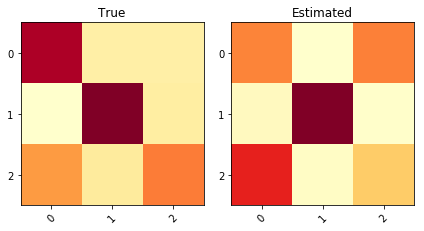

KL divergence: 0.1790	Pearson Correlation between diagonals: 0.8603


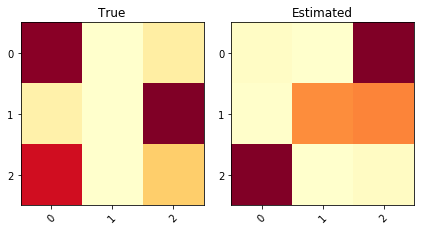

KL divergence: 1.3566	Pearson Correlation between diagonals: -0.7286


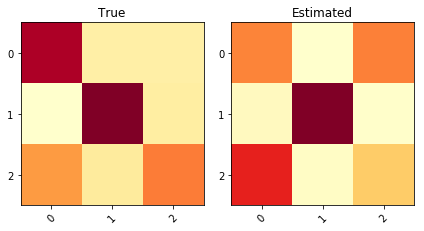

KL divergence: 0.1790	Pearson Correlation between diagonals: 0.8603


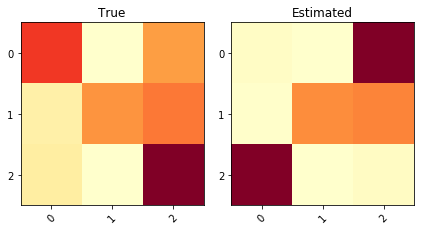

KL divergence: 1.5152	Pearson Correlation between diagonals: -0.7907


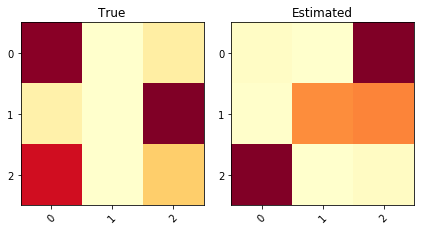

KL divergence: 1.3566	Pearson Correlation between diagonals: -0.7286
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.365893      0.365893      1.161   0.196831           -0.363183
====  ======  ==========  ============  =========  =========  ==================


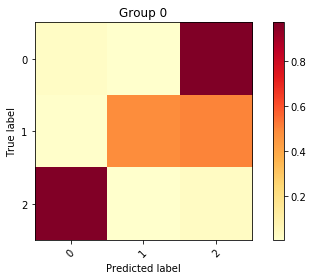

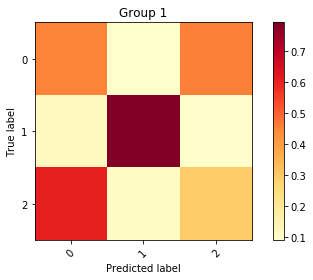

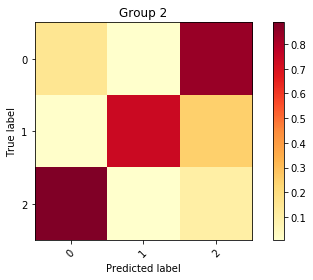

Inertia: 0.07727858734627564
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  ===========
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)      Spammer
====  ========  =========  ======  =========  ===========  =========  =============  ===========
   0         0  0.365155       36   0.347824     0.17939    2.65251        0.285331  -0.230916
   1         1  0.0645199       6   0.828962     0.512597   0.750847       0.678907   0.268896
   2         2  0.570325       57   0.488204     0.331531   1.4791         0.476525  -0.00270356
====  ========  =========  ======  =========  ===========  =========  =============  ===========


In [36]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc model

In [37]:
def distance_function(predicted,ob): # to cluster
    return -predicted*np.log(ob/predicted) #klwithoutsum --over 90 = 6 -- encuentra 3 grupos --over 90=7 (lambda=1)
    

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003016 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5948014  0.19571579 0.20402037]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 21.11 sec)	logL: -27065.645	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -25190.948	Tol1: 0.06926	Tol2: 0.53289	Tol3: 0.17832	
Iter 3/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -24519.570	Tol1: 0.02665	Tol2: 0.21713	Tol3: 0.07009	
Iter 4/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -24101.591	Tol1: 0.01705	Tol2: 0.13321	Tol3: 0.03975	
Iter 5/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -23734.790	Tol1: 0.01522	Tol2: 0.10431	Tol3: 0.02971	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23366.845	Tol1: 0.01550	Tol2: 0.09637	Tol3: 0.02696	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	log

M step: done,  E step: done //  (in 0.23 sec)	logL: -20052.280	Tol1: 0.00128	Tol2: 0.02763	Tol3: 0.00174	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.002449 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73804724 0.6824916  0.9111993 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 22.22 sec)	logL: -24558.753	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -23949.592	Tol1: 0.02480	Tol2: 0.35770	Tol3: 0.09621	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23537.099	Tol1: 0.01722	Tol2: 0.18635	Tol3: 0.01314	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23163.903	Tol1: 0.01586	Tol2: 0.14193	Tol3: 0.01265	
Iter 5/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22833.333	Tol1: 0.01427	Tol2: 0.12433	Tol3: 0.01165	
Iter 6/50
M step: done,  E step: done //  (in 0.20

M step: done,  E step: done //  (in 0.22 sec)	logL: -22490.006	Tol1: 0.01134	Tol2: 0.10925	Tol3: 0.00479	
Iter 8/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -22258.237	Tol1: 0.01031	Tol2: 0.10236	Tol3: 0.00584	
Iter 9/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22051.695	Tol1: 0.00928	Tol2: 0.09260	Tol3: 0.00691	
Iter 10/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21863.329	Tol1: 0.00854	Tol2: 0.08125	Tol3: 0.00772	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21694.285	Tol1: 0.00773	Tol2: 0.07118	Tol3: 0.00870	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21548.343	Tol1: 0.00673	Tol2: 0.06099	Tol3: 0.00959	
Iter 13/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21415.513	Tol1: 0.00616	Tol2: 0.05020	Tol3: 0.00993	
Iter 14/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21299.030	Tol1: 0.00544	Tol2: 0.04212	Tol3: 0.01020	
Iter 15/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21188.804	Tol

M step: done,  E step: done //  (in 0.20 sec)	logL: -20853.551	Tol1: 0.00258	Tol2: 0.05467	Tol3: 0.00761	
Iter 34/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20804.310	Tol1: 0.00236	Tol2: 0.05598	Tol3: 0.00769	
Iter 35/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20755.283	Tol1: 0.00236	Tol2: 0.05514	Tol3: 0.00783	
Iter 36/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20708.994	Tol1: 0.00223	Tol2: 0.05412	Tol3: 0.00802	
Iter 37/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20664.102	Tol1: 0.00217	Tol2: 0.05243	Tol3: 0.00802	
Iter 38/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20619.169	Tol1: 0.00217	Tol2: 0.04938	Tol3: 0.00800	
Iter 39/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20579.231	Tol1: 0.00194	Tol2: 0.04681	Tol3: 0.00803	
Iter 40/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20537.697	Tol1: 0.00202	Tol2: 0.04435	Tol3: 0.00769	
Iter 41/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20497.005	T

M step: done,  E step: done //  (in 23.11 sec)	logL: -26482.224	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25478.421	Tol1: 0.03790	Tol2: 0.38786	Tol3: 0.10946	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24992.937	Tol1: 0.01905	Tol2: 0.18680	Tol3: 0.03077	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24611.625	Tol1: 0.01526	Tol2: 0.11990	Tol3: 0.02018	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24280.799	Tol1: 0.01344	Tol2: 0.09036	Tol3: 0.01650	
Iter 6/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23963.697	Tol1: 0.01306	Tol2: 0.08319	Tol3: 0.01523	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23654.073	Tol1: 0.01292	Tol2: 0.08668	Tol3: 0.01527	
Iter 8/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23345.703	Tol1: 0.01304	Tol2: 0.09030	Tol3: 0.01594	
Iter 9/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23042.192	Tol1: 0.01300	Tol2: 0.09234	Tol3: 0.01678	
Iter 10

M step: done,  E step: done //  (in 0.25 sec)	logL: -26227.593	Tol1: 0.08038	Tol2: 0.57766	Tol3: 0.14135	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25532.610	Tol1: 0.02650	Tol2: 0.23547	Tol3: 0.03491	
Iter 4/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -25204.608	Tol1: 0.01285	Tol2: 0.17146	Tol3: 0.00928	
Iter 5/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24935.706	Tol1: 0.01067	Tol2: 0.14299	Tol3: 0.01470	
Iter 6/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -24680.753	Tol1: 0.01022	Tol2: 0.13039	Tol3: 0.01765	
Iter 7/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -24421.623	Tol1: 0.01050	Tol2: 0.11882	Tol3: 0.01695	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24154.877	Tol1: 0.01092	Tol2: 0.10978	Tol3: 0.01536	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23886.656	Tol1: 0.01110	Tol2: 0.10591	Tol3: 0.01353	
Iter 10/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -23603.272	Tol1: 0.

M step: done,  E step: done //  (in 26.72 sec)	logL: -27917.984	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -26452.095	Tol1: 0.05251	Tol2: 0.50213	Tol3: 0.12494	
Iter 3/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -25831.058	Tol1: 0.02348	Tol2: 0.22997	Tol3: 0.03560	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25472.477	Tol1: 0.01388	Tol2: 0.15558	Tol3: 0.01766	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25179.365	Tol1: 0.01151	Tol2: 0.12274	Tol3: 0.00996	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24910.219	Tol1: 0.01069	Tol2: 0.10008	Tol3: 0.00708	
Iter 7/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24655.772	Tol1: 0.01021	Tol2: 0.08770	Tol3: 0.00573	
Iter 8/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24411.683	Tol1: 0.00990	Tol2: 0.08038	Tol3: 0.00464	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24180.848	Tol1: 0.00946	Tol2: 0.07772	Tol3: 0.00346	
Iter 10

M step: done,  E step: done //  (in 0.21 sec)	logL: -21027.201	Tol1: 0.00326	Tol2: 0.03429	Tol3: 0.01020	
Iter 22/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20960.396	Tol1: 0.00318	Tol2: 0.03527	Tol3: 0.00920	
Iter 23/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20899.468	Tol1: 0.00291	Tol2: 0.03583	Tol3: 0.00811	
Iter 24/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20844.895	Tol1: 0.00261	Tol2: 0.03666	Tol3: 0.00722	
Iter 25/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20789.334	Tol1: 0.00267	Tol2: 0.03707	Tol3: 0.00656	
Iter 26/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20738.006	Tol1: 0.00247	Tol2: 0.03748	Tol3: 0.00590	
Iter 27/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20690.971	Tol1: 0.00227	Tol2: 0.03773	Tol3: 0.00525	
Iter 28/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20643.888	Tol1: 0.00228	Tol2: 0.03739	Tol3: 0.00470	
Iter 29/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20598.155	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -21338.005	Tol1: 0.00580	Tol2: 0.03722	Tol3: 0.00929	
Iter 15/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21231.130	Tol1: 0.00501	Tol2: 0.03156	Tol3: 0.00907	
Iter 16/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21134.628	Tol1: 0.00455	Tol2: 0.03015	Tol3: 0.00875	
Iter 17/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21051.055	Tol1: 0.00395	Tol2: 0.02839	Tol3: 0.00863	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.002465 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73143154 0.24527408 0.5929789 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 23.78 sec)	logL: -26875.108	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -24521.983	Tol1: 0.08756	Tol2: 0.59191	Tol3: 0.20008	
Iter 3/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.21 sec)	logL: -23771.452	Tol1: 0.00813	Tol2: 0.06360	Tol3: 0.01228	
Iter 13/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23562.656	Tol1: 0.00878	Tol2: 0.07013	Tol3: 0.01199	
Iter 14/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23332.070	Tol1: 0.00979	Tol2: 0.07770	Tol3: 0.01152	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23084.689	Tol1: 0.01060	Tol2: 0.08678	Tol3: 0.01120	
Iter 16/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22820.088	Tol1: 0.01146	Tol2: 0.09453	Tol3: 0.00988	
Iter 17/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22526.891	Tol1: 0.01285	Tol2: 0.09983	Tol3: 0.00782	
Iter 18/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22231.371	Tol1: 0.01312	Tol2: 0.10429	Tol3: 0.00596	
Iter 19/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -21949.846	Tol1: 0.01266	Tol2: 0.10375	Tol3: 0.00345	
Iter 20/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21692.797	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -24093.009	Tol1: 0.00880	Tol2: 0.05273	Tol3: 0.01411	
Iter 10/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23867.273	Tol1: 0.00937	Tol2: 0.05897	Tol3: 0.01479	
Iter 11/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23617.119	Tol1: 0.01048	Tol2: 0.06661	Tol3: 0.01504	
Iter 12/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23338.101	Tol1: 0.01181	Tol2: 0.07364	Tol3: 0.01536	
Iter 13/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23036.502	Tol1: 0.01292	Tol2: 0.07909	Tol3: 0.01589	
Iter 14/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22717.026	Tol1: 0.01387	Tol2: 0.08175	Tol3: 0.01671	
Iter 15/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22413.624	Tol1: 0.01336	Tol2: 0.08251	Tol3: 0.01801	
Iter 16/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22118.161	Tol1: 0.01318	Tol2: 0.07985	Tol3: 0.01912	
Iter 17/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21860.638	T

M step: done,  E step: done //  (in 0.25 sec)	logL: -22931.560	Tol1: 0.00632	Tol2: 0.06524	Tol3: 0.00382	
Iter 13/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -22781.743	Tol1: 0.00653	Tol2: 0.05583	Tol3: 0.00374	
Iter 14/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -22626.503	Tol1: 0.00681	Tol2: 0.04631	Tol3: 0.00367	
Iter 15/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22475.721	Tol1: 0.00666	Tol2: 0.03893	Tol3: 0.00370	
Iter 16/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -22318.132	Tol1: 0.00701	Tol2: 0.03338	Tol3: 0.00329	
Iter 17/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -22170.983	Tol1: 0.00659	Tol2: 0.02922	Tol3: 0.00277	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.002327 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.51194996 0.75091285 0.8363038 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter

M step: done,  E step: done //  (in 0.25 sec)	logL: -20934.005	Tol1: 0.00252	Tol2: 0.03712	Tol3: 0.00688	
Iter 34/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20879.943	Tol1: 0.00258	Tol2: 0.03623	Tol3: 0.00701	
Iter 35/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20819.601	Tol1: 0.00289	Tol2: 0.03546	Tol3: 0.00784	
Iter 36/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20756.158	Tol1: 0.00305	Tol2: 0.03514	Tol3: 0.00812	
Iter 37/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20690.212	Tol1: 0.00318	Tol2: 0.03487	Tol3: 0.00782	
Iter 38/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -20625.459	Tol1: 0.00313	Tol2: 0.03455	Tol3: 0.00931	
Iter 39/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20558.246	Tol1: 0.00326	Tol2: 0.03398	Tol3: 0.00964	
Iter 40/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -20494.238	Tol1: 0.00311	Tol2: 0.03393	Tol3: 0.01014	
Iter 41/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20429.565	T

M step: done,  E step: done //  (in 0.31 sec)	logL: -19979.870	Tol1: 0.00146	Tol2: 0.04974	Tol3: 0.00733	
Iter 27/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -19950.427	Tol1: 0.00147	Tol2: 0.04460	Tol3: 0.00690	
Iter 28/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19924.008	Tol1: 0.00132	Tol2: 0.04213	Tol3: 0.00618	
Iter 29/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19901.055	Tol1: 0.00115	Tol2: 0.03843	Tol3: 0.00510	
Iter 30/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -19877.672	Tol1: 0.00117	Tol2: 0.03490	Tol3: 0.00339	
Iter 31/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -19852.802	Tol1: 0.00125	Tol2: 0.03247	Tol3: 0.00348	
Iter 32/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19831.008	Tol1: 0.00110	Tol2: 0.03104	Tol3: 0.00343	
Iter 33/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19817.925	Tol1: 0.00066	Tol2: 0.03001	Tol3: 0.00387	
Iter 34/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19801.083	T

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.72844255 0.58369154 0.304378  ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 27.25 sec)	logL: -28799.629	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -26322.611	Tol1: 0.08601	Tol2: 0.57993	Tol3: 0.18368	
Iter 3/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -25565.487	Tol1: 0.02876	Tol2: 0.24132	Tol3: 0.02638	
Iter 4/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -25110.818	Tol1: 0.01778	Tol2: 0.16280	Tol3: 0.00461	
Iter 5/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24759.798	Tol1: 0.01398	Tol2: 0.11765	Tol3: 0.00317	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24453.791	Tol1: 0.01236	Tol2: 0.09233	Tol3: 0.00425	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24165.611	Tol1: 0.01178	Tol2: 0.08181	Tol3: 0.00521	
Iter 8/50
M step: done,  E step: done //  (in 0.25 sec)	

M step: done,  E step: done //  (in 0.25 sec)	logL: -25195.167	Tol1: 0.03694	Tol2: 0.38670	Tol3: 0.10826	
Iter 3/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -24758.411	Tol1: 0.01733	Tol2: 0.17953	Tol3: 0.01554	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24389.598	Tol1: 0.01490	Tol2: 0.11146	Tol3: 0.00723	
Iter 5/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24022.725	Tol1: 0.01504	Tol2: 0.09149	Tol3: 0.00423	
Iter 6/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23657.015	Tol1: 0.01522	Tol2: 0.09640	Tol3: 0.00339	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23290.221	Tol1: 0.01550	Tol2: 0.10290	Tol3: 0.00413	
Iter 8/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22947.399	Tol1: 0.01472	Tol2: 0.11118	Tol3: 0.00537	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22627.914	Tol1: 0.01392	Tol2: 0.11470	Tol3: 0.00671	
Iter 10/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22340.132	Tol1: 0.

M step: done,  E step: done //  (in 0.24 sec)	logL: -20690.965	Tol1: 0.00605	Tol2: 0.05556	Tol3: 0.01563	
Iter 16/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -20586.815	Tol1: 0.00503	Tol2: 0.05063	Tol3: 0.01353	
Iter 17/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20499.049	Tol1: 0.00426	Tol2: 0.04687	Tol3: 0.01217	
Iter 18/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20415.832	Tol1: 0.00406	Tol2: 0.04400	Tol3: 0.01167	
Iter 19/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20339.714	Tol1: 0.00373	Tol2: 0.04274	Tol3: 0.01033	
Iter 20/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -20270.577	Tol1: 0.00340	Tol2: 0.04198	Tol3: 0.00997	
Iter 21/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20209.640	Tol1: 0.00301	Tol2: 0.04292	Tol3: 0.00952	
Iter 22/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20157.559	Tol1: 0.00258	Tol2: 0.04337	Tol3: 0.00923	
Iter 23/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20108.412	T

M step: done,  E step: done //  (in 0.32 sec)	logL: -23973.175	Tol1: 0.00732	Tol2: 0.07253	Tol3: 0.00927	
Iter 8/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -23790.450	Tol1: 0.00762	Tol2: 0.06896	Tol3: 0.01066	
Iter 9/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23595.711	Tol1: 0.00819	Tol2: 0.06719	Tol3: 0.01129	
Iter 10/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -23389.481	Tol1: 0.00874	Tol2: 0.06980	Tol3: 0.01249	
Iter 11/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -23174.600	Tol1: 0.00919	Tol2: 0.07413	Tol3: 0.01342	
Iter 12/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22940.964	Tol1: 0.01008	Tol2: 0.07858	Tol3: 0.01415	
Iter 13/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -22703.260	Tol1: 0.01036	Tol2: 0.08293	Tol3: 0.01506	
Iter 14/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22463.164	Tol1: 0.01058	Tol2: 0.08663	Tol3: 0.01576	
Iter 15/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22218.642	Tol

M step: done,  E step: done //  (in 0.22 sec)	logL: -20670.047	Tol1: 0.00163	Tol2: 0.04843	Tol3: 0.00682	
Iter 26/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20641.172	Tol1: 0.00140	Tol2: 0.05059	Tol3: 0.00708	
Iter 27/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20610.583	Tol1: 0.00148	Tol2: 0.04759	Tol3: 0.00643	
Iter 28/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20578.770	Tol1: 0.00154	Tol2: 0.04597	Tol3: 0.00664	
Iter 29/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20547.608	Tol1: 0.00151	Tol2: 0.04433	Tol3: 0.00709	
Iter 30/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20517.476	Tol1: 0.00147	Tol2: 0.04268	Tol3: 0.00739	
Iter 31/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20483.945	Tol1: 0.00163	Tol2: 0.04026	Tol3: 0.00759	
Iter 32/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20449.340	Tol1: 0.00169	Tol2: 0.03841	Tol3: 0.00782	
Iter 33/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20416.316	T

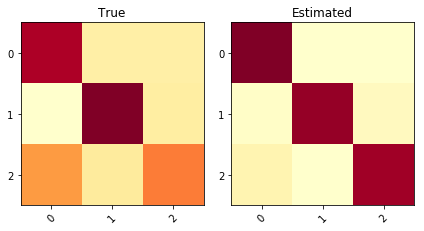

KL divergence: 0.4737	Pearson Correlation between diagonals: 0.6475


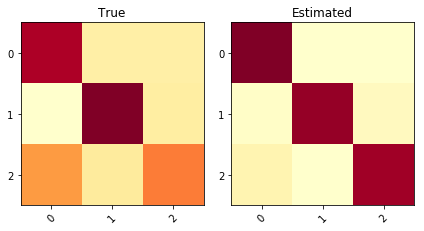

KL divergence: 0.4737	Pearson Correlation between diagonals: 0.6475


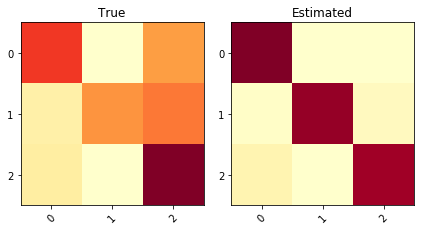

KL divergence: 0.8902	Pearson Correlation between diagonals: -0.4809


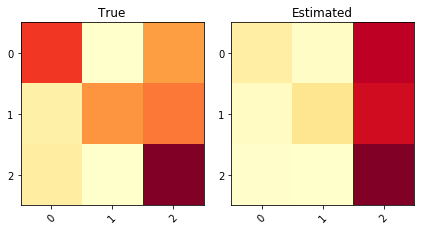

KL divergence: 0.3687	Pearson Correlation between diagonals: 0.8995


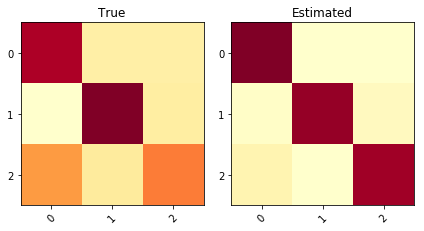

KL divergence: 0.4737	Pearson Correlation between diagonals: 0.6475


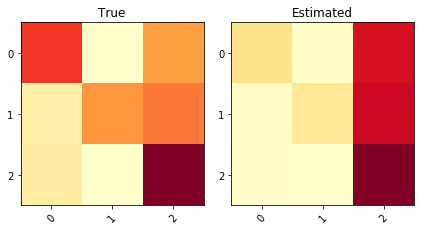

KL divergence: 0.2850	Pearson Correlation between diagonals: 0.9347


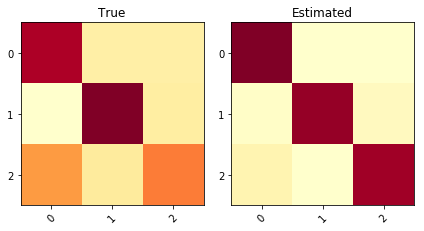

KL divergence: 0.4737	Pearson Correlation between diagonals: 0.6475


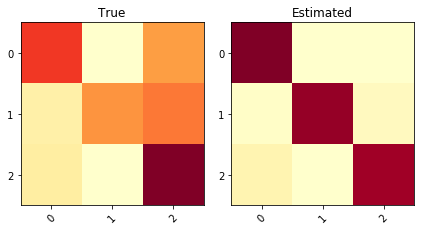

KL divergence: 0.8902	Pearson Correlation between diagonals: -0.4809


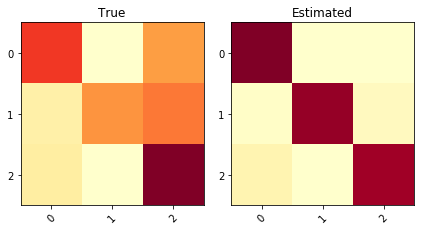

KL divergence: 0.8902	Pearson Correlation between diagonals: -0.4809


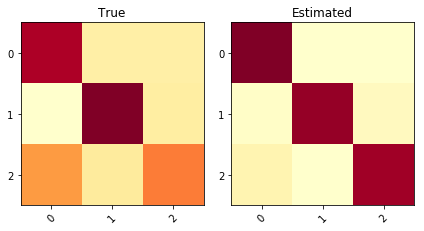

KL divergence: 0.4737	Pearson Correlation between diagonals: 0.6475


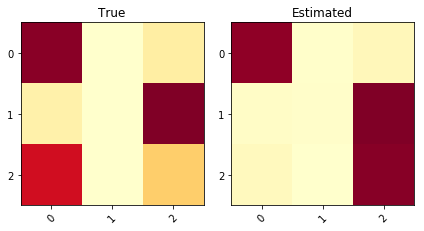

KL divergence: 0.6308	Pearson Correlation between diagonals: 0.7132


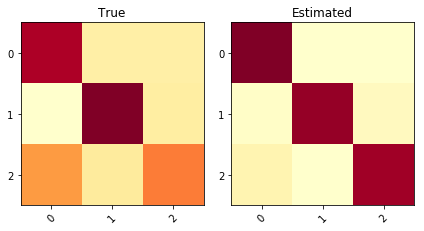

KL divergence: 0.4737	Pearson Correlation between diagonals: 0.6475


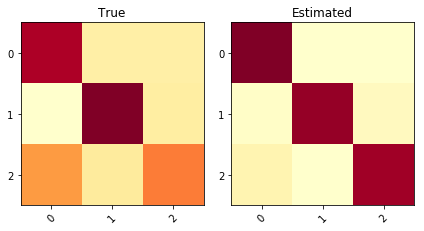

KL divergence: 0.4737	Pearson Correlation between diagonals: 0.6475


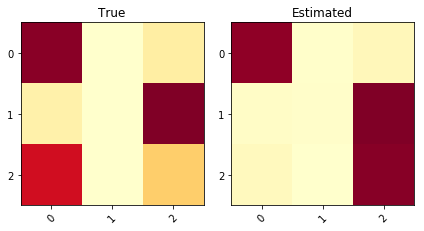

KL divergence: 0.6308	Pearson Correlation between diagonals: 0.7132


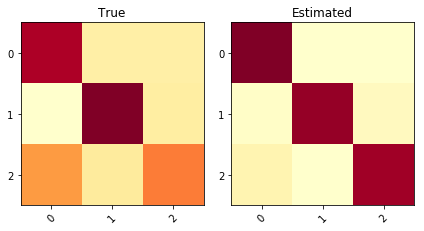

KL divergence: 0.4737	Pearson Correlation between diagonals: 0.6475
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.903948      0.903948   0.532344   0.084449            0.538721
====  ======  ==========  ============  =========  =========  ==================


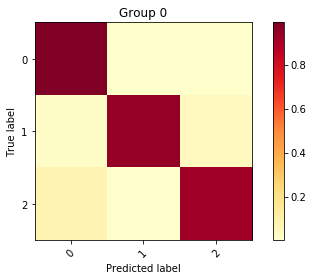

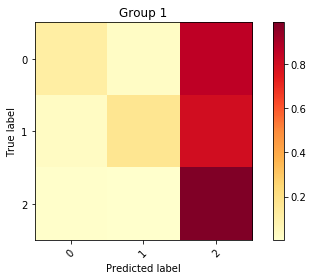

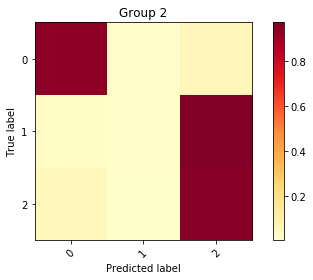

Inertia: 0.21284730484088263
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.49484       49   0.188301     0.95416   0.0473729       0.976535   0.93124
   1         1  0.200905      20   0.378559     0.424598  1.31129         0.537689   0.136897
   2         2  0.304255      30   0.193008     0.635324  1.58279         0.662139   0.452985
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [38]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc model

In [42]:
def distance_function(predicted,ob): # to cluster
    return -predicted*np.log(ob/predicted) #klwithoutsum --over 90 = 6 -- encuentra 3 grupos --over 90=7 (lambda=1)
 #model

In [ ]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc mode

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.515737 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.42035902 0.21363977 0.4940641 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 29.01 sec)	logL: -26688.027	
Iter 2/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -25685.506	Tol1: 0.03756	Tol2: 0.45811	Tol3: 0.15615	
Iter 3/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -25285.199	Tol1: 0.01558	Tol2: 0.19507	Tol3: 0.03165	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24976.377	Tol1: 0.01221	Tol2: 0.13462	Tol3: 0.01918	
Iter 5/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24709.277	Tol1: 0.01069	Tol2: 0.10289	Tol3: 0.01559	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24462.502	Tol1: 0.00999	Tol2: 0.08720	Tol3: 0.01500	
Iter 7/50
M step: done,  E step: done //  (in 0.25 sec)	log

M step: done,  E step: done //  (in 0.21 sec)	logL: -19953.511	Tol1: 0.00235	Tol2: 0.04944	Tol3: 0.01219	
Iter 35/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19921.002	Tol1: 0.00163	Tol2: 0.04759	Tol3: 0.01287	
Iter 36/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -19887.183	Tol1: 0.00170	Tol2: 0.04532	Tol3: 0.01016	
Iter 37/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19858.397	Tol1: 0.00145	Tol2: 0.04515	Tol3: 0.00926	
Iter 38/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19838.805	Tol1: 0.00099	Tol2: 0.04248	Tol3: 0.00928	
Iter 39/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19823.434	Tol1: 0.00077	Tol2: 0.03977	Tol3: 0.00822	
Iter 40/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -19808.777	Tol1: 0.00074	Tol2: 0.03849	Tol3: 0.00681	
Iter 41/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19793.905	Tol1: 0.00075	Tol2: 0.03660	Tol3: 0.00707	
Iter 42/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -19777.551	T

M step: done,  E step: done //  (in 0.22 sec)	logL: -21050.161	Tol1: 0.00492	Tol2: 0.04995	Tol3: 0.01519	
Iter 14/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20964.328	Tol1: 0.00408	Tol2: 0.04306	Tol3: 0.01426	
Iter 15/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20897.039	Tol1: 0.00321	Tol2: 0.04060	Tol3: 0.01352	
Iter 16/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20844.983	Tol1: 0.00249	Tol2: 0.04165	Tol3: 0.01253	
Iter 17/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20796.785	Tol1: 0.00231	Tol2: 0.04237	Tol3: 0.01110	
Iter 18/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20760.328	Tol1: 0.00175	Tol2: 0.04462	Tol3: 0.01011	
Iter 19/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20727.287	Tol1: 0.00159	Tol2: 0.04449	Tol3: 0.00900	
Iter 20/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20694.805	Tol1: 0.00157	Tol2: 0.04594	Tol3: 0.00851	
Iter 21/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20667.319	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -20296.670	Tol1: 0.00174	Tol2: 0.04682	Tol3: 0.00027	
Iter 44/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20255.990	Tol1: 0.00200	Tol2: 0.04526	Tol3: 0.00017	
Iter 45/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20215.991	Tol1: 0.00197	Tol2: 0.04530	Tol3: 0.00019	
Iter 46/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20180.933	Tol1: 0.00173	Tol2: 0.04508	Tol3: 0.00044	
Iter 47/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20141.386	Tol1: 0.00196	Tol2: 0.04208	Tol3: 0.00074	
Iter 48/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20102.008	Tol1: 0.00196	Tol2: 0.04046	Tol3: 0.00056	
Iter 49/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20061.779	Tol1: 0.00200	Tol2: 0.03857	Tol3: 0.00059	
Iter 50/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20027.792	Tol1: 0.00169	Tol2: 0.03841	Tol3: 0.00035	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!

M step: done,  E step: done //  (in 0.22 sec)	logL: -22593.504	Tol1: 0.00648	Tol2: 0.09170	Tol3: 0.00435	
Iter 10/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22453.406	Tol1: 0.00620	Tol2: 0.08689	Tol3: 0.00528	
Iter 11/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22318.357	Tol1: 0.00601	Tol2: 0.08125	Tol3: 0.00612	
Iter 12/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22182.486	Tol1: 0.00609	Tol2: 0.07508	Tol3: 0.00681	
Iter 13/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22050.017	Tol1: 0.00597	Tol2: 0.06884	Tol3: 0.00755	
Iter 14/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21919.244	Tol1: 0.00593	Tol2: 0.06262	Tol3: 0.00814	
Iter 15/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -21790.913	Tol1: 0.00585	Tol2: 0.05906	Tol3: 0.00871	
Iter 16/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21666.317	Tol1: 0.00572	Tol2: 0.05693	Tol3: 0.00940	
Iter 17/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -21555.692	T

### Multiples runs experiment
---

In [60]:
from  scipy.stats import entropy
def distance_function(predicted,ob): # to cluster
    #return [-np.sum(predicted*np.log(ob))] #funciona bien -- over 90 = 5 -- over 90 = 8 (lambda=1)
    #return -predicted*np.log(ob) #without sum -- over 90 = 6 -- over 90 = 3 (lambda=1)
    return [entropy(predicted, qk=ob)] #over 90 = 5-6 -- no son tan buenos pero encunetra 3
    #return -predicted*np.log(ob/predicted) #klwithoutsum --over 90 = 6 -- encuentra 3 grupos --over 90=7 (lambda=1)
    
    #con la opcion1 y modelo entrenado ??

    #aux = 0.5*predicted + 0.5*ob
    #return [0.5*entropy(predicted,aux) + 0.5*entropy(ob,aux)] # jensen shanon -- over 90 =3
    #return -np.sum(ob*np.log(predicted)) #alreves -- termina ocupando solo 1 grupo así
    #return -np.sum(predicted*ob) # dot product -- igual que arriba

In [61]:
from sklearn.metrics import accuracy_score
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(20):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 19:
        del gMixture
    gc.collect()
print("Done!")

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003759 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.10741473 0.4780553  0.75342387]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 14.92 sec)	logL: -25823.690	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -25089.256	Tol1: 0.02844	Tol2: 0.14394	Tol3: 0.00904	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24647.366	Tol1: 0.01761	Tol2: 0.07309	Tol3: 0.00809	
Iter 4/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24275.142	Tol1: 0.01510	Tol2: 0.05658	Tol3: 0.00583	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23939.183	Tol1: 0.01384	Tol2: 0.05722	Tol3: 0.00817	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23620.587	Tol1: 0.01331	Tol2: 0.06109	Tol3: 0.01171	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	log

M step: done,  E step: done //  (in 0.20 sec)	logL: -20513.957	Tol1: 0.00358	Tol2: 0.05386	Tol3: 0.00171	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20450.732	Tol1: 0.00308	Tol2: 0.05047	Tol3: 0.00163	
Iter 18/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20393.085	Tol1: 0.00282	Tol2: 0.04791	Tol3: 0.00143	
Iter 19/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20341.653	Tol1: 0.00252	Tol2: 0.04542	Tol3: 0.00133	
Iter 20/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20296.403	Tol1: 0.00222	Tol2: 0.04429	Tol3: 0.00116	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20257.042	Tol1: 0.00194	Tol2: 0.04248	Tol3: 0.00104	
Iter 22/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20221.542	Tol1: 0.00175	Tol2: 0.03985	Tol3: 0.00097	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20188.825	Tol1: 0.00162	Tol2: 0.03761	Tol3: 0.00074	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20158.146	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -20439.230	Tol1: 0.00193	Tol2: 0.02753	Tol3: 0.00240	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003641 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.44763553 0.94990104 0.69037604]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 17.83 sec)	logL: -26207.434	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25635.288	Tol1: 0.02183	Tol2: 0.16290	Tol3: 0.01550	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25353.106	Tol1: 0.01101	Tol2: 0.05623	Tol3: 0.00636	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25100.241	Tol1: 0.00997	Tol2: 0.03223	Tol3: 0.00212	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24851.974	Tol1: 0.00989	Tol2: 0.03182	Tol3: 0.00531	
Iter 6/50
M step: done,  E step: done //  (in 0.22

M step: done,  E step: done //  (in 0.21 sec)	logL: -22015.120	Tol1: 0.00485	Tol2: 0.03210	Tol3: 0.00653	
Iter 16/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21919.657	Tol1: 0.00434	Tol2: 0.02837	Tol3: 0.00624	
Finished training!
Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004013 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2092458  0.09579104 0.62687254]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 16.52 sec)	logL: -23775.856	
Iter 2/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23301.167	Tol1: 0.01997	Tol2: 0.13760	Tol3: 0.00709	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22918.633	Tol1: 0.01642	Tol2: 0.08407	Tol3: 0.00499	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22574.452	Tol1: 0.01502	Tol2: 0.07804	Tol3: 0.00455	
Iter 5/50
M step: done,  E step: done //  (in 0.1

In [24]:
colors = [cm.tab20(i) for i in range(20)] # b o c o tambn "_r"

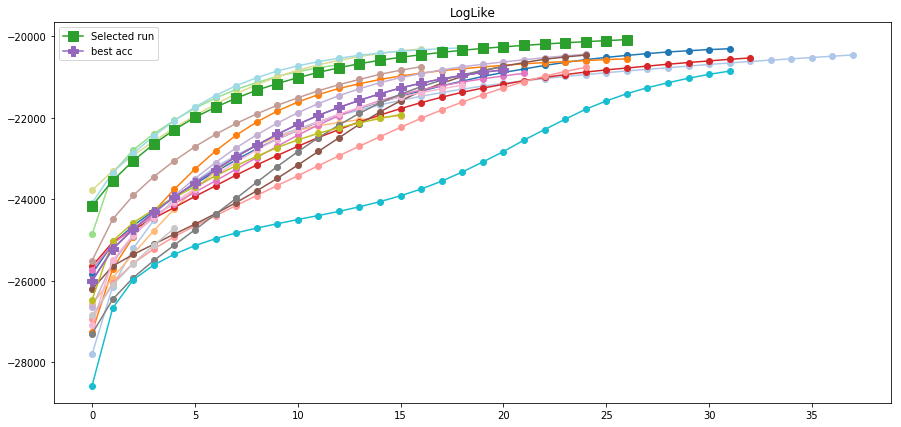

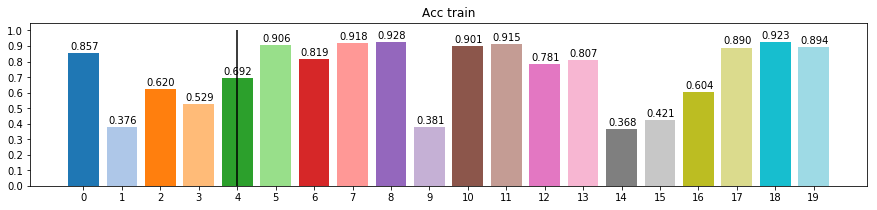

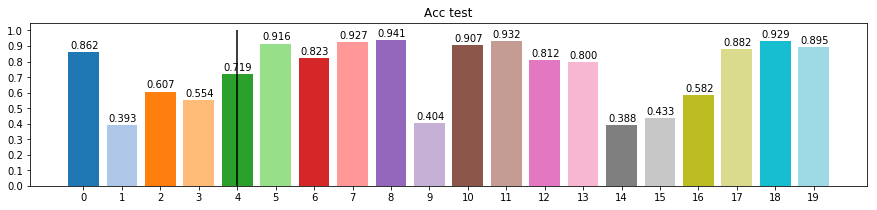

In [63]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

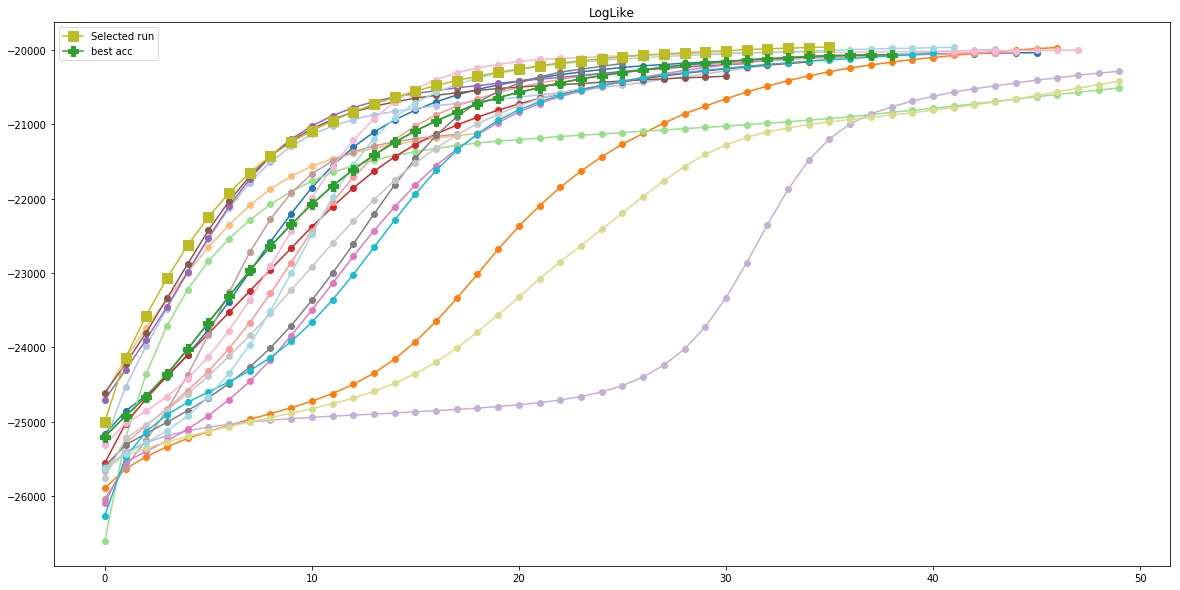

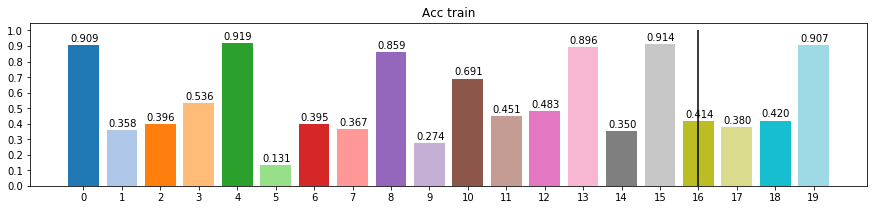

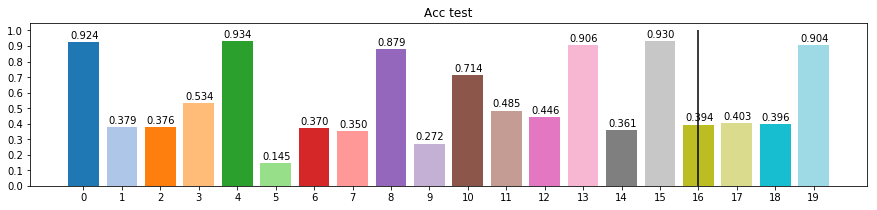

In [39]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(20,10))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

Values over 90 acc on test:  6


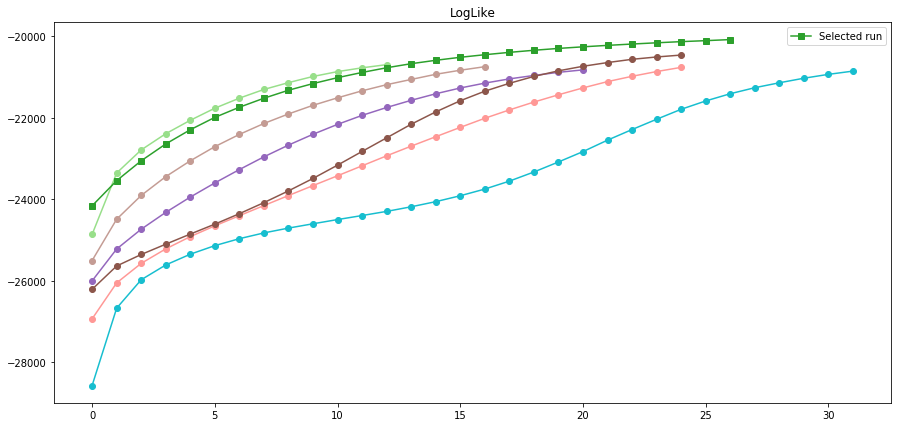

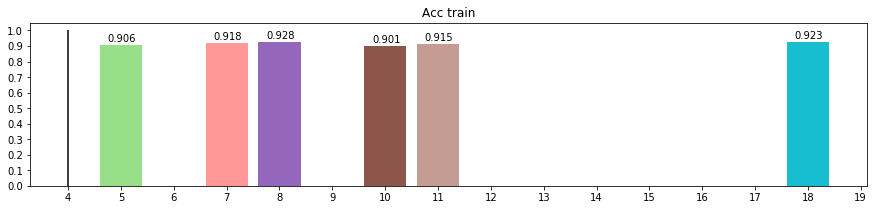

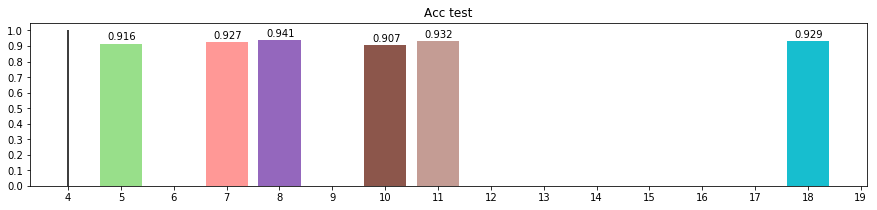

In [64]:
#just graph the high 90 acc
mask_high_values = (np.asarray(accTE_encontrados)>0.9) #and (np.asarray(accTR_encontrados>0.9))
print("Values over 90 acc on test: ",np.sum(mask_high_values))

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r and mask_high_values[a]:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
#plt.plot(range(len(logL_encontrados[i_r])),logL_hists[i_r],'o-',label="Selected run")
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

Values over 80 acc on test:  4


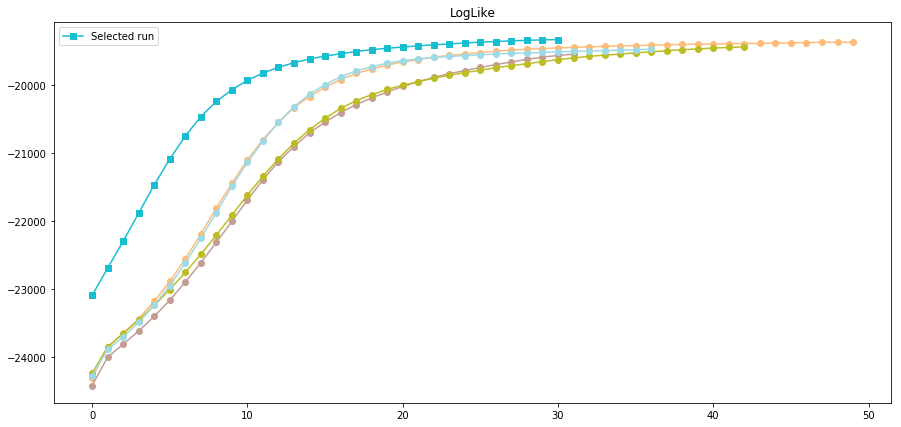

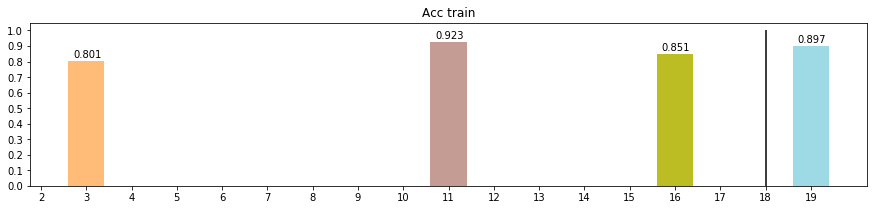

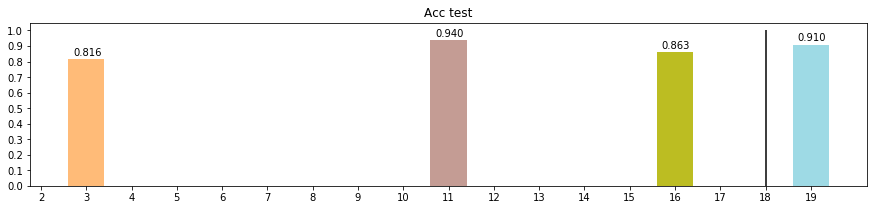

In [126]:
#just graph the high 80 acc
mask_high_values = (np.asarray(accTE_encontrados)>0.8) #and (np.asarray(accTR_encontrados>0.9))
print("Values over 80 acc on test: ",np.sum(mask_high_values))

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r and mask_high_values[a]:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

In [ ]:
what about first 3-5 iterations? #--funciona a veces :/

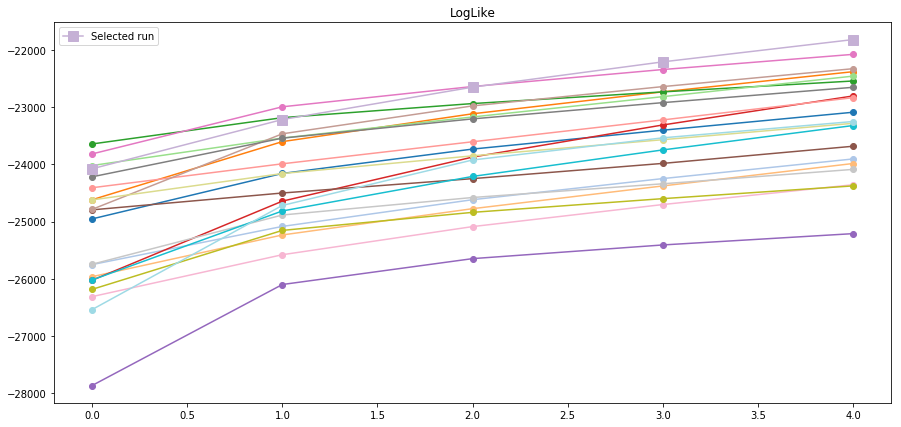

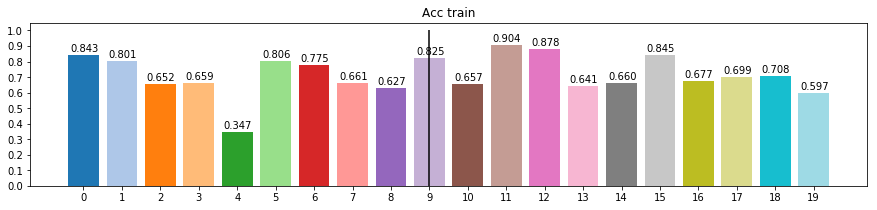

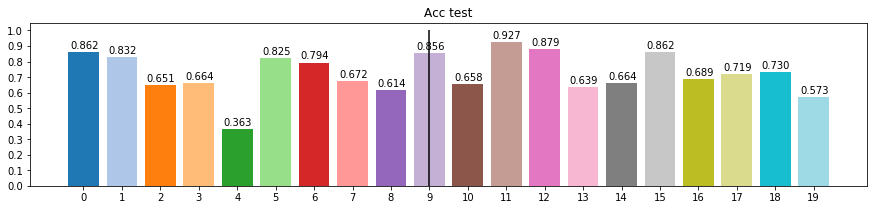

In [17]:
k_max = 5

i_r = np.argmax([value[k_max] for value in logL_encontrados])


#mask_high_values = (np.asarray(accTE_encontrados)>0.9) #and (np.asarray(accTR_encontrados>0.9))
#print("Values over 90 acc on test: ",np.sum(mask_high_values))
colors = [cm.tab20(i) for i in range(20)] # b o c o tambn "_r"

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(k_max),value[:k_max],'o-',c=colors[a])
plt.plot(range(k_max),logL_encontrados[i_r][:k_max],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

In [128]:
#what about tolerance conv -- el 2do es bueno (mismo que arriba) --- el 1ero es mejor en very bad MV
aux = np.asarray([(value[-1] - value[-2])/np.abs(value[-2]) for value in logL_encontrados])
print("Relative order: ",np.argsort(aux))
aux = np.asarray([(value[-1] - value[-2]) for value in logL_encontrados])
print("Difference order :",np.argsort(aux))
aux = np.asarray([(value[-1] - value[-2])/np.abs(value[-1]) for value in logL_encontrados])
print("Relative future order :",np.argsort(aux))

Relative order:  [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11 13  0 10 15]
Difference order : [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11  0 13 10 15]
Relative future order : [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11 13  0 10 15]


In [129]:
#what about delta conv mean -- los primeros 3 andan bien (solo el 1ero) -- en very bad MV el 2do es mejor..
aux = np.asarray([ np.mean([(value[i+1] - value[i])/np.abs(value[i]) for i in range(len(value)-1)]) for value in logL_encontrados])
print("Relative order: ",np.argsort(aux)[::-1])
aux = np.asarray([ np.mean([value[i+1] - value[i] for i in range(len(value)-1)]) for value in logL_encontrados])
print("Difference order :",np.argsort(aux)[::-1])

Relative order:  [ 4 15 10 13  0  5 11  9 19  8 18  6  2 16 17  1  7  3 12 14]
Difference order : [ 4 15 10 13  0  5 11  9 19  8  6 18  2 17  1 16  7  3 12 14]


In [18]:
#diversity -- 3ero es bueno
diversity_conf = [distance_2_centroid(matrix) for matrix in matrices_encontradas]
np.argsort(diversity_conf)[::-1]

array([ 8,  6,  2, 12, 11,  1,  7,  5,  9,  3, 14, 19,  0, 15, 17, 18, 13,
       10, 16,  4])

* seleccion de 1eras iteraciones: valor medio (ni muy bueno ni muy malo)
* el 1ero y 3ero de diversity anda bien, el 2do hace match con la seleccion de barras arriba
* el 1ero y 3ero de diversity anda en valor medio, el 1ero hace match con la seleccion de barras arriba
* difference convergence: solo 1ero anda  bien
* difference convergence: los primeros no andan nada bien (bastante mal)
* tolerance convergence: 2 priemros valors andan bien
* tolerance convergence: el primero anda bien

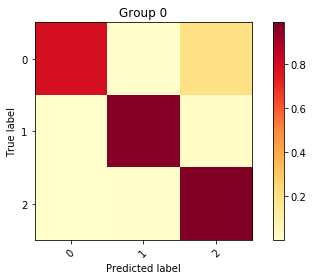

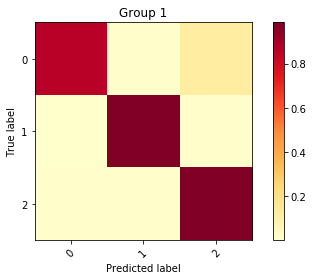

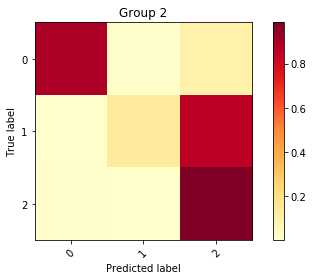

Inertia: 0.1005351134420683
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.298012      29   0.241592     0.91821   0.0905791       0.956062   0.584876
   1         1  0.183288      18   0.206137     0.944829  0.0583558       0.971293   0.611496
   2         2  0.5187        51   0.288013     0.672738  0.702782        0.746967   0.339405
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [93]:
results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[2]) #PCA

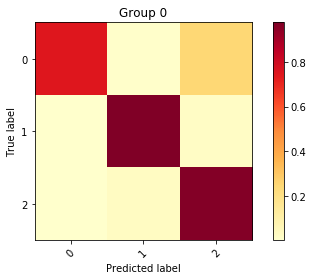

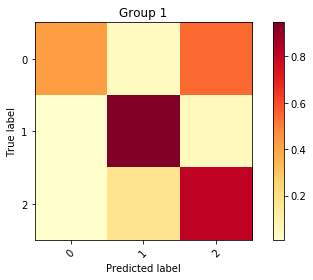

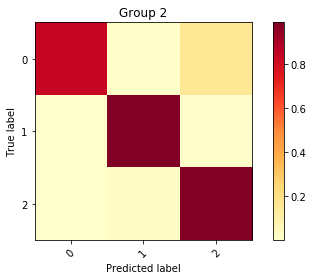

Inertia: 0.02718729921616614
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  ======  =========  ===========  =========  =============  =========
   0         0  0.575043       57   0.287592     0.896578  0.116829        0.943692   0.844867
   1         1  0.0463163       4   0.521101     0.727678  0.375092        0.83209    0.591517
   2         2  0.378641       37   0.219132     0.93353   0.0717618       0.964915   0.900295
====  ========  =========  ======  =========  ===========  =========  =============  =========


In [65]:
results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[4]) #best acc model

In [47]:
#measure on best
selected = 12
gMixture.betas = matrices_encontradas[selected].copy()
gMixture.base_model = modelos_encontrados[selected]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

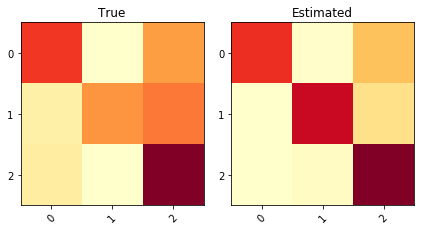

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6535


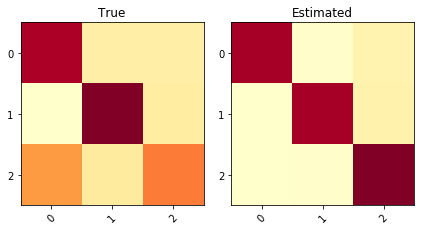

KL divergence: 0.7302	Pearson Correlation between diagonals: -0.9766


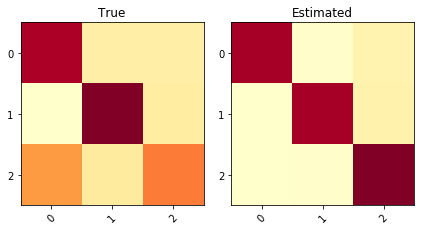

KL divergence: 0.7302	Pearson Correlation between diagonals: -0.9766


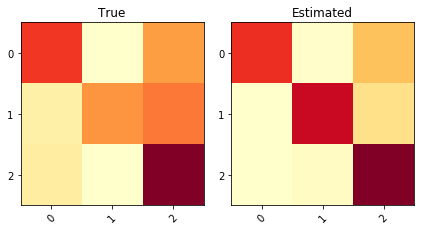

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


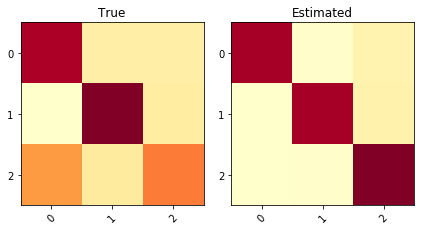

KL divergence: 0.7302	Pearson Correlation between diagonals: -0.9766


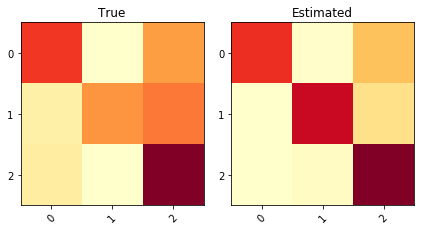

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


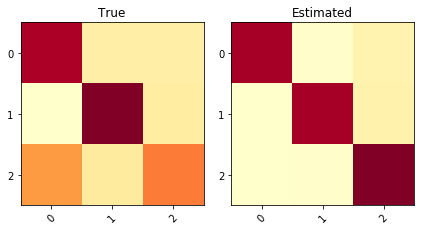

KL divergence: 0.7302	Pearson Correlation between diagonals: -0.9766


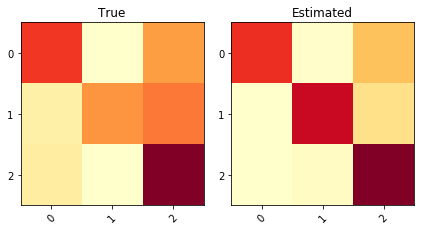

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


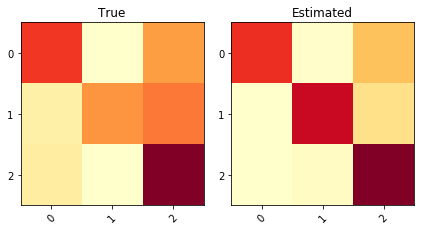

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


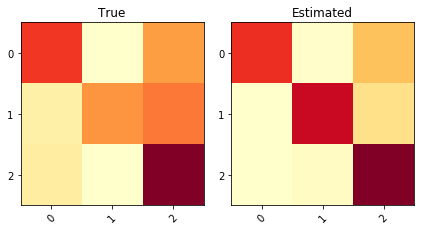

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


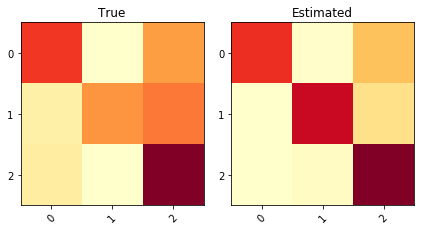

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6535


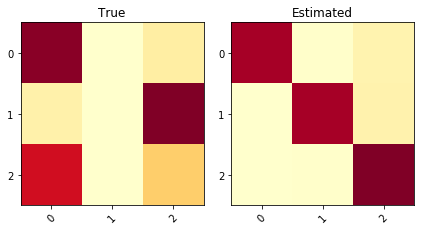

KL divergence: 2.1056	Pearson Correlation between diagonals: -0.2592


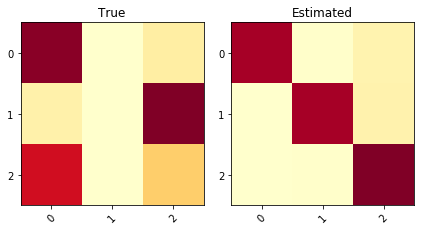

KL divergence: 2.1056	Pearson Correlation between diagonals: -0.2592


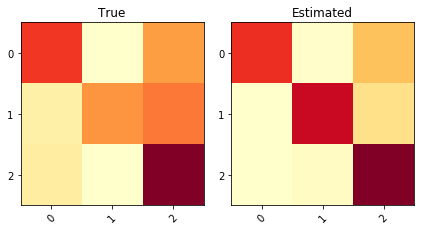

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


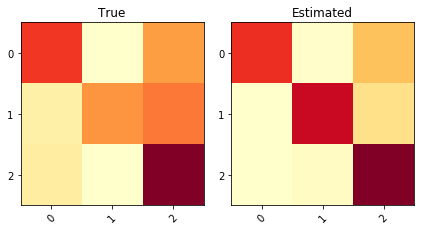

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.881156      0.881156   0.731918   0.101208           0.0165031
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.885226      0.885226
====  ======  ==========  ============


In [48]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred) #PCA

### $\lambda$ random on clean data 2

In [227]:
#1,2,9,14,15,18 ----5,8,16(aprox), 19 very aprox
#revisar log loss..
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #best is lambda close to 1

Indices:  [19  8  1 15 14 18 16  4  0  9 10  2  7 13 12  6  3 17  5 11]
F1 scores:  0.9567233308497585
F1 scores:  0.9722991947952253
F1 scores:  0.9730373373417617
F1 scores:  0.9708188472037063
F1 scores:  0.956016774823882


array([[[0.52382575, 0.21659293, 0.25958132],
        [0.11623011, 0.83725768, 0.04651221],
        [0.44169099, 0.00159129, 0.55671772]],

       [[0.21783677, 0.41721678, 0.36494644],
        [0.4749662 , 0.49408818, 0.03094562],
        [0.4142501 , 0.00183745, 0.58391245]]])

In [231]:
for ind in indexs_sort[:5]:
    print("LogLoss %f "%logL_iter[ind] )

LogLoss -74753.037878 
LogLoss -74846.558465 
LogLoss -74848.771741 
LogLoss -74881.145240 
LogLoss -75019.563584 


### $\lambda$ =1 on clean data 2

In [232]:
# 0 y 1 interesantes--3 aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [3 0 1 2 4]
F1 scores: 0.955606 y LogLoss -74719.447607 
F1 scores: 0.968179 y LogLoss -74883.187174 
F1 scores: 0.960457 y LogLoss -74920.960253 
F1 scores: 0.956374 y LogLoss -75083.774056 
F1 scores: 0.351232 y LogLoss -76185.540685 


array([[[0.50777171, 0.22507155, 0.26715675],
        [0.11185078, 0.83924488, 0.04890434],
        [0.4582481 , 0.00159581, 0.54015609]],

       [[0.22760429, 0.41990971, 0.352486  ],
        [0.47839272, 0.49042606, 0.03118121],
        [0.40264624, 0.00196233, 0.59539143]]])

In [239]:
#con alfa data dependent --> 3,2 y 0 muy buenos
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.458558 y LogLoss -73051.591996 
F1 scores: 0.962240 y LogLoss -73313.658698 
F1 scores: 0.965886 y LogLoss -73497.073680 
F1 scores: 0.974446 y LogLoss -73702.008816 
F1 scores: 0.971485 y LogLoss -73704.003644 


array([[[7.05309888e-01, 6.78381229e-03, 2.87906299e-01],
        [7.35180890e-02, 9.24724807e-01, 1.75710357e-03],
        [5.01078305e-01, 2.81658016e-01, 2.17263679e-01]],

       [[4.66742009e-01, 1.93783100e-04, 5.33064208e-01],
        [6.14267012e-01, 3.16643747e-01, 6.90892417e-02],
        [1.89225399e-01, 1.86074745e-03, 8.08913853e-01]]])

### $\lambda$ random on noise data 2

In [254]:
#9,1,16,4,17 -.- aprox : 15,7,3,8 , 13 very aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda aprox to 1

Indices:  [13  1 15  9 16  2 12  7 18  3  4 17 11 19  6 14  0  5 10  8]
F1 scores: 0.888830 y LogLoss -78001.588032 
F1 scores: 0.892016 y LogLoss -78116.591164 
F1 scores: 0.884132 y LogLoss -78137.777845 
F1 scores: 0.883747 y LogLoss -78254.586413 
F1 scores: 0.883738 y LogLoss -78314.510964 


array([[[0.27134669, 0.35397641, 0.3746769 ],
        [0.44678169, 0.51668657, 0.03653173],
        [0.4222056 , 0.00645561, 0.5713388 ]],

       [[0.50628012, 0.21383676, 0.27988311],
        [0.14782917, 0.80655601, 0.04561483],
        [0.42775275, 0.00488844, 0.56735881]]])

In [255]:
matrices_encontradas[indexs_sort[1]] #-- l_0 == 1 l_1 ==0

array([[[0.08295195, 0.40093714, 0.51611091],
        [0.48669173, 0.45809595, 0.05521232],
        [0.62825357, 0.00538692, 0.36635951]],

       [[0.94113627, 0.02508032, 0.03378341],
        [0.00918393, 0.98703061, 0.00378546],
        [0.0255219 , 0.00113546, 0.97334265]]])

In [258]:
#with data dependent: 14,8,17,18,6,7
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #

Indices:  [10 16  9  1  2 19 15  0 13  5 12  6  3 11  8  7 17 14 18  4]
F1 scores: 0.569450 y LogLoss -72703.277615 
F1 scores: 0.491469 y LogLoss -72720.581623 
F1 scores: 0.508396 y LogLoss -72767.949725 
F1 scores: 0.491615 y LogLoss -72825.122112 
F1 scores: 0.507041 y LogLoss -72896.068329 


array([[[3.79349307e-01, 6.94819793e-04, 6.19955873e-01],
        [7.77944156e-01, 8.23359122e-02, 1.39719932e-01],
        [3.06555768e-01, 2.04645067e-04, 6.93239587e-01]],

       [[4.25210560e-01, 5.09417750e-01, 6.53716909e-02],
        [6.15437909e-02, 9.38092005e-01, 3.64204100e-04],
        [5.08005925e-01, 3.63402917e-01, 1.28591157e-01]]])

### $\lambda$ =1 on noise data 2

In [262]:
#1,3 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [1 3 4 0 2]
F1 scores: 0.891017 y LogLoss -77959.391833 
F1 scores: 0.886087 y LogLoss -78123.030905 
F1 scores: 0.884353 y LogLoss -78170.862790 
F1 scores: 0.882184 y LogLoss -78190.927143 
F1 scores: 0.859548 y LogLoss -78572.408112 


array([[[0.25098253, 0.35037085, 0.39864661],
        [0.44670657, 0.51498243, 0.038311  ],
        [0.4298412 , 0.00810423, 0.56205457]],

       [[0.52964153, 0.20908235, 0.26127612],
        [0.15634487, 0.79921221, 0.04444291],
        [0.41637648, 0.00626742, 0.57735611]]])

### $\lambda$ random on clean data 1

In [280]:
#15,11,10,19,9,8 -- very aprox 1,5,6
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 1,0.3,0.9

Indices:  [ 5 15 11  8 14 10 16  1 19  4  9  6 12  0  2 18 13  3 17  7]
F1 scores: 0.954411 y LogLoss -77836.820531 
F1 scores: 0.958790 y LogLoss -77941.398320 
F1 scores: 0.940030 y LogLoss -77965.365354 
F1 scores: 0.947836 y LogLoss -78038.735143 
F1 scores: 0.910642 y LogLoss -78040.768166 


array([[[0.55499299, 0.40424585, 0.04076116],
        [0.74376586, 0.24764065, 0.00859349],
        [0.46344935, 0.36092144, 0.1756292 ]],

       [[0.82776326, 0.12548399, 0.04675276],
        [0.08155971, 0.90830062, 0.01013967],
        [0.03171331, 0.04560996, 0.92267673]],

       [[0.53795303, 0.34491255, 0.11713442],
        [0.22329621, 0.75771587, 0.01898792],
        [0.09282163, 0.195167  , 0.71201137]]])

In [284]:
matrices_encontradas[indexs_sort[1]] #lambda 1,0.75,0

array([[[0.67928817, 0.28913513, 0.0315767 ],
        [0.54120412, 0.45556271, 0.00323317],
        [0.42460938, 0.25247046, 0.32292017]],

       [[0.62701399, 0.27485157, 0.09813444],
        [0.22333284, 0.76642445, 0.01024272],
        [0.09648147, 0.14086318, 0.76265535]],

       [[0.52124351, 0.36240502, 0.11635147],
        [0.24622555, 0.74312222, 0.01065222],
        [0.09708732, 0.23612256, 0.66679012]]])

### $\lambda$ =1 on clean data 1

In [273]:
# 0 y 2 , quizas el 3
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [0 4 1 2 3]
F1 scores: 0.957691 y LogLoss -77777.045732 
F1 scores: 0.949563 y LogLoss -77822.228357 
F1 scores: 0.953599 y LogLoss -77856.778807 
F1 scores: 0.948690 y LogLoss -77872.086503 
F1 scores: 0.931905 y LogLoss -77906.054126 


array([[[0.59412547, 0.36171718, 0.04415735],
        [0.66799795, 0.32474261, 0.00725944],
        [0.52856849, 0.30642452, 0.16500699]],

       [[0.52760818, 0.33752145, 0.13487037],
        [0.31600033, 0.66175519, 0.02224447],
        [0.14146238, 0.22927853, 0.62925909]],

       [[0.56413881, 0.31949401, 0.11636717],
        [0.21524957, 0.76938829, 0.01536214],
        [0.07210637, 0.21926451, 0.70862912]]])

### $\lambda$ random on noisy data 1

In [305]:
# 4,15,18
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 0.9,0.95,0.77

Indices:  [16 15 17  2 19 12 14  5 18  1  6  4  7 13 10 11  8  3  9  0]
F1 scores: 0.869044 y LogLoss -78922.915633 
F1 scores: 0.866170 y LogLoss -78982.619162 
F1 scores: 0.861920 y LogLoss -79051.791381 
F1 scores: 0.857006 y LogLoss -79139.196237 
F1 scores: 0.847250 y LogLoss -79204.031599 


array([[[0.58607908, 0.36341081, 0.05051011],
        [0.66739828, 0.32284521, 0.00975651],
        [0.493704  , 0.30487077, 0.20142523]],

       [[0.50693243, 0.34776968, 0.14529789],
        [0.31437943, 0.65691552, 0.02870504],
        [0.12305859, 0.27650573, 0.60043568]],

       [[0.60705624, 0.26678528, 0.12615848],
        [0.18890858, 0.78930815, 0.02178327],
        [0.06595133, 0.17302841, 0.76102026]]])

In [306]:
matrices_encontradas[indexs_sort[1]] #lambda 0.9,0.15,1

array([[[0.54434378, 0.39895361, 0.05670261],
        [0.69226245, 0.29917253, 0.00856502],
        [0.48889289, 0.32543488, 0.18567223]],

       [[0.88857981, 0.07739007, 0.03403012],
        [0.04260737, 0.95177684, 0.00561578],
        [0.01874574, 0.03511641, 0.94613784]],

       [[0.46865228, 0.36090133, 0.1704464 ],
        [0.28625581, 0.6858124 , 0.02793179],
        [0.11223195, 0.26951884, 0.61824921]]])

### $\lambda$ =1 on noisy data 1

In [315]:
# 1 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.871127 y LogLoss -78805.593847 
F1 scores: 0.867015 y LogLoss -78817.192683 
F1 scores: 0.849491 y LogLoss -78854.670714 
F1 scores: 0.865092 y LogLoss -78979.309951 
F1 scores: 0.866156 y LogLoss -78985.742220 


array([[[0.58714018, 0.36795373, 0.0449061 ],
        [0.69558504, 0.29376966, 0.0106453 ],
        [0.48082751, 0.31934017, 0.19983232]],

       [[0.54569706, 0.3299119 , 0.12439103],
        [0.27193291, 0.7006825 , 0.02738459],
        [0.11665229, 0.23142926, 0.65191844]],

       [[0.57664747, 0.29595247, 0.12740006],
        [0.20585552, 0.76759455, 0.02654993],
        [0.09077485, 0.19447976, 0.71474539]]])

In [259]:
Qij_gamma = np.sum(gMixture.get_qestimation(),axis=-2) #qij(gamma)
r_estimate = np.zeros((Qij_gamma.shape[0],Qij_gamma.shape[2])) #repeat estimate
for i in range(Qij_gamma.shape[0]):
    r_estimate[i] = np.tensordot(Qij_gamma[i],r_obs[i],axes=[[0],[0]])
r_estimate

array([[ 0.20453249, 25.85263166,  2.94283584],
       [ 0.12035406, 24.94385666,  0.93578928],
       [24.07822754,  4.97867884,  1.94309361],
       ...,
       [ 0.25168615, 31.56533154,  0.18298231],
       [ 7.46407726, 17.98318088,  9.55274186],
       [ 0.91988414,  0.0756443 , 27.00447157]])

In [71]:
gMixture.get_predictions(Xstd_train)

array([[0.06842059, 0.73907024, 0.19250914],
       [0.02262934, 0.94639385, 0.03097681],
       [0.4558536 , 0.44500634, 0.09914005],
       ...,
       [0.03236194, 0.94923073, 0.01840742],
       [0.30035946, 0.30898702, 0.3906535 ],
       [0.15407403, 0.0127452 , 0.8331808 ]], dtype=float32)

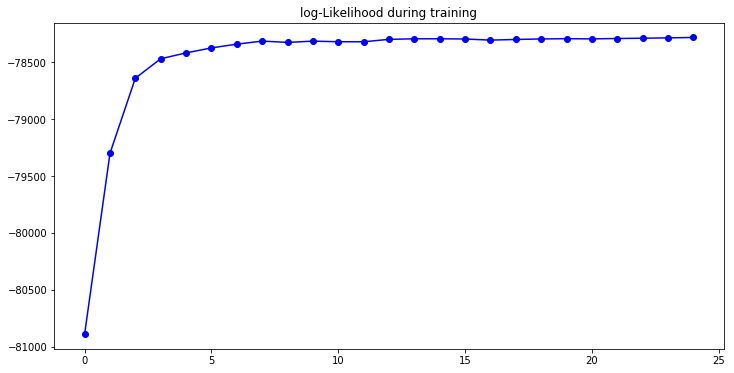

In [185]:
plt.figure(figsize=(12,6))
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.title("log-Likelihood during training")
plt.show()

In [146]:
### model over ground truth
model = clone_model(gMixture.get_basemodel())
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(Xstd_train, keras.utils.to_categorical(Z_train), batch_size=128,epochs=50)
from utils import calculate_f1_keras
print(calculate_f1_keras(model, Xstd_train, Z_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2700/2700 [==============================] - 1s 442us/step - loss: 0.7655
Epoch 2/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.7441
Epoch 3/50
2700/2700 [==============================] - 0s 34us/step - loss: 0.7239
Epoch 4/50
2700/2700 [==============================] - 0s 35us/step - loss: 0.7050
Epoch 5/50
2700/2700 [==============================] - 0s 31us/step - loss: 0.6872
Epoch 6/50
2700/2700 [==============================] - 0s 33us/step - loss: 0.6704
Epoch 7/50
2700/2700 [==============================] - 0s 38us/step - loss: 0.6546
Epoch 8/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.6397
Epo

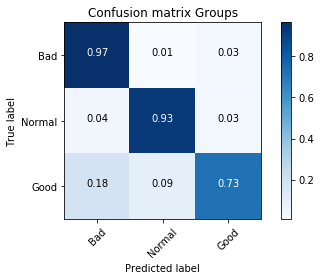

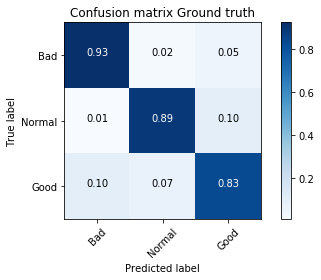

In [147]:
from utils import *
classes = ["Bad","Normal","Good"]
plot_confusion_keras(gMixture.base_model,Xstd_train,Z_train,classes,title='Confusion matrix Groups')
plot_confusion_keras(model,Xstd_train,Z_train,classes,title='Confusion matrix Ground truth')


<a id="condato"></a>
### Training module 2
---
Here we implement the iteration between **E** and **M** steps with bulks annotations $r_{itj}$.

In [ ]:
class GroupMixtureBulk(object):
    def __init__(self,input_dim,Kl=2,M=2,alpha_DD=True,epochs=1,optimizer='adam'): 
        
        
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        self.compile=False
        self.Keps = keras.backend.epsilon()
        self.priors=False #boolean of priors
        #params
        self.M = M #groups of annotators
        self.data_dependence = alpha_DD #for alpha = p(g|x) or p(g)
        self.epochs = epochs
        self.optimizer = optimizer
        
        self.seted_alphainit = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas
    def get_alpha(self):
        """Get alpha param, p(g|xi) for every data on trainig or globally p(g)"""
        return self.alphas
    def set_alpha(self,alphas_init):
        """set alpha param with a previosuly method"""
        self.alphas = alphas_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        return self.Qi_mgamma
        
    def define_model(self,tipo,*args):
        """Define the base model and other structures"""
        aux_info = None
        emb_info = None
        self.type = tipo.lower()
        if self.type =="cnn":
            info,aux_info =args
        elif self.type == "rnn":
            info,aux_info,emb_info = args            
        elif self.type == "ff" or self.type == "mlp": #classic feed forward
            start_units,deep,activation = args
            info = [start_units,deep,activation]
        elif self.type == "keras_shallow" or self.type=="keras_perceptron": 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl,self.optimizer)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        
        if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
            self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X,batch_size=None):
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=batch_size)
    
    def init_E(self,X,r):
        
        
        self.N = X.shape[0]
        #-------> init alpha
        if not self.seted_alphainit:
            self.alphas = np.random.dirichlet(np.ones(self.M),size=self.N) # random start that sum one
        
        #-------> init Majority voting
        mv_probs = majority_voting(r,repeats=True,probas=True)
        #majority voting by group...
        """
        mv_prob_groups = []
        r_sample = 0
        for l in range(self.M):
            aux_mv_probs = majority_voting(np.clip(r-r_sample,0,1e100),repeats=True,probas=True)
            r_sample = []
            for i in range(self.N):
                total_annotators = np.sum(r[i])
                ri_sample = np.random.multinomial(total_annotators/self.M, aux_mv_probs[i]) #asumming al groups have same number of annotators
                r_sample.append(ri_sample)
            r_sample = np.asarray(r_sample)
            mv_prob_groups.append(majority_voting(r_sample,repeats=True,probas=True) )
        """
        
        #-------> init q_i
        self.Qi_mgamma = np.random.rand(self.N,self.M,self.Kl) #random init
        #"""
        for i in range(self.N):            
            #for m in range(self.M):
            self.Qi_mgamma[i] = np.tensordot(self.alphas[i], mv_probs[i],axes=-1)  #a interestetnly E-step  
        
        #-------> init betas
        self.betas = np.random.rand(self.M,self.Kl,self.Kl)
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None]
        
        """
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(mv_probs[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])
            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
        """
        
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",mv_probs.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qi_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if len(priors.shape)==2:
            priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions,r): #r is data
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(predictions[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])

            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
                                                                                                                       
    def M_step(self,X,r): 
        #-------> base model
        #create the repeat "estimate"/"ground truth"
        Qi_gamma = np.sum(self.Qi_mgamma,axis=-2) #qi(gamma)
        #train to learn p(z|x)
        if "sklearn" in self.type:
            self.base_model.fit(X, np.argmax(Qi_gamma,axis=1) ) 
        else:
            history = self.base_model.fit(X,Qi_gamma,batch_size=self.batch_size,epochs=self.epochs,verbose=1) 
            
        #-------> alpha --maneja caso global y normal..
        Qi_m = np.sum(self.Qi_mgamma,axis=-1) #qi(m)
        if not self.data_dependence: #global alpha
            g_estimate = np.sum(Qi_m,axis=0)
            self.alphas[:] = g_estimate/np.sum(g_estimate,axis=-1) #p(g) 
        else:
            self.alphas = Qi_m #p(g|x)
        
        #-------> beta   # p(yo|g,z)
        for m in range(self.M):
            for j_z in range(self.Kl):
                for j_ob in range(self.Kl):
                    self.betas[m,j_z,j_ob] = np.tensordot(self.Qi_mgamma[:,m,j_z],r[:,j_ob], axes=[[0],[0]]) # ~p(yo|g,z)
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior function
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None] #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        
                                                
    def train(self,X_train,r_train,batch_size=32,iterations=250,tolerance=0.001,relative=False): #0.0001  
        
                                                  

gMixtureRaykar = GroupMixtureBulk(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=10)
###epochs=1 as Rodriges says. and batch size as default
gMixtureRaykar.Kl

In [ ]:
gMixtureRaykar = GroupMixtureBulk(X_train.shape[1:],Kl=r_obs.shape[1],M=100)

#gMixture.define_model("sklearn_logistic") #logistic necesita datos de todas la clases
gMixtureRaykar.define_model("keras_shallow")
gMixtureRaykar.set_alpha(alphas_init_Raykar)
#gMixtureRaykar.set_alpha((y_obs!=-1)*1)

#need priors!!!--lo hace mas estable
M = 100
gMixtureRaykar.define_priors(np.ones((M,r_obs.shape[1])))

logL_hist = gMixtureRaykar.train(Xstd_train,r_obs,batch_size=64,iterations=10,relative=False)